In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
from scipy.interpolate import RegularGridInterpolator, CubicSpline
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# σy = 0*np.mean(θ_list)
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
γ3_list = np.array([0, 0.0197*2, 1/3])
# γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

# y_step = 0.05
# y_grid = np.arange(0., 4 + y_step, y_step)

k_step = 0.1
k_grid = np.arange(0., 9 + k_step, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [4]:
y_mat.shape

(101, 91)

In [5]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    
    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)
    v0 =  -  η*y_mat**2 + k_mat**2
    ems_new = η*y_mat**2 + k_mat**2
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    vd = - 1/δ
    while lhs_error > tol:
        if episode ==0:
            i = 0
            ems = ems_new
            mc_new = 1/(α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems/np.exp(k_mat))**θ) )
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,dy)
        v0_dyy = derivatives_2d(v0,0,2,dy)
        v0_dk = derivatives_2d(v0,1,1,dk)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
        v0_dkk = derivatives_2d(v0,1,2,dk)
        # updating controls
        mc = mc_new
        i_new = 1 - mc/v0_dk
        # update emission
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*np.exp(ϑ_bar)*np.exp(2*(λ_bar-k_mat))
        b = mc*θ*np.exp(ϑ_bar + λ_bar - k_mat) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
        ems_new[ems_new < 1e-15] = 1e-15
        mc_new = 1/(α - i_new - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat))**θ) )
#         ems_new[ems_new <= 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5

#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
        print(np.min(ems_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems_new
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

$$
mc = \frac{1}{\alpha - i - \alpha \vartheta (1 - \frac{e}{\alpha \lambda  \exp(k)})^\theta}
$$

First order condition for $i$:

$$
 - mc + \frac{d\phi}{dk} (1 - \kappa i) = 0
$$

FOC for $e$:

$$
mc (\bar{\vartheta} \theta \frac{1 }{\lambda \exp (k)}  (1 - \frac{e}{\alpha \lambda \exp{k}})^{\theta - 1}) + 
$$

In [8]:
# HJB for ϕ_m
# θ = 2
θ = 3
y_bar = 2
ξa = 0.01
# ξa = 10000
# ξb = 3
ξb = 10000
λ_bar = 0.134
# λ_bar = 0.102
# λ_bar = 0.0925
# ϑ_bar = 0.078
# ϑ_bar = 0.054
# ϑ_bar = 0.048

ϑ_bar = 0.052
# ϑ_bar = 0.036
# ϑ_bar = 0.032

γ3 = γ3_list[2]
# γ3 = 0.125

α=0.115

# ϵ=2.5
ϵ=0.1


max_iter=2000
tol=1e-7

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

# dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
dΛ = γ1 + γ2*y_mat + γ3*(y_mat-ȳ)*(y_mat>ȳ)
# ddΛ = γ2 + γ3*(y_mat > y_bar)
ddΛ = γ2 + γ3*(y_mat>ȳ)

    
# initial guess
v0 =  (1/δ)*k_mat  -  η/δ*y_mat**2 
# initial i
a_i = κ*(1/δ)
b_i = - (1 + α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

ems = η*np.ones(y_mat.shape)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

episode = 0
lhs_error = 0.5
vd = - 1/δ

while lhs_error > tol:
    vold = v0.copy()
    v0_dy = derivatives_2d(v0,0,1,dy)
    v0_dyy = derivatives_2d(v0,0,2,dy)
    v0_dk = derivatives_2d(v0,1,1,dk)
    v0_dk[v0_dk < 1e-15] =  1e-15
    v0_dkk = derivatives_2d(v0,1,2,dk)
    # updating controls
    i_new = (1 -mc/v0_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
        ems_new = (ems_new)*(ems_new>0)
    elif θ == 3:
        b = v0_dyy*σy**2 + vd*ddΛ*σy**2 - 2*mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        c = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        a = mc*θ*ϑ_bar/(α**2*λ_bar**3*np.exp(3*k_mat))    
        ems_new =  (-b-np.sqrt(b**2 - 4*a*c))/(2*a)
        ems_new = (ems_new)*(ems_new>0)

    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[c# mc[mc < 1e-15] = 1e-1510onsumption <= 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = v0_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = - np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

min ems: 0.0304
min mc 39.99791726530605
Episode 0: PDE Error: 1.948494489228; False Transient Error: 1.947118439440; Iterations: 4; CG Error: 0.000000000027
min ems: 0.02888
min mc 39.99791014326661
Episode 1: PDE Error: 1.939982873778; False Transient Error: 1.938746618717; Iterations: 4; CG Error: 0.000000000086
min ems: 0.027436
min mc 39.99790187798954
Episode 2: PDE Error: 1.934524796138; False Transient Error: 1.933454903722; Iterations: 5; CG Error: 0.000000000010
min ems: 0.026064199999999996
min mc 39.99789154736131
Episode 3: PDE Error: 1.930555823933; False Transient Error: 1.929641767158; Iterations: 5; CG Error: 0.000000000040
min ems: 0.024760989999999993
min mc 39.99787842350253
Episode 4: PDE Error: 1.927430128350; False Transient Error: 1.926628422532; Iterations: 6; CG Error: 0.000000000008
min ems: 0.023522940499999992
min mc 39.99786193875501
Episode 5: PDE Error: 1.924794758170; False Transient Error: 1.924072814367; Iterations: 6; CG Error: 0.000000000024
min ems

Episode 50: PDE Error: 1.839796814848; False Transient Error: 1.839699137784; Iterations: 9; CG Error: 0.000000000095
min ems: 0.002222170885991474
min mc 39.96558880954428
Episode 51: PDE Error: 1.837978596933; False Transient Error: 1.837883981862; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0021110623416919004
min mc 39.96586736049117
Episode 52: PDE Error: 1.836161804641; False Transient Error: 1.836070205242; Iterations: 9; CG Error: 0.000000000083
min ems: 0.0020055092246073053
min mc 39.966065711600265
Episode 53: PDE Error: 1.834346444133; False Transient Error: 1.834257822128; Iterations: 9; CG Error: 0.000000000077
min ems: 0.0019052337633769399
min mc 39.966137602592205
Episode 54: PDE Error: 1.832532521036; False Transient Error: 1.832446844994; Iterations: 9; CG Error: 0.000000000072
min ems: 0.0018099720752080928
min mc 39.966144849814484
Episode 55: PDE Error: 1.830720040493; False Transient Error: 1.830637284776; Iterations: 9; CG Error: 0.000000000067
min ems: 0

min ems: 0.00017098488388324576
min mc 39.94255829579847
Episode 101: PDE Error: 1.749577031320; False Transient Error: 1.749441232614; Iterations: 8; CG Error: 0.000000000020
min ems: 0.00016243563968908347
min mc 39.941686319762354
Episode 102: PDE Error: 1.747854155598; False Transient Error: 1.747720052073; Iterations: 8; CG Error: 0.000000000019
min ems: 0.0001543138577046293
min mc 39.94081316797363
Episode 103: PDE Error: 1.746132411925; False Transient Error: 1.746000021697; Iterations: 8; CG Error: 0.000000000019
min ems: 0.00014659816481939783
min mc 39.93986606659633
Episode 104: PDE Error: 1.744411807532; False Transient Error: 1.744281147065; Iterations: 8; CG Error: 0.000000000018
min ems: 0.00013926825657842792
min mc 39.93891643001025
Episode 105: PDE Error: 1.742692349444; False Transient Error: 1.742563433631; Iterations: 8; CG Error: 0.000000000017
min ems: 0.00013230484374950651
min mc 39.937965688998226
Episode 106: PDE Error: 1.740982972674; False Transient Error:

Episode 150: PDE Error: 1.667991700174; False Transient Error: 1.667123936803; Iterations: 7; CG Error: 0.000000000040
min ems: 1.3156427663088014e-05
min mc 39.86825546170503
Episode 151: PDE Error: 1.666396948730; False Transient Error: 1.665485669773; Iterations: 7; CG Error: 0.000000000040
min ems: 1.2498606279933612e-05
min mc 39.866380414867926
Episode 152: PDE Error: 1.664802429898; False Transient Error: 1.663848348244; Iterations: 7; CG Error: 0.000000000039
min ems: 1.1873675965936931e-05
min mc 39.86450350031057
Episode 153: PDE Error: 1.663208164716; False Transient Error: 1.662211979939; Iterations: 7; CG Error: 0.000000000039
min ems: 1.1279992167640084e-05
min mc 39.8626247244281
Episode 154: PDE Error: 1.661614173713; False Transient Error: 1.660576572407; Iterations: 7; CG Error: 0.000000000038
min ems: 1.071599255925808e-05
min mc 39.86074409364039
Episode 155: PDE Error: 1.660020476926; False Transient Error: 1.658947711298; Iterations: 7; CG Error: 0.000000000037
mi

min ems: 1.242864620457083e-06
min mc 39.77771800546996
Episode 197: PDE Error: 1.593558502514; False Transient Error: 1.591992034939; Iterations: 7; CG Error: 0.000000000026
min ems: 1.1807213894342289e-06
min mc 39.7756544640256
Episode 198: PDE Error: 1.591991211566; False Transient Error: 1.590425588296; Iterations: 7; CG Error: 0.000000000026
min ems: 1.1216853199625174e-06
min mc 39.77358976935292
Episode 199: PDE Error: 1.590424765804; False Transient Error: 1.588859994891; Iterations: 7; CG Error: 0.000000000026
min ems: 1.0656010539643914e-06
min mc 39.771523935540685
Episode 200: PDE Error: 1.588859172828; False Transient Error: 1.587295262173; Iterations: 7; CG Error: 0.000000000026
min ems: 1.0123210012661717e-06
min mc 39.76945697678857
Episode 201: PDE Error: 1.587294440102; False Transient Error: 1.585731397444; Iterations: 7; CG Error: 0.000000000026
min ems: 9.61704951202863e-07
min mc 39.76738890740616
Episode 202: PDE Error: 1.585730574962; False Transient Error: 1.5

Episode 245: PDE Error: 1.519393089919; False Transient Error: 1.517874276469; Iterations: 7; CG Error: 0.000000000026
min ems: 1.0066546051933869e-07
min mc 39.67389164773684
Episode 246: PDE Error: 1.517873264062; False Transient Error: 1.516355568410; Iterations: 7; CG Error: 0.000000000026
min ems: 9.563218749337175e-08
min mc 39.67172338359662
Episode 247: PDE Error: 1.516354551413; False Transient Error: 1.514837977888; Iterations: 7; CG Error: 0.000000000026
min ems: 9.085057811870316e-08
min mc 39.66955539438698
Episode 248: PDE Error: 1.514836956397; False Transient Error: 1.513321509302; Iterations: 7; CG Error: 0.000000000026
min ems: 8.630804921276799e-08
min mc 39.667387701367836
Episode 249: PDE Error: 1.513320483421; False Transient Error: 1.511806167032; Iterations: 7; CG Error: 0.000000000026
min ems: 8.199264675212959e-08
min mc 39.66522032583904
Episode 250: PDE Error: 1.511805136874; False Transient Error: 1.510291955448; Iterations: 7; CG Error: 0.000000000027
min 

min ems: 8.153369864083642e-09
min mc 39.56836770462876
Episode 295: PDE Error: 1.444848543300; False Transient Error: 1.443390541496; Iterations: 7; CG Error: 0.000000000034
min ems: 7.745701370879458e-09
min mc 39.56623837601016
Episode 296: PDE Error: 1.443389484067; False Transient Error: 1.441932792397; Iterations: 7; CG Error: 0.000000000034
min ems: 7.358416302335485e-09
min mc 39.56411038740805
Episode 297: PDE Error: 1.441931738535; False Transient Error: 1.440476360227; Iterations: 7; CG Error: 0.000000000034
min ems: 6.9904954872187104e-09
min mc 39.56198376055106
Episode 298: PDE Error: 1.440475310100; False Transient Error: 1.439021248343; Iterations: 7; CG Error: 0.000000000034
min ems: 6.640970712857774e-09
min mc 39.55985851714754
Episode 299: PDE Error: 1.439020202122; False Transient Error: 1.437567460071; Iterations: 7; CG Error: 0.000000000035
min ems: 6.308922177214885e-09
min mc 39.557734678884295
Episode 300: PDE Error: 1.437566417921; False Transient Error: 1.43

min mc 39.46804149523052
Episode 343: PDE Error: 1.376345646918; False Transient Error: 1.374953422104; Iterations: 7; CG Error: 0.000000000048
min ems: 6.6037983433033e-10
min mc 39.46600043881083
Episode 344: PDE Error: 1.374952686032; False Transient Error: 1.373561875745; Iterations: 7; CG Error: 0.000000000048
min ems: 6.273608426138135e-10
min mc 39.463961724315034
Episode 345: PDE Error: 1.373561148503; False Transient Error: 1.372171753737; Iterations: 7; CG Error: 0.000000000048
min ems: 5.959928004831228e-10
min mc 39.461925371341216
Episode 346: PDE Error: 1.372171035363; False Transient Error: 1.370783057065; Iterations: 7; CG Error: 0.000000000049
min ems: 5.661931604589666e-10
min mc 39.45989139942028
Episode 347: PDE Error: 1.370782347590; False Transient Error: 1.369395786666; Iterations: 7; CG Error: 0.000000000049
min ems: 5.378835024360182e-10
min mc 39.45785982801519
Episode 348: PDE Error: 1.369395086117; False Transient Error: 1.368009943418; Iterations: 7; CG Err

Episode 391: PDE Error: 1.311097723071; False Transient Error: 1.309773750294; Iterations: 7; CG Error: 0.000000000067
min ems: 5.630239338037361e-11
min mc 39.37112923530281
Episode 392: PDE Error: 1.309773444231; False Transient Error: 1.308450885052; Iterations: 7; CG Error: 0.000000000067
min ems: 5.348727371135493e-11
min mc 39.369224584728705
Episode 393: PDE Error: 1.308450587478; False Transient Error: 1.307129440947; Iterations: 7; CG Error: 0.000000000068
min ems: 5.081291002578718e-11
min mc 39.36732314390514
Episode 394: PDE Error: 1.307129151822; False Transient Error: 1.305809416961; Iterations: 7; CG Error: 0.000000000068
min ems: 4.827226452449782e-11
min mc 39.365424928308734
Episode 395: PDE Error: 1.305809136242; False Transient Error: 1.304490812030; Iterations: 7; CG Error: 0.000000000068
min ems: 4.585865129827292e-11
min mc 39.36352995331736
Episode 396: PDE Error: 1.304490539684; False Transient Error: 1.303173625083; Iterations: 7; CG Error: 0.000000000069
min 

Episode 439: PDE Error: 1.249114122700; False Transient Error: 1.247856504862; Iterations: 7; CG Error: 0.000000000088
min ems: 4.800206389664958e-12
min mc 39.28357428220152
Episode 440: PDE Error: 1.247856551461; False Transient Error: 1.246600276555; Iterations: 7; CG Error: 0.000000000088
min ems: 4.56019607018171e-12
min mc 39.28183936269117
Episode 441: PDE Error: 1.246600329299; False Transient Error: 1.245345395541; Iterations: 7; CG Error: 0.000000000088
min ems: 4.332186266672625e-12
min mc 39.28008199700395
Episode 442: PDE Error: 1.245345454383; False Transient Error: 1.244091859984; Iterations: 7; CG Error: 0.000000000089
min ems: 4.115576953338993e-12
min mc 39.27831412240059
Episode 443: PDE Error: 1.244091924878; False Transient Error: 1.242839668042; Iterations: 7; CG Error: 0.000000000089
min ems: 3.9097981056720436e-12
min mc 39.27654989676163
Episode 444: PDE Error: 1.242839738948; False Transient Error: 1.241588817882; Iterations: 7; CG Error: 0.000000000090
min em

min ems: 4.3079371567387757e-13
min mc 39.20389383382413
Episode 487: PDE Error: 1.190246032417; False Transient Error: 1.189051050620; Iterations: 8; CG Error: 0.000000000017
min ems: 4.092540298901837e-13
min mc 39.20225647063358
Episode 488: PDE Error: 1.189051267562; False Transient Error: 1.187857533747; Iterations: 8; CG Error: 0.000000000017
min ems: 3.8879132839567447e-13
min mc 39.20062288801989
Episode 489: PDE Error: 1.187857753541; False Transient Error: 1.186665266393; Iterations: 8; CG Error: 0.000000000018
min ems: 3.6935176197589075e-13
min mc 39.198993094550524
Episode 490: PDE Error: 1.186665489023; False Transient Error: 1.185474247217; Iterations: 8; CG Error: 0.000000000018
min ems: 3.508841738770962e-13
min mc 39.19736709868752
Episode 491: PDE Error: 1.185474472661; False Transient Error: 1.184284474842; Iterations: 8; CG Error: 0.000000000018
min ems: 3.333399651832414e-13
min mc 39.195744908787155
Episode 492: PDE Error: 1.184284703082; False Transient Error: 1

Episode 534: PDE Error: 1.135419930979; False Transient Error: 1.134281950905; Iterations: 8; CG Error: 0.000000000022
min ems: 3.672843412951789e-14
min mc 39.12969236446657
Episode 535: PDE Error: 1.134282286802; False Transient Error: 1.133145479324; Iterations: 8; CG Error: 0.000000000022
min ems: 3.489201242304199e-14
min mc 39.12824429030052
Episode 536: PDE Error: 1.133145817474; False Transient Error: 1.132010180835; Iterations: 8; CG Error: 0.000000000022
min ems: 3.314741180188989e-14
min mc 39.12680028767071
Episode 537: PDE Error: 1.132010521231; False Transient Error: 1.130876053679; Iterations: 8; CG Error: 0.000000000022
min ems: 3.1490041211795394e-14
min mc 39.1253603600304
Episode 538: PDE Error: 1.130876396311; False Transient Error: 1.129743096094; Iterations: 8; CG Error: 0.000000000022
min ems: 2.991553915120562e-14
min mc 39.12392451072761
Episode 539: PDE Error: 1.129743440949; False Transient Error: 1.128611306307; Iterations: 8; CG Error: 0.000000000022
min em

min ems: 3.1313777906350607e-15
min mc 39.06481706542512
Episode 583: PDE Error: 1.081024723363; False Transient Error: 1.079942163688; Iterations: 8; CG Error: 0.000000000027
min ems: 2.9748089011033073e-15
min mc 39.06356653714167
Episode 584: PDE Error: 1.079942600788; False Transient Error: 1.078861130255; Iterations: 8; CG Error: 0.000000000027
min ems: 2.826068456048142e-15
min mc 39.06232013088253
Episode 585: PDE Error: 1.078861569284; False Transient Error: 1.077781186315; Iterations: 8; CG Error: 0.000000000027
min ems: 2.6847650332457344e-15
min mc 39.06107784529097
Episode 586: PDE Error: 1.077781627265; False Transient Error: 1.076702330282; Iterations: 8; CG Error: 0.000000000027
min ems: 2.5505267815834476e-15
min mc 39.05983967891674
Episode 587: PDE Error: 1.076702773151; False Transient Error: 1.075624560588; Iterations: 8; CG Error: 0.000000000027
min ems: 2.4230004425042753e-15
min mc 39.05860563021677
Episode 588: PDE Error: 1.075625005369; False Transient Error: 1

Episode 631: PDE Error: 1.030287657015; False Transient Error: 1.029255725653; Iterations: 8; CG Error: 0.000000000033
min ems: 2.536250386131193e-16
min mc 39.00451837689174
Episode 632: PDE Error: 1.029256254093; False Transient Error: 1.028225344843; Iterations: 8; CG Error: 0.000000000033
min ems: 2.4094378668246335e-16
min mc 39.00335622619609
Episode 633: PDE Error: 1.028225875223; False Transient Error: 1.027195986890; Iterations: 8; CG Error: 0.000000000033
min ems: 2.2889659734834016e-16
min mc 39.0021980052111
Episode 634: PDE Error: 1.027196519213; False Transient Error: 1.026167650608; Iterations: 8; CG Error: 0.000000000033
min ems: 2.1745176748092314e-16
min mc 39.00104371185798
Episode 635: PDE Error: 1.026168184878; False Transient Error: 1.025140334823; Iterations: 8; CG Error: 0.000000000033
min ems: 2.0657917910687697e-16
min mc 38.99989334397468
Episode 636: PDE Error: 1.025140871040; False Transient Error: 1.024114038361; Iterations: 8; CG Error: 0.000000000033
min

Episode 679: PDE Error: 0.981916212342; False Transient Error: 0.980932111482; Iterations: 8; CG Error: 0.000000000040
min ems: 2.162345964060043e-17
min mc 38.95311629951857
Episode 680: PDE Error: 0.980932738816; False Transient Error: 0.979949609973; Iterations: 8; CG Error: 0.000000000040
min ems: 2.0542286658570407e-17
min mc 38.95213905894778
Episode 681: PDE Error: 0.979950239529; False Transient Error: 0.978968081781; Iterations: 8; CG Error: 0.000000000040
min ems: 1.9515172325641887e-17
min mc 38.95116556064279
Episode 682: PDE Error: 0.978968713572; False Transient Error: 0.977987526006; Iterations: 8; CG Error: 0.000000000040
min ems: 1.8539413709359793e-17
min mc 38.950195798948734
Episode 683: PDE Error: 0.977988160035; False Transient Error: 0.977007941735; Iterations: 8; CG Error: 0.000000000040
min ems: 1.76124430238918e-17
min mc 38.94922976814632
Episode 684: PDE Error: 0.977008578013; False Transient Error: 0.976029328075; Iterations: 8; CG Error: 0.000000000041
min

min ems: 1.6638165674430048e-18
min mc 38.90391142287422
Episode 730: PDE Error: 0.932982934125; False Transient Error: 0.932047287635; Iterations: 8; CG Error: 0.000000000049
min ems: 1.5806257390708545e-18
min mc 38.902846530977385
Episode 731: PDE Error: 0.932048038890; False Transient Error: 0.931113320436; Iterations: 8; CG Error: 0.000000000049
min ems: 1.5015944521173117e-18
min mc 38.901784553827675
Episode 732: PDE Error: 0.931114074345; False Transient Error: 0.930180283096; Iterations: 8; CG Error: 0.000000000049
min ems: 1.4265147295114461e-18
min mc 38.90072549025548
Episode 733: PDE Error: 0.930181039669; False Transient Error: 0.929248174796; Iterations: 8; CG Error: 0.000000000050
min ems: 1.3551889930358738e-18
min mc 38.89966933905604
Episode 734: PDE Error: 0.929248934040; False Transient Error: 0.928316994712; Iterations: 8; CG Error: 0.000000000050
min ems: 1.28742954338408e-18
min mc 38.89861609898948
Episode 735: PDE Error: 0.928317756636; False Transient Error: 

min ems: 1.3476034173356606e-19
min mc 38.8551305893912
Episode 779: PDE Error: 0.888252442287; False Transient Error: 0.887361294733; Iterations: 8; CG Error: 0.000000000060
min ems: 1.2802232464688775e-19
min mc 38.8542065113958
Episode 780: PDE Error: 0.887362185782; False Transient Error: 0.886471925609; Iterations: 8; CG Error: 0.000000000060
min ems: 1.2162120841454335e-19
min mc 38.853285250824506
Episode 781: PDE Error: 0.886472819716; False Transient Error: 0.885583446089; Iterations: 8; CG Error: 0.000000000060
min ems: 1.155401479938162e-19
min mc 38.85236680487689
Episode 782: PDE Error: 0.885584343263; False Transient Error: 0.884695855352; Iterations: 8; CG Error: 0.000000000060
min ems: 1.0976314059412537e-19
min mc 38.851451170721724
Episode 783: PDE Error: 0.884696755597; False Transient Error: 0.883809152566; Iterations: 8; CG Error: 0.000000000061
min ems: 1.042749835644191e-19
min mc 38.850538345497135
Episode 784: PDE Error: 0.883810055892; False Transient Error: 0

min ems: 1.0369131162970658e-20
min mc 38.81224885990761
Episode 829: PDE Error: 0.844814181539; False Transient Error: 0.843966379583; Iterations: 8; CG Error: 0.000000000073
min ems: 9.850674604822125e-21
min mc 38.811451407167795
Episode 830: PDE Error: 0.843967432509; False Transient Error: 0.843120476139; Iterations: 8; CG Error: 0.000000000073
min ems: 9.35814087458102e-21
min mc 38.81065659419872
Episode 831: PDE Error: 0.843121532486; False Transient Error: 0.842275420864; Iterations: 8; CG Error: 0.000000000073
min ems: 8.890233830851968e-21
min mc 38.80986441703036
Episode 832: PDE Error: 0.842276480642; False Transient Error: 0.841431212936; Iterations: 8; CG Error: 0.000000000073
min ems: 8.445722139309369e-21
min mc 38.809074871668116
Episode 833: PDE Error: 0.841432276149; False Transient Error: 0.840587851526; Iterations: 8; CG Error: 0.000000000074
min ems: 8.0234360323439e-21
min mc 38.808278803980336
Episode 834: PDE Error: 0.840588918179; False Transient Error: 0.839

Episode 878: PDE Error: 0.804306710303; False Transient Error: 0.803499365375; Iterations: 8; CG Error: 0.000000000088
min ems: 7.978525409757731e-22
min mc 38.77448581951259
Episode 879: PDE Error: 0.803500594027; False Transient Error: 0.802694054148; Iterations: 8; CG Error: 0.000000000088
min ems: 7.579599139269844e-22
min mc 38.773750428708766
Episode 880: PDE Error: 0.802695286558; False Transient Error: 0.801889550911; Iterations: 8; CG Error: 0.000000000088
min ems: 7.200619182306351e-22
min mc 38.77301750050738
Episode 881: PDE Error: 0.801890787084; False Transient Error: 0.801085854856; Iterations: 8; CG Error: 0.000000000088
min ems: 6.8405882231910335e-22
min mc 38.77228703104623
Episode 882: PDE Error: 0.801087094797; False Transient Error: 0.800282965174; Iterations: 8; CG Error: 0.000000000089
min ems: 6.4985588120314815e-22
min mc 38.771559016441536
Episode 883: PDE Error: 0.800284208890; False Transient Error: 0.799480881055; Iterations: 8; CG Error: 0.000000000089
mi

min ems: 6.462183583141434e-23
min mc 38.74127221583592
Episode 928: PDE Error: 0.764979016368; False Transient Error: 0.764212021074; Iterations: 9; CG Error: 0.000000000020
min ems: 6.139074403984362e-23
min mc 38.74065258183125
Episode 929: PDE Error: 0.764212527528; False Transient Error: 0.763446287501; Iterations: 9; CG Error: 0.000000000020
min ems: 5.832120683785144e-23
min mc 38.74003519835707
Episode 930: PDE Error: 0.763446796214; False Transient Error: 0.762681311011; Iterations: 9; CG Error: 0.000000000020
min ems: 5.540514649595886e-23
min mc 38.73942006066026
Episode 931: PDE Error: 0.762681821983; False Transient Error: 0.761917091199; Iterations: 9; CG Error: 0.000000000020
min ems: 5.263488917116091e-23
min mc 38.73880716397324
Episode 932: PDE Error: 0.761917604430; False Transient Error: 0.761153627677; Iterations: 9; CG Error: 0.000000000020
min ems: 5.0003144712602864e-23
min mc 38.73819650351424
Episode 933: PDE Error: 0.761154143169; False Transient Error: 0.760

Episode 975: PDE Error: 0.729765924250; False Transient Error: 0.729033921359; Iterations: 9; CG Error: 0.000000000024
min ems: 5.50950200596564e-24
min mc 38.713983622820315
Episode 976: PDE Error: 0.729034540360; False Transient Error: 0.728303267905; Iterations: 9; CG Error: 0.000000000024
min ems: 5.234026905667358e-24
min mc 38.71346643262036
Episode 977: PDE Error: 0.728303889495; False Transient Error: 0.727573346791; Iterations: 9; CG Error: 0.000000000024
min ems: 4.97232556038399e-24
min mc 38.71295125114559
Episode 978: PDE Error: 0.727573970978; False Transient Error: 0.726844157336; Iterations: 9; CG Error: 0.000000000024
min ems: 4.72370928236479e-24
min mc 38.7124380731213
Episode 979: PDE Error: 0.726844784128; False Transient Error: 0.726115698858; Iterations: 9; CG Error: 0.000000000024
min ems: 4.4875238182465506e-24
min mc 38.71192689326564
Episode 980: PDE Error: 0.726116328264; False Transient Error: 0.725387970674; Iterations: 9; CG Error: 0.000000000024
min ems:

Episode 1023: PDE Error: 0.695474299246; False Transient Error: 0.694776559302; Iterations: 9; CG Error: 0.000000000029
min ems: 4.6972686497066755e-25
min mc 38.69133195904533
Episode 1024: PDE Error: 0.694777311131; False Transient Error: 0.694080267502; Iterations: 9; CG Error: 0.000000000029
min ems: 4.462405217221341e-25
min mc 38.690905142077796
Episode 1025: PDE Error: 0.694081022286; False Transient Error: 0.693384674262; Iterations: 9; CG Error: 0.000000000029
min ems: 4.239284956360274e-25
min mc 38.690480075061075
Episode 1026: PDE Error: 0.693385432006; False Transient Error: 0.692689778881; Iterations: 9; CG Error: 0.000000000029
min ems: 4.0273207085422597e-25
min mc 38.6900567525375
Episode 1027: PDE Error: 0.692690539591; False Transient Error: 0.691995580653; Iterations: 9; CG Error: 0.000000000029
min ems: 3.8259546731151466e-25
min mc 38.689635169048955
Episode 1028: PDE Error: 0.691996344339; False Transient Error: 0.691302078881; Iterations: 9; CG Error: 0.00000000

min ems: 4.437427215810315e-26
min mc 38.671554537019716
Episode 1070: PDE Error: 0.663460471870; False Transient Error: 0.662794699716; Iterations: 9; CG Error: 0.000000000034
min ems: 4.2155558550197993e-26
min mc 38.67114850718074
Episode 1071: PDE Error: 0.662795598819; False Transient Error: 0.662130490198; Iterations: 9; CG Error: 0.000000000035
min ems: 4.004778062268809e-26
min mc 38.67074413795536
Episode 1072: PDE Error: 0.662131392622; False Transient Error: 0.661466946848; Iterations: 9; CG Error: 0.000000000035
min ems: 3.8045391591553683e-26
min mc 38.67034142432085
Episode 1073: PDE Error: 0.661467852601; False Transient Error: 0.660804068996; Iterations: 9; CG Error: 0.000000000035
min ems: 3.6143122011976e-26
min mc 38.669940361253374
Episode 1074: PDE Error: 0.660804978083; False Transient Error: 0.660141855958; Iterations: 9; CG Error: 0.000000000035
min ems: 3.43359659113772e-26
min mc 38.66954094372814
Episode 1075: PDE Error: 0.660142768394; False Transient Error:

Episode 1117: PDE Error: 0.632921477868; False Transient Error: 0.632286163345; Iterations: 9; CG Error: 0.000000000041
min ems: 3.7832435170386555e-27
min mc 38.65385138858783
Episode 1118: PDE Error: 0.632287228036; False Transient Error: 0.631652545648; Iterations: 9; CG Error: 0.000000000041
min ems: 3.5940813411867225e-27
min mc 38.65351940591222
Episode 1119: PDE Error: 0.631653614074; False Transient Error: 0.631019563168; Iterations: 9; CG Error: 0.000000000041
min ems: 3.414377274127386e-27
min mc 38.65318884348059
Episode 1120: PDE Error: 0.631020635341; False Transient Error: 0.630387215266; Iterations: 9; CG Error: 0.000000000041
min ems: 3.243658410421017e-27
min mc 38.652859696342716
Episode 1121: PDE Error: 0.630388291197; False Transient Error: 0.629755501302; Iterations: 9; CG Error: 0.000000000042
min ems: 3.081475489899966e-27
min mc 38.65253195955239
Episode 1122: PDE Error: 0.629756581001; False Transient Error: 0.629124420639; Iterations: 9; CG Error: 0.0000000000

Episode 1165: PDE Error: 0.603183805233; False Transient Error: 0.602578112547; Iterations: 9; CG Error: 0.000000000049
min ems: 3.2255022591060907e-28
min mc 38.63943357134389
Episode 1166: PDE Error: 0.602579367099; False Transient Error: 0.601974276175; Iterations: 9; CG Error: 0.000000000049
min ems: 3.0642271461507862e-28
min mc 38.63916426324244
Episode 1167: PDE Error: 0.601975534918; False Transient Error: 0.601371045142; Iterations: 9; CG Error: 0.000000000049
min ems: 2.911015788843247e-28
min mc 38.63889614381214
Episode 1168: PDE Error: 0.601372308087; False Transient Error: 0.600768418846; Iterations: 9; CG Error: 0.000000000049
min ems: 2.765464999401084e-28
min mc 38.638629208391116
Episode 1169: PDE Error: 0.600769686000; False Transient Error: 0.600166396680; Iterations: 9; CG Error: 0.000000000049
min ems: 2.62719174943103e-28
min mc 38.63836345232533
Episode 1170: PDE Error: 0.600167668055; False Transient Error: 0.599564978041; Iterations: 9; CG Error: 0.00000000005

Episode 1214: PDE Error: 0.574267940750; False Transient Error: 0.573691024109; Iterations: 9; CG Error: 0.000000000058
min ems: 2.6124862271778995e-29
min mc 38.62755124097011
Episode 1215: PDE Error: 0.573692495681; False Transient Error: 0.573116151470; Iterations: 9; CG Error: 0.000000000058
min ems: 2.4818619158190044e-29
min mc 38.627334852750735
Episode 1216: PDE Error: 0.573117627723; False Transient Error: 0.572541855357; Iterations: 9; CG Error: 0.000000000058
min ems: 2.357768820028054e-29
min mc 38.627119435082115
Episode 1217: PDE Error: 0.572543336303; False Transient Error: 0.571968135202; Iterations: 9; CG Error: 0.000000000058
min ems: 2.2398803790266512e-29
min mc 38.62690498375308
Episode 1218: PDE Error: 0.571969620851; False Transient Error: 0.571394990436; Iterations: 9; CG Error: 0.000000000059
min ems: 2.1278863600753184e-29
min mc 38.62669149456281
Episode 1219: PDE Error: 0.571396480794; False Transient Error: 0.570822420478; Iterations: 9; CG Error: 0.0000000

min ems: 2.1159756648521798e-30
min mc 38.61801425808563
Episode 1264: PDE Error: 0.546191563250; False Transient Error: 0.545642565141; Iterations: 9; CG Error: 0.000000000069
min ems: 2.0101768816095705e-30
min mc 38.61784067227291
Episode 1265: PDE Error: 0.545644283899; False Transient Error: 0.545095829767; Iterations: 9; CG Error: 0.000000000069
min ems: 1.909668037529092e-30
min mc 38.61766786342007
Episode 1266: PDE Error: 0.545097553744; False Transient Error: 0.544549643031; Iterations: 9; CG Error: 0.000000000069
min ems: 1.8141846356526373e-30
min mc 38.61749582785757
Episode 1267: PDE Error: 0.544551372243; False Transient Error: 0.544004004398; Iterations: 9; CG Error: 0.000000000069
min ems: 1.7234754038700054e-30
min mc 38.61732456192742
Episode 1268: PDE Error: 0.544005738851; False Transient Error: 0.543458913318; Iterations: 9; CG Error: 0.000000000070
min ems: 1.637301633676505e-30
min mc 38.61715406198319
Episode 1269: PDE Error: 0.543460653025; False Transient Err

Episode 1313: PDE Error: 0.520010821797; False Transient Error: 0.519487835612; Iterations: 9; CG Error: 0.000000000081
min ems: 1.6281369521817766e-31
min mc 38.60930115486976
Episode 1314: PDE Error: 0.519489823246; False Transient Error: 0.518967354460; Iterations: 9; CG Error: 0.000000000081
min ems: 1.5467301045726877e-31
min mc 38.60913973206296
Episode 1315: PDE Error: 0.518969347865; False Transient Error: 0.518447395954; Iterations: 9; CG Error: 0.000000000081
min ems: 1.4693935993440532e-31
min mc 38.60897904736178
Episode 1316: PDE Error: 0.518449395136; False Transient Error: 0.517927959572; Iterations: 9; CG Error: 0.000000000082
min ems: 1.3959239193768506e-31
min mc 38.60881909733455
Episode 1317: PDE Error: 0.517929964540; False Transient Error: 0.517409044794; Iterations: 9; CG Error: 0.000000000082
min ems: 1.3261277234080079e-31
min mc 38.608659878559976
Episode 1318: PDE Error: 0.517411055562; False Transient Error: 0.516890651111; Iterations: 9; CG Error: 0.0000000

min ems: 1.318704816133999e-32
min mc 38.602198455365354
Episode 1363: PDE Error: 0.494591743846; False Transient Error: 0.494093989482; Iterations: 9; CG Error: 0.000000000095
min ems: 1.2527695753272989e-32
min mc 38.60206935842612
Episode 1364: PDE Error: 0.494096279353; False Transient Error: 0.493599016539; Iterations: 9; CG Error: 0.000000000095
min ems: 1.1901310965609339e-32
min mc 38.60194084387481
Episode 1365: PDE Error: 0.493601312761; False Transient Error: 0.493104540996; Iterations: 9; CG Error: 0.000000000096
min ems: 1.1306245417328872e-32
min mc 38.601812908799516
Episode 1366: PDE Error: 0.493106843578; False Transient Error: 0.492610562357; Iterations: 9; CG Error: 0.000000000096
min ems: 1.0740933146462428e-32
min mc 38.60168555029901
Episode 1367: PDE Error: 0.492612871310; False Transient Error: 0.492117080124; Iterations: 9; CG Error: 0.000000000096
min ems: 1.0203886489139307e-32
min mc 38.60155876548269
Episode 1368: PDE Error: 0.492119395466; False Transient 

Episode 1412: PDE Error: 0.470893473197; False Transient Error: 0.470421493333; Iterations: 10; CG Error: 0.000000000031
min ems: 1.0146770947471305e-33
min mc 38.596402395722365
Episode 1413: PDE Error: 0.470421806507; False Transient Error: 0.469950295619; Iterations: 10; CG Error: 0.000000000031
min ems: 9.63943240009774e-34
min mc 38.5962990579094
Episode 1414: PDE Error: 0.469950610426; False Transient Error: 0.469479568289; Iterations: 10; CG Error: 0.000000000031
min ems: 9.157460780092853e-34
min mc 38.596196169763736
Episode 1415: PDE Error: 0.469479884734; False Transient Error: 0.469009311120; Iterations: 10; CG Error: 0.000000000031
min ems: 8.69958774108821e-34
min mc 38.596093728894296
Episode 1416: PDE Error: 0.469009629207; False Transient Error: 0.468539523876; Iterations: 10; CG Error: 0.000000000031
min ems: 8.264608354033798e-34
min mc 38.59599173292006
Episode 1417: PDE Error: 0.468539843616; False Transient Error: 0.468070206322; Iterations: 10; CG Error: 0.000000

min mc 38.59199460802976
Episode 1460: PDE Error: 0.448779174852; False Transient Error: 0.448329334756; Iterations: 10; CG Error: 0.000000000037
min ems: 8.65089240655569e-35
min mc 38.591909980027815
Episode 1461: PDE Error: 0.448329733717; False Transient Error: 0.447880344781; Iterations: 10; CG Error: 0.000000000037
min ems: 8.218347786227905e-35
min mc 38.59182569990699
Episode 1462: PDE Error: 0.447880745678; False Transient Error: 0.447431807444; Iterations: 10; CG Error: 0.000000000037
min ems: 7.807430396916509e-35
min mc 38.591741765729104
Episode 1463: PDE Error: 0.447432210282; False Transient Error: 0.446983722293; Iterations: 10; CG Error: 0.000000000037
min ems: 7.417058877070683e-35
min mc 38.59165817556508
Episode 1464: PDE Error: 0.446984127076; False Transient Error: 0.446536088878; Iterations: 10; CG Error: 0.000000000037
min ems: 7.046205933217148e-35
min mc 38.591574927494946
Episode 1465: PDE Error: 0.446536495607; False Transient Error: 0.446088906735; Iteratio

Episode 1507: PDE Error: 0.428137916121; False Transient Error: 0.427708788786; Iterations: 10; CG Error: 0.000000000043
min ems: 7.763728850782134e-36
min mc 38.588293082811
Episode 1508: PDE Error: 0.427709284341; False Transient Error: 0.427280586986; Iterations: 10; CG Error: 0.000000000043
min ems: 7.375542408243027e-36
min mc 38.58822311971033
Episode 1509: PDE Error: 0.427281084723; False Transient Error: 0.426852816906; Iterations: 10; CG Error: 0.000000000043
min ems: 7.006765287830876e-36
min mc 38.588153421312185
Episode 1510: PDE Error: 0.426853316834; False Transient Error: 0.426425478123; Iterations: 10; CG Error: 0.000000000044
min ems: 6.656427023439332e-36
min mc 38.58808398608758
Episode 1511: PDE Error: 0.426425980245; False Transient Error: 0.425998570204; Iterations: 10; CG Error: 0.000000000044
min ems: 6.323605672267364e-36
min mc 38.58801481251562
Episode 1512: PDE Error: 0.425999074525; False Transient Error: 0.425572092713; Iterations: 10; CG Error: 0.00000000

min ems: 5.97379924478536e-37
min mc 38.58509098228457
Episode 1558: PDE Error: 0.406819820838; False Transient Error: 0.406412073296; Iterations: 10; CG Error: 0.000000000051
min ems: 5.675109282546092e-37
min mc 38.58503252986506
Episode 1559: PDE Error: 0.406412687523; False Transient Error: 0.406005348145; Iterations: 10; CG Error: 0.000000000051
min ems: 5.391353818418787e-37
min mc 38.584974274840256
Episode 1560: PDE Error: 0.406005964846; False Transient Error: 0.405599033211; Iterations: 10; CG Error: 0.000000000051
min ems: 5.121786127497848e-37
min mc 38.58491621604265
Episode 1561: PDE Error: 0.405599652395; False Transient Error: 0.405193128084; Iterations: 10; CG Error: 0.000000000051
min ems: 4.865696821122955e-37
min mc 38.58485835231133
Episode 1562: PDE Error: 0.405193749757; False Transient Error: 0.404787632357; Iterations: 10; CG Error: 0.000000000052
min ems: 4.622411980066807e-37
min mc 38.58480068249185
Episode 1563: PDE Error: 0.404788256519; False Transient Er

min ems: 5.36117609211905e-38
min mc 38.58253929718467
Episode 1605: PDE Error: 0.388121826601; False Transient Error: 0.387732816403; Iterations: 10; CG Error: 0.000000000059
min ems: 5.093117287513098e-38
min mc 38.582488961574654
Episode 1606: PDE Error: 0.387733553340; False Transient Error: 0.387344932071; Iterations: 10; CG Error: 0.000000000059
min ems: 4.838461423137443e-38
min mc 38.58243877512801
Episode 1607: PDE Error: 0.387345671765; False Transient Error: 0.386957439032; Iterations: 10; CG Error: 0.000000000060
min ems: 4.5965383519805704e-38
min mc 38.58238873695614
Episode 1608: PDE Error: 0.386958181487; False Transient Error: 0.386570336889; Iterations: 10; CG Error: 0.000000000060
min ems: 4.366711434381542e-38
min mc 38.5823388461758
Episode 1609: PDE Error: 0.386571082113; False Transient Error: 0.386183625255; Iterations: 10; CG Error: 0.000000000060
min ems: 4.1483758626624646e-38
min mc 38.5822891019091
Episode 1610: PDE Error: 0.386184373254; False Transient Er

min ems: 4.125155618622057e-39
min mc 38.58018899935718
Episode 1655: PDE Error: 0.369208713310; False Transient Error: 0.368810390012; Iterations: 10; CG Error: 0.000000000069
min ems: 3.918897837690954e-39
min mc 38.58014513208764
Episode 1656: PDE Error: 0.368840299502; False Transient Error: 0.368441601553; Iterations: 10; CG Error: 0.000000000069
min ems: 3.7229529458064064e-39
min mc 38.58010137559587
Episode 1657: PDE Error: 0.368472258286; False Transient Error: 0.368073185466; Iterations: 10; CG Error: 0.000000000069
min ems: 3.536805298516086e-39
min mc 38.58005772923003
Episode 1658: PDE Error: 0.368104589295; False Transient Error: 0.367705141388; Iterations: 10; CG Error: 0.000000000070
min ems: 3.3599650335902816e-39
min mc 38.580014192342404
Episode 1659: PDE Error: 0.367737292163; False Transient Error: 0.367337468949; Iterations: 10; CG Error: 0.000000000070
min ems: 3.191966781910767e-39
min mc 38.57997076428935
Episode 1660: PDE Error: 0.367370366524; False Transient

min ems: 3.174099970874685e-40
min mc 38.57811947301949
Episode 1705: PDE Error: 0.351237349753; False Transient Error: 0.350820036409; Iterations: 10; CG Error: 0.000000000080
min ems: 3.0153949723309504e-40
min mc 38.578080422606504
Episode 1706: PDE Error: 0.350887123874; False Transient Error: 0.350469425609; Iterations: 10; CG Error: 0.000000000080
min ems: 2.864625223714403e-40
min mc 38.578041455053985
Episode 1707: PDE Error: 0.350537252717; False Transient Error: 0.350119169344; Iterations: 10; CG Error: 0.000000000080
min ems: 2.7213939625286827e-40
min mc 38.578002569892476
Episode 1708: PDE Error: 0.350187735934; False Transient Error: 0.349769267257; Iterations: 10; CG Error: 0.000000000081
min ems: 2.5853242644022485e-40
min mc 38.57796376665561
Episode 1709: PDE Error: 0.349838573175; False Transient Error: 0.349419719007; Iterations: 10; CG Error: 0.000000000081
min ems: 2.4560580511821358e-40
min mc 38.57792504488028
Episode 1710: PDE Error: 0.349489764094; False Trans

Episode 1753: PDE Error: 0.334820669551; False Transient Error: 0.334384673297; Iterations: 10; CG Error: 0.000000000092
min ems: 2.5708530924712484e-41
min mc 38.5762954322632
Episode 1754: PDE Error: 0.334487082793; False Transient Error: 0.334050693024; Iterations: 10; CG Error: 0.000000000092
min ems: 2.442310437847686e-41
min mc 38.57625994436055
Episode 1755: PDE Error: 0.334153834389; False Transient Error: 0.333717050934; Iterations: 10; CG Error: 0.000000000092
min ems: 2.3201949159553016e-41
min mc 38.57622451970755
Episode 1756: PDE Error: 0.333820924005; False Transient Error: 0.333383746701; Iterations: 10; CG Error: 0.000000000092
min ems: 2.2041851701575363e-41
min mc 38.57618915796953
Episode 1757: PDE Error: 0.333488351308; False Transient Error: 0.333050779986; Iterations: 10; CG Error: 0.000000000093
min ems: 2.0939759116496594e-41
min mc 38.57615385881411
Episode 1758: PDE Error: 0.333156115964; False Transient Error: 0.332718150470; Iterations: 10; CG Error: 0.0000

Episode 1801: PDE Error: 0.319187098735; False Transient Error: 0.318733335606; Iterations: 11; CG Error: 0.000000000028
min ems: 2.1918473976760316e-42
min mc 38.57465800270924
Episode 1802: PDE Error: 0.318869450220; False Transient Error: 0.318415272457; Iterations: 11; CG Error: 0.000000000028
min ems: 2.08225502779223e-42
min mc 38.574625211190096
Episode 1803: PDE Error: 0.318552116230; False Transient Error: 0.318097524936; Iterations: 11; CG Error: 0.000000000028
min ems: 1.9781422764026185e-42
min mc 38.574592469268445
Episode 1804: PDE Error: 0.318235096645; False Transient Error: 0.317780092886; Iterations: 11; CG Error: 0.000000000028
min ems: 1.8792351625824876e-42
min mc 38.57455977670731
Episode 1805: PDE Error: 0.317918391359; False Transient Error: 0.317462976172; Iterations: 11; CG Error: 0.000000000028
min ems: 1.7852734044533632e-42
min mc 38.57452713327135
Episode 1806: PDE Error: 0.317602000281; False Transient Error: 0.317146174659; Iterations: 11; CG Error: 0.00

Episode 1850: PDE Error: 0.303990949608; False Transient Error: 0.303517506951; Iterations: 11; CG Error: 0.000000000033
min ems: 1.7752804613106351e-43
min mc 38.57310552349065
Episode 1851: PDE Error: 0.303688617390; False Transient Error: 0.303214775413; Iterations: 11; CG Error: 0.000000000033
min ems: 1.6865164382451032e-43
min mc 38.57307491306209
Episode 1852: PDE Error: 0.303386593669; False Transient Error: 0.302912352197; Iterations: 11; CG Error: 0.000000000033
min ems: 1.602190616332848e-43
min mc 38.57304434245207
Episode 1853: PDE Error: 0.303084878169; False Transient Error: 0.302610237017; Iterations: 11; CG Error: 0.000000000033
min ems: 1.5220810855162057e-43
min mc 38.57301381149597
Episode 1854: PDE Error: 0.302783470606; False Transient Error: 0.302308429584; Iterations: 11; CG Error: 0.000000000033
min ems: 1.4459770312403953e-43
min mc 38.57298332003032
Episode 1855: PDE Error: 0.302482370692; False Transient Error: 0.302006929614; Iterations: 11; CG Error: 0.000

min ems: 1.437883275839777e-44
min mc 38.57164965027762
Episode 1900: PDE Error: 0.289246211646; False Transient Error: 0.288752565721; Iterations: 11; CG Error: 0.000000000038
min ems: 1.3659891120477883e-44
min mc 38.57162081825359
Episode 1901: PDE Error: 0.288958922402; False Transient Error: 0.288464868015; Iterations: 11; CG Error: 0.000000000038
min ems: 1.2976896564453987e-44
min mc 38.571592019278356
Episode 1902: PDE Error: 0.288671925933; False Transient Error: 0.288177462949; Iterations: 11; CG Error: 0.000000000038
min ems: 1.2328051736231288e-44
min mc 38.57156325323826
Episode 1903: PDE Error: 0.288385221937; False Transient Error: 0.287890350227; Iterations: 11; CG Error: 0.000000000038
min ems: 1.1711649149419723e-44
min mc 38.57153452002058
Episode 1904: PDE Error: 0.288098810107; False Transient Error: 0.287603529538; Iterations: 11; CG Error: 0.000000000038
min ems: 1.1126066691948736e-44
min mc 38.571505819513355
Episode 1905: PDE Error: 0.287812690142; False Trans

min ems: 1.1063789311029098e-45
min mc 38.570246491510034
Episode 1950: PDE Error: 0.275234592059; False Transient Error: 0.274720386969; Iterations: 11; CG Error: 0.000000000044
min ems: 1.0510599845477642e-45
min mc 38.57021918816501
Episode 1951: PDE Error: 0.274961581224; False Transient Error: 0.274446962496; Iterations: 11; CG Error: 0.000000000044
min ems: 9.98506985320376e-46
min mc 38.5701919131221
Episode 1952: PDE Error: 0.274688848606; False Transient Error: 0.274173816149; Iterations: 11; CG Error: 0.000000000044
min ems: 9.485816360543572e-46
min mc 38.57016466630343
Episode 1953: PDE Error: 0.274416393916; False Transient Error: 0.273900947640; Iterations: 11; CG Error: 0.000000000044
min ems: 9.011525542516392e-46
min mc 38.570137447631744
Episode 1954: PDE Error: 0.274144216865; False Transient Error: 0.273628356679; Iterations: 11; CG Error: 0.000000000044
min ems: 8.560949265390572e-46
min mc 38.57011025703036
Episode 1955: PDE Error: 0.273872317164; False Transient 

min ems: 9.92917912236649e-47
min mc 38.56899266320289
Episode 1997: PDE Error: 0.262698988535; False Transient Error: 0.262165227496; Iterations: 11; CG Error: 0.000000000050
min ems: 9.432720166248166e-47
min mc 38.56896661452404
Episode 1998: PDE Error: 0.262438723348; False Transient Error: 0.261904542767; Iterations: 11; CG Error: 0.000000000050
min ems: 8.961084157935757e-47
min mc 38.5689405910452
Episode 1999: PDE Error: 0.262178721116; False Transient Error: 0.261644120772; Iterations: 11; CG Error: 0.000000000050
min ems: 8.513029950038968e-47
min mc 38.56891459271123
Episode 2000: PDE Error: 0.261918981424; False Transient Error: 0.261383961083; Iterations: 11; CG Error: 0.000000000050
min ems: 8.08737845253702e-47
min mc 38.56888861946731
Episode 2001: PDE Error: 0.261659503848; False Transient Error: 0.261124063273; Iterations: 11; CG Error: 0.000000000050
min ems: 7.683009529910168e-47
min mc 38.5688626712591
Episode 2002: PDE Error: 0.261400287954; False Transient Error:

min ems: 8.042109916721537e-48
min mc 38.56774497381926
Episode 2046: PDE Error: 0.250244652092; False Transient Error: 0.249689746189; Iterations: 11; CG Error: 0.000000000057
min ems: 7.64000442088546e-48
min mc 38.5677201016214
Episode 2047: PDE Error: 0.249996486959; False Transient Error: 0.249441124050; Iterations: 11; CG Error: 0.000000000057
min ems: 7.258004199841187e-48
min mc 38.56769525232416
Episode 2048: PDE Error: 0.249748540323; False Transient Error: 0.249192718493; Iterations: 11; CG Error: 0.000000000057
min ems: 6.895103989849127e-48
min mc 38.567670425887954
Episode 2049: PDE Error: 0.249500810232; False Transient Error: 0.248944527466; Iterations: 11; CG Error: 0.000000000057
min ems: 6.55034879035667e-48
min mc 38.56764562227357
Episode 2050: PDE Error: 0.249253294655; False Transient Error: 0.248696548866; Iterations: 11; CG Error: 0.000000000057
min ems: 6.222831350838836e-48
min mc 38.567620841441965
Episode 2051: PDE Error: 0.249005991487; False Transient Err

min ems: 6.513683670681563e-49
min mc 38.56655248856131
Episode 2095: PDE Error: 0.238283264185; False Transient Error: 0.237701348942; Iterations: 11; CG Error: 0.000000000066
min ems: 6.187999487147484e-49
min mc 38.56652869622031
Episode 2096: PDE Error: 0.238041404217; False Transient Error: 0.237458766098; Iterations: 11; CG Error: 0.000000000066
min ems: 5.87859951279011e-49
min mc 38.56650492510177
Episode 2097: PDE Error: 0.237799514484; False Transient Error: 0.237216142613; Iterations: 11; CG Error: 0.000000000066
min ems: 5.5846695371506044e-49
min mc 38.56648117517612
Episode 2098: PDE Error: 0.237557585162; False Transient Error: 0.236973468373; Iterations: 11; CG Error: 0.000000000067
min ems: 5.3054360602930736e-49
min mc 38.566457446413914
Episode 2099: PDE Error: 0.237315606182; False Transient Error: 0.236730733018; Iterations: 11; CG Error: 0.000000000067
min ems: 5.04016425727842e-49
min mc 38.56643373878599
Episode 2100: PDE Error: 0.237073567225; False Transient E

min ems: 5.845694462760439e-50
min mc 38.56545673690831
Episode 2142: PDE Error: 0.226682815470; False Transient Error: 0.226050707731; Iterations: 11; CG Error: 0.000000000084
min ems: 5.553409739622417e-50
min mc 38.56543391239416
Episode 2143: PDE Error: 0.226425358924; False Transient Error: 0.225791746230; Iterations: 11; CG Error: 0.000000000085
min ems: 5.275739252641296e-50
min mc 38.56541110786217
Episode 2144: PDE Error: 0.226167203437; False Transient Error: 0.225532066680; Iterations: 11; CG Error: 0.000000000086
min ems: 5.011952290009231e-50
min mc 38.565388323288765
Episode 2145: PDE Error: 0.225908334112; False Transient Error: 0.225271654376; Iterations: 11; CG Error: 0.000000000086
min ems: 4.76135467550877e-50
min mc 38.56536555865049
Episode 2146: PDE Error: 0.225648736341; False Transient Error: 0.225010494930; Iterations: 11; CG Error: 0.000000000087
min ems: 4.523286941733331e-50
min mc 38.565342813923934
Episode 2147: PDE Error: 0.225388395828; False Transient E

min ems: 4.9838982372556354e-51
min mc 38.56438330992366
Episode 2190: PDE Error: 0.213412847158; False Transient Error: 0.212671383122; Iterations: 12; CG Error: 0.000000000047
min ems: 4.7347033253928535e-51
min mc 38.56436141948595
Episode 2191: PDE Error: 0.213132379122; False Transient Error: 0.212372478861; Iterations: 12; CG Error: 0.000000000048
min ems: 4.497968159123211e-51
min mc 38.56433954799437
Episode 2192: PDE Error: 0.212851354996; False Transient Error: 0.212072975997; Iterations: 12; CG Error: 0.000000000049
min ems: 4.27306975116705e-51
min mc 38.564317695429025
Episode 2193: PDE Error: 0.212569791382; False Transient Error: 0.211772901982; Iterations: 12; CG Error: 0.000000000049
min ems: 4.059416263608697e-51
min mc 38.56429586177021
Episode 2194: PDE Error: 0.212287705708; False Transient Error: 0.211472285228; Iterations: 12; CG Error: 0.000000000050
min ems: 3.8564454504282624e-51
min mc 38.56427404699818
Episode 2195: PDE Error: 0.212005116207; False Transient

Episode 2238: PDE Error: 0.201728440326; False Transient Error: 0.198907521898; Iterations: 12; CG Error: 0.000000000081
min ems: 4.036693964708307e-52
min mc 38.56333260507762
Episode 2239: PDE Error: 0.201538940938; False Transient Error: 0.198645551333; Iterations: 12; CG Error: 0.000000000082
min ems: 3.8348592664728916e-52
min mc 38.56331162064155
Episode 2240: PDE Error: 0.201349631793; False Transient Error: 0.198383821242; Iterations: 12; CG Error: 0.000000000082
min ems: 3.643116303149247e-52
min mc 38.56329065423895
Episode 2241: PDE Error: 0.201160512699; False Transient Error: 0.198129625164; Iterations: 12; CG Error: 0.000000000083
min ems: 3.4609604879917844e-52
min mc 38.56326970585217
Episode 2242: PDE Error: 0.200971583465; False Transient Error: 0.197878892222; Iterations: 12; CG Error: 0.000000000084
min ems: 3.287912463592195e-52
min mc 38.563248775463784
Episode 2243: PDE Error: 0.200782843899; False Transient Error: 0.197628295489; Iterations: 12; CG Error: 0.0000

Episode 2285: PDE Error: 0.193024573272; False Transient Error: 0.188295414646; Iterations: 13; CG Error: 0.000000000038
min ems: 3.6227242141902653e-53
min mc 38.56236555157035
Episode 2286: PDE Error: 0.192843812576; False Transient Error: 0.188105628970; Iterations: 13; CG Error: 0.000000000038
min ems: 3.441588003480752e-53
min mc 38.56234539622766
Episode 2287: PDE Error: 0.192663233316; False Transient Error: 0.187916555344; Iterations: 13; CG Error: 0.000000000038
min ems: 3.2695086033067145e-53
min mc 38.56232525812626
Episode 2288: PDE Error: 0.192482835307; False Transient Error: 0.187728339039; Iterations: 13; CG Error: 0.000000000038
min ems: 3.1060331731413787e-53
min mc 38.56230513724987
Episode 2289: PDE Error: 0.192302618365; False Transient Error: 0.187540286475; Iterations: 13; CG Error: 0.000000000039
min ems: 2.9507315144843097e-53
min mc 38.56228503358228
Episode 2290: PDE Error: 0.192122582308; False Transient Error: 0.187352397606; Iterations: 13; CG Error: 0.000

min ems: 3.251207757343288e-54
min mc 38.561436628470055
Episode 2333: PDE Error: 0.184549575745; False Transient Error: 0.179427351923; Iterations: 13; CG Error: 0.000000000043
min ems: 3.0886473694761235e-54
min mc 38.561417266227586
Episode 2334: PDE Error: 0.184377319748; False Transient Error: 0.179246617444; Iterations: 13; CG Error: 0.000000000043
min ems: 2.934215001002317e-54
min mc 38.56139792048364
Episode 2335: PDE Error: 0.184205236564; False Transient Error: 0.179066044402; Iterations: 13; CG Error: 0.000000000043
min ems: 2.787504250952201e-54
min mc 38.56137859122291
Episode 2336: PDE Error: 0.184033326018; False Transient Error: 0.178885632739; Iterations: 13; CG Error: 0.000000000043
min ems: 2.6481290384045906e-54
min mc 38.561359278429904
Episode 2337: PDE Error: 0.183861587936; False Transient Error: 0.178705382402; Iterations: 13; CG Error: 0.000000000043
min ems: 2.515722586484361e-54
min mc 38.56133998208931
Episode 2338: PDE Error: 0.183690022141; False Transie

min ems: 2.6333063211393394e-55
min mc 38.560507000457775
Episode 2382: PDE Error: 0.176309068548; False Transient Error: 0.170806526107; Iterations: 13; CG Error: 0.000000000043
min ems: 2.5016410050823723e-55
min mc 38.56048842881525
Episode 2383: PDE Error: 0.176145077569; False Transient Error: 0.170634563057; Iterations: 13; CG Error: 0.000000000043
min ems: 2.3765589548282536e-55
min mc 38.56046987293415
Episode 2384: PDE Error: 0.175981251027; False Transient Error: 0.170462753555; Iterations: 13; CG Error: 0.000000000043
min ems: 2.257731007086841e-55
min mc 38.56045133279981
Episode 2385: PDE Error: 0.175817588756; False Transient Error: 0.170291097548; Iterations: 13; CG Error: 0.000000000043
min ems: 2.1448444567324988e-55
min mc 38.56043280839752
Episode 2386: PDE Error: 0.175654090591; False Transient Error: 0.170119594980; Iterations: 13; CG Error: 0.000000000043
min ems: 2.0376022338958736e-55
min mc 38.560414299712676
Episode 2387: PDE Error: 0.175490756364; False Trans

min ems: 2.1328388397481984e-56
min mc 38.5596152575948
Episode 2431: PDE Error: 0.168463866138; False Transient Error: 0.162601534649; Iterations: 13; CG Error: 0.000000000041
min ems: 2.0261968977607885e-56
min mc 38.55959744123456
Episode 2432: PDE Error: 0.168307740574; False Transient Error: 0.162437915519; Iterations: 13; CG Error: 0.000000000041
min ems: 1.924887052872749e-56
min mc 38.55957963993194
Episode 2433: PDE Error: 0.168151771523; False Transient Error: 0.162274442437; Iterations: 13; CG Error: 0.000000000041
min ems: 1.8286427002291114e-56
min mc 38.559561853672896
Episode 2434: PDE Error: 0.167995958830; False Transient Error: 0.162111115350; Iterations: 13; CG Error: 0.000000000041
min ems: 1.7372105652176558e-56
min mc 38.55954408244344
Episode 2435: PDE Error: 0.167840302336; False Transient Error: 0.161947934205; Iterations: 13; CG Error: 0.000000000041
min ems: 1.650350036956773e-56
min mc 38.5595263262296
Episode 2436: PDE Error: 0.167684801885; False Transient

Episode 2479: PDE Error: 0.161143705142; False Transient Error: 0.154947917923; Iterations: 13; CG Error: 0.000000000039
min ems: 1.7274866504593555e-57
min mc 38.55875970882142
Episode 2480: PDE Error: 0.160994918168; False Transient Error: 0.154792097153; Iterations: 13; CG Error: 0.000000000039
min ems: 1.6411123179363876e-57
min mc 38.558742614093305
Episode 2481: PDE Error: 0.160846280368; False Transient Error: 0.154636415350; Iterations: 13; CG Error: 0.000000000039
min ems: 1.559056702039568e-57
min mc 38.558725533754746
Episode 2482: PDE Error: 0.160697791593; False Transient Error: 0.154480872463; Iterations: 13; CG Error: 0.000000000039
min ems: 1.4811038669375897e-57
min mc 38.55870846779251
Episode 2483: PDE Error: 0.160549451695; False Transient Error: 0.154325468443; Iterations: 13; CG Error: 0.000000000039
min ems: 1.40704867359071e-57
min mc 38.558691416193454
Episode 2484: PDE Error: 0.160401260524; False Transient Error: 0.154170203236; Iterations: 13; CG Error: 0.00

min ems: 1.3991728169520746e-58
min mc 38.557938749606535
Episode 2529: PDE Error: 0.153884214188; False Transient Error: 0.147358952207; Iterations: 13; CG Error: 0.000000000037
min ems: 1.3292141761044707e-58
min mc 38.55792234476164
Episode 2530: PDE Error: 0.153742706673; False Transient Error: 0.147210821038; Iterations: 13; CG Error: 0.000000000037
min ems: 1.262753467299247e-58
min mc 38.55790595368059
Episode 2531: PDE Error: 0.153601341079; False Transient Error: 0.147062822005; Iterations: 13; CG Error: 0.000000000037
min ems: 1.1996157939342846e-58
min mc 38.557889576351116
Episode 2532: PDE Error: 0.153460117264; False Transient Error: 0.146914955060; Iterations: 13; CG Error: 0.000000000037
min ems: 1.1396350042375704e-58
min mc 38.5578732127609
Episode 2533: PDE Error: 0.153319035088; False Transient Error: 0.146767220152; Iterations: 13; CG Error: 0.000000000037
min ems: 1.0826532540256918e-58
min mc 38.55785686289769
Episode 2534: PDE Error: 0.153178094410; False Transi

min ems: 1.1332559769286998e-59
min mc 38.55715087676805
Episode 2578: PDE Error: 0.147114669190; False Transient Error: 0.140283802463; Iterations: 13; CG Error: 0.000000000036
min ems: 1.0765931780822646e-59
min mc 38.55713513230593
Episode 2579: PDE Error: 0.146979952035; False Transient Error: 0.140142854161; Iterations: 13; CG Error: 0.000000000036
min ems: 1.0227635191781513e-59
min mc 38.557119401031336
Episode 2580: PDE Error: 0.146845370030; False Transient Error: 0.140002031549; Iterations: 13; CG Error: 0.000000000036
min ems: 9.716253432192437e-60
min mc 38.557103682933146
Episode 2581: PDE Error: 0.146710923040; False Transient Error: 0.139861334581; Iterations: 13; CG Error: 0.000000000036
min ems: 9.230440760582815e-60
min mc 38.55708797800009
Episode 2582: PDE Error: 0.146576610932; False Transient Error: 0.139720763207; Iterations: 13; CG Error: 0.000000000036
min ems: 8.768918722553674e-60
min mc 38.557072286221114
Episode 2583: PDE Error: 0.146442433570; False Transi

Episode 2626: PDE Error: 0.140798338398; False Transient Error: 0.133683497222; Iterations: 12; CG Error: 0.000000000096
min ems: 9.178774013364861e-61
min mc 38.55639470501042
Episode 2627: PDE Error: 0.140669957227; False Transient Error: 0.133549262362; Iterations: 12; CG Error: 0.000000000096
min ems: 8.719835312696617e-61
min mc 38.55637959397102
Episode 2628: PDE Error: 0.140541704875; False Transient Error: 0.133415147110; Iterations: 12; CG Error: 0.000000000096
min ems: 8.283843547061787e-61
min mc 38.55636449559671
Episode 2629: PDE Error: 0.140413581214; False Transient Error: 0.133281151422; Iterations: 12; CG Error: 0.000000000096
min ems: 7.869651369708697e-61
min mc 38.556349409877434
Episode 2630: PDE Error: 0.140285586114; False Transient Error: 0.133147275250; Iterations: 12; CG Error: 0.000000000096
min ems: 7.476168801223262e-61
min mc 38.556334336803154
Episode 2631: PDE Error: 0.140157719446; False Transient Error: 0.133013518546; Iterations: 12; CG Error: 0.00000

min ems: 7.434321468725226e-62
min mc 38.55566897781227
Episode 2676: PDE Error: 0.134534579443; False Transient Error: 0.127138811300; Iterations: 12; CG Error: 0.000000000092
min ems: 7.0626053952889645e-62
min mc 38.55565447596015
Episode 2677: PDE Error: 0.134412483290; False Transient Error: 0.127011196500; Iterations: 12; CG Error: 0.000000000092
min ems: 6.709475125524516e-62
min mc 38.555639986307376
Episode 2678: PDE Error: 0.134290509636; False Transient Error: 0.126883695438; Iterations: 12; CG Error: 0.000000000092
min ems: 6.37400136924829e-62
min mc 38.55562550884506
Episode 2679: PDE Error: 0.134168658358; False Transient Error: 0.126756308066; Iterations: 12; CG Error: 0.000000000091
min ems: 6.055301300785875e-62
min mc 38.55561104356426
Episode 2680: PDE Error: 0.134046929331; False Transient Error: 0.126629034342; Iterations: 12; CG Error: 0.000000000091
min ems: 5.752536235746581e-62
min mc 38.55559659045612
Episode 2681: PDE Error: 0.133925322433; False Transient E

Episode 2726: PDE Error: 0.128577432390; False Transient Error: 0.120915316394; Iterations: 12; CG Error: 0.000000000087
min ems: 5.434319975296901e-63
min mc 38.5549447568267
Episode 2727: PDE Error: 0.128461311707; False Transient Error: 0.120793993868; Iterations: 12; CG Error: 0.000000000087
min ems: 5.162603976532056e-63
min mc 38.55493086619211
Episode 2728: PDE Error: 0.128345307469; False Transient Error: 0.120672779496; Iterations: 12; CG Error: 0.000000000087
min ems: 4.904473777705452e-63
min mc 38.55491698732794
Episode 2729: PDE Error: 0.128229419557; False Transient Error: 0.120551673234; Iterations: 12; CG Error: 0.000000000087
min ems: 4.6592500888201794e-63
min mc 38.554903120226264
Episode 2730: PDE Error: 0.128113647853; False Transient Error: 0.120430675038; Iterations: 12; CG Error: 0.000000000087
min ems: 4.4262875843791703e-63
min mc 38.554889264879186
Episode 2731: PDE Error: 0.127997992240; False Transient Error: 0.120309784863; Iterations: 12; CG Error: 0.0000

Episode 2774: PDE Error: 0.123132968452; False Transient Error: 0.115228142708; Iterations: 12; CG Error: 0.000000000083
min ems: 4.63317026199411e-64
min mc 38.55429115020194
Episode 2775: PDE Error: 0.123022305910; False Transient Error: 0.115112595161; Iterations: 12; CG Error: 0.000000000083
min ems: 4.4015117488944045e-64
min mc 38.55427781593886
Episode 2776: PDE Error: 0.122911754280; False Transient Error: 0.114997150545; Iterations: 12; CG Error: 0.000000000083
min ems: 4.181436161449684e-64
min mc 38.55426449308629
Episode 2777: PDE Error: 0.122801313450; False Transient Error: 0.114881808819; Iterations: 12; CG Error: 0.000000000083
min ems: 3.9723643533772e-64
min mc 38.554251181637106
Episode 2778: PDE Error: 0.122690983308; False Transient Error: 0.114766569938; Iterations: 12; CG Error: 0.000000000083
min ems: 3.7737461357083394e-64
min mc 38.55423788158422
Episode 2779: PDE Error: 0.122580763741; False Transient Error: 0.114651433861; Iterations: 12; CG Error: 0.0000000

min ems: 4.158030864696774e-65
min mc 38.55367666146888
Episode 2822: PDE Error: 0.117944361910; False Transient Error: 0.109808854725; Iterations: 12; CG Error: 0.000000000080
min ems: 3.950129321461935e-65
min mc 38.5536638560089
Episode 2823: PDE Error: 0.117838898975; False Transient Error: 0.109698806205; Iterations: 12; CG Error: 0.000000000079
min ems: 3.752622855388838e-65
min mc 38.553651061638014
Episode 2824: PDE Error: 0.117733541720; False Transient Error: 0.109588855651; Iterations: 12; CG Error: 0.000000000079
min ems: 3.5649917126193962e-65
min mc 38.553638278349595
Episode 2825: PDE Error: 0.117628290038; False Transient Error: 0.109479003021; Iterations: 12; CG Error: 0.000000000079
min ems: 3.3867421269884264e-65
min mc 38.55362550613705
Episode 2826: PDE Error: 0.117523143823; False Transient Error: 0.109369248274; Iterations: 12; CG Error: 0.000000000079
min ems: 3.217405020639005e-65
min mc 38.55361274499378
Episode 2827: PDE Error: 0.117418102971; False Transient

Episode 2871: PDE Error: 0.112899031458; False Transient Error: 0.104539961986; Iterations: 12; CG Error: 0.000000000076
min ems: 3.199395820839037e-66
min mc 38.55304984517952
Episode 2872: PDE Error: 0.112798624459; False Transient Error: 0.104435243029; Iterations: 12; CG Error: 0.000000000076
min ems: 3.039426029797085e-66
min mc 38.553037586245054
Episode 2873: PDE Error: 0.112698318087; False Transient Error: 0.104330617276; Iterations: 12; CG Error: 0.000000000076
min ems: 2.88745472830723e-66
min mc 38.55302533807865
Episode 2874: PDE Error: 0.112598112241; False Transient Error: 0.104226084686; Iterations: 12; CG Error: 0.000000000076
min ems: 2.743081991891869e-66
min mc 38.55301310067405
Episode 2875: PDE Error: 0.112498006821; False Transient Error: 0.104121645221; Iterations: 12; CG Error: 0.000000000076
min ems: 2.605927892297275e-66
min mc 38.55300087402496
Episode 2876: PDE Error: 0.112398001727; False Transient Error: 0.104017298839; Iterations: 12; CG Error: 0.0000000

min ems: 2.591341392998726e-67
min mc 38.55246170531479
Episode 2921: PDE Error: 0.108000002474; False Transient Error: 0.099424620114; Iterations: 12; CG Error: 0.000000000072
min ems: 2.4617743233487897e-67
min mc 38.55244996666307
Episode 2922: PDE Error: 0.107904505617; False Transient Error: 0.099325060275; Iterations: 12; CG Error: 0.000000000072
min ems: 2.33868560718135e-67
min mc 38.552438238473584
Episode 2923: PDE Error: 0.107809104478; False Transient Error: 0.099225589072; Iterations: 12; CG Error: 0.000000000072
min ems: 2.2217513268222824e-67
min mc 38.55242652074005
Episode 2924: PDE Error: 0.107713798962; False Transient Error: 0.099126206469; Iterations: 12; CG Error: 0.000000000072
min ems: 2.1106637604811683e-67
min mc 38.5524148134563
Episode 2925: PDE Error: 0.107618588972; False Transient Error: 0.099026912425; Iterations: 12; CG Error: 0.000000000072
min ems: 2.0051305724571098e-67
min mc 38.552403116616134
Episode 2926: PDE Error: 0.107523474414; False Transien

Episode 2970: PDE Error: 0.103431472111; False Transient Error: 0.094654732171; Iterations: 12; CG Error: 0.000000000069
min ems: 1.9939069941781043e-68
min mc 38.55184483612946
Episode 2971: PDE Error: 0.103340554219; False Transient Error: 0.094559992010; Iterations: 12; CG Error: 0.000000000069
min ems: 1.894211644469199e-68
min mc 38.55183222581526
Episode 2972: PDE Error: 0.103249727444; False Transient Error: 0.094465336182; Iterations: 12; CG Error: 0.000000000069
min ems: 1.799501062245739e-68
min mc 38.551819627187044
Episode 2973: PDE Error: 0.103158991697; False Transient Error: 0.094370764649; Iterations: 12; CG Error: 0.000000000069
min ems: 1.709526009133452e-68
min mc 38.551807040236504
Episode 2974: PDE Error: 0.103068346884; False Transient Error: 0.094276277375; Iterations: 12; CG Error: 0.000000000069
min ems: 1.6240497086767793e-68
min mc 38.5517944649554
Episode 2975: PDE Error: 0.102977792914; False Transient Error: 0.094181874322; Iterations: 12; CG Error: 0.0000

min ems: 1.6149592039063125e-69
min mc 38.55124052027863
Episode 3020: PDE Error: 0.098995419502; False Transient Error: 0.090023815160; Iterations: 12; CG Error: 0.000000000066
min ems: 1.534211243710997e-69
min mc 38.551228472777865
Episode 3021: PDE Error: 0.098908946872; False Transient Error: 0.089933740710; Iterations: 12; CG Error: 0.000000000065
min ems: 1.457500681525447e-69
min mc 38.551216436552814
Episode 3022: PDE Error: 0.098822560883; False Transient Error: 0.089843746465; Iterations: 12; CG Error: 0.000000000065
min ems: 1.3846256474491746e-69
min mc 38.55120441159498
Episode 3023: PDE Error: 0.098736261447; False Transient Error: 0.089753832388; Iterations: 12; CG Error: 0.000000000065
min ems: 1.315394365076716e-69
min mc 38.55119239789587
Episode 3024: PDE Error: 0.098650048476; False Transient Error: 0.089663998442; Iterations: 12; CG Error: 0.000000000065
min ems: 1.2496246468228801e-69
min mc 38.551180395446956
Episode 3025: PDE Error: 0.098563921884; False Transi

min ems: 1.3080315370260172e-70
min mc 38.55066329556493
Episode 3069: PDE Error: 0.094858560589; False Transient Error: 0.085705497677; Iterations: 12; CG Error: 0.000000000062
min ems: 1.2426299601747164e-70
min mc 38.550651790504894
Episode 3070: PDE Error: 0.094776232343; False Transient Error: 0.085619782037; Iterations: 12; CG Error: 0.000000000062
min ems: 1.1804984621659806e-70
min mc 38.55064029629928
Episode 3071: PDE Error: 0.094693986566; False Transient Error: 0.085534142711; Iterations: 12; CG Error: 0.000000000062
min ems: 1.1214735390576815e-70
min mc 38.55062881293942
Episode 3072: PDE Error: 0.094611823175; False Transient Error: 0.085448579664; Iterations: 12; CG Error: 0.000000000062
min ems: 1.0653998621047974e-70
min mc 38.55061734041665
Episode 3073: PDE Error: 0.094529742086; False Transient Error: 0.085363092861; Iterations: 12; CG Error: 0.000000000062
min ems: 1.0121298689995574e-70
min mc 38.55060587872218
Episode 3074: PDE Error: 0.094447743217; False Trans

Episode 3117: PDE Error: 0.090998410309; False Transient Error: 0.081676617888; Iterations: 12; CG Error: 0.000000000060
min ems: 1.059436360817136e-71
min mc 38.550112151510646
Episode 3118: PDE Error: 0.090919948387; False Transient Error: 0.081594544389; Iterations: 12; CG Error: 0.000000000060
min ems: 1.0064645427762792e-71
min mc 38.55010116803188
Episode 3119: PDE Error: 0.090841565044; False Transient Error: 0.081512975857; Iterations: 12; CG Error: 0.000000000059
min ems: 9.561413156374651e-72
min mc 38.55009019497781
Episode 3120: PDE Error: 0.090763260200; False Transient Error: 0.081431479939; Iterations: 12; CG Error: 0.000000000059
min ems: 9.083342498555918e-72
min mc 38.55007923233974
Episode 3121: PDE Error: 0.090685033777; False Transient Error: 0.081350056602; Iterations: 12; CG Error: 0.000000000059
min ems: 8.629175373628122e-72
min mc 38.55006828010877
Episode 3122: PDE Error: 0.090606885694; False Transient Error: 0.081268705811; Iterations: 12; CG Error: 0.00000

min ems: 8.580874167402683e-73
min mc 38.54958605768576
Episode 3167: PDE Error: 0.087170041028; False Transient Error: 0.077682452344; Iterations: 12; CG Error: 0.000000000057
min ems: 8.151830459032549e-73
min mc 38.549575574619496
Episode 3168: PDE Error: 0.087095412700; False Transient Error: 0.077604401643; Iterations: 12; CG Error: 0.000000000057
min ems: 7.74423893608092e-73
min mc 38.54956510154438
Episode 3169: PDE Error: 0.087020859093; False Transient Error: 0.077526421866; Iterations: 12; CG Error: 0.000000000057
min ems: 7.357026989276874e-73
min mc 38.54955463845152
Episode 3170: PDE Error: 0.086946380131; False Transient Error: 0.077448512976; Iterations: 12; CG Error: 0.000000000057
min ems: 6.98917563981303e-73
min mc 38.54954418533216
Episode 3171: PDE Error: 0.086871975740; False Transient Error: 0.077370893417; Iterations: 12; CG Error: 0.000000000056
min ems: 6.639716857822378e-73
min mc 38.54953374217738
Episode 3172: PDE Error: 0.086797645845; False Transient Err

Episode 3216: PDE Error: 0.083599756431; False Transient Error: 0.073958104013; Iterations: 12; CG Error: 0.000000000054
min ems: 6.602551506633856e-74
min mc 38.54907397022398
Episode 3217: PDE Error: 0.083528702473; False Transient Error: 0.073883828096; Iterations: 12; CG Error: 0.000000000054
min ems: 6.2724239313021625e-74
min mc 38.54906397589076
Episode 3218: PDE Error: 0.083457719644; False Transient Error: 0.073809619645; Iterations: 12; CG Error: 0.000000000054
min ems: 5.958802734737054e-74
min mc 38.549053991107584
Episode 3219: PDE Error: 0.083386807873; False Transient Error: 0.073735478626; Iterations: 12; CG Error: 0.000000000054
min ems: 5.660862598000201e-74
min mc 38.54904401586563
Episode 3220: PDE Error: 0.083315967089; False Transient Error: 0.073661405006; Iterations: 12; CG Error: 0.000000000054
min ems: 5.3778194681001906e-74
min mc 38.54903405015623
Episode 3221: PDE Error: 0.083245197221; False Transient Error: 0.073587398749; Iterations: 12; CG Error: 0.0000

min ems: 5.629176315137589e-75
min mc 38.5486048635552
Episode 3265: PDE Error: 0.080200461906; False Transient Error: 0.070412450577; Iterations: 12; CG Error: 0.000000000052
min ems: 5.347717499380709e-75
min mc 38.54859531778449
Episode 3266: PDE Error: 0.080132810749; False Transient Error: 0.070341766303; Iterations: 12; CG Error: 0.000000000051
min ems: 5.080331624411674e-75
min mc 38.5485857811466
Episode 3267: PDE Error: 0.080065227312; False Transient Error: 0.070271146209; Iterations: 12; CG Error: 0.000000000051
min ems: 4.82631504319109e-75
min mc 38.548576253632966
Episode 3268: PDE Error: 0.079997711528; False Transient Error: 0.070200590263; Iterations: 12; CG Error: 0.000000000051
min ems: 4.584999291031535e-75
min mc 38.54856673523491
Episode 3269: PDE Error: 0.079930263328; False Transient Error: 0.070130098432; Iterations: 12; CG Error: 0.000000000051
min ems: 4.3557493264799583e-75
min mc 38.54855722594389
Episode 3270: PDE Error: 0.079862882644; False Transient Err

min ems: 4.3313683239652084e-76
min mc 38.54813859532893
Episode 3315: PDE Error: 0.076899548759; False Transient Error: 0.066969632934; Iterations: 12; CG Error: 0.000000000049
min ems: 4.1147999077669476e-76
min mc 38.54812949576432
Episode 3316: PDE Error: 0.076835201934; False Transient Error: 0.066902427142; Iterations: 12; CG Error: 0.000000000049
min ems: 3.9090599123786e-76
min mc 38.548120404908886
Episode 3317: PDE Error: 0.076770919525; False Transient Error: 0.066835282375; Iterations: 12; CG Error: 0.000000000049
min ems: 3.71360691675967e-76
min mc 38.54811132275433
Episode 3318: PDE Error: 0.076706701466; False Transient Error: 0.066768198601; Iterations: 12; CG Error: 0.000000000049
min ems: 3.527926570921686e-76
min mc 38.54810224929232
Episode 3319: PDE Error: 0.076642547693; False Transient Error: 0.066701175789; Iterations: 12; CG Error: 0.000000000049
min ems: 3.3515302423756014e-76
min mc 38.54809318451447
Episode 3320: PDE Error: 0.076578458142; False Transient E

Episode 3361: PDE Error: 0.074005296944; False Transient Error: 0.063951479872; Iterations: 12; CG Error: 0.000000000047
min ems: 3.887179222648684e-77
min mc 38.54772019641552
Episode 3362: PDE Error: 0.073943847500; False Transient Error: 0.063887348457; Iterations: 12; CG Error: 0.000000000047
min ems: 3.692820261516249e-77
min mc 38.54771149727646
Episode 3363: PDE Error: 0.073882459574; False Transient Error: 0.063823275187; Iterations: 12; CG Error: 0.000000000047
min ems: 3.508179248440437e-77
min mc 38.547702806461736
Episode 3364: PDE Error: 0.073821133103; False Transient Error: 0.063759260034; Iterations: 12; CG Error: 0.000000000047
min ems: 3.3327702860184148e-77
min mc 38.547694123963346
Episode 3365: PDE Error: 0.073759868025; False Transient Error: 0.063695302966; Iterations: 12; CG Error: 0.000000000047
min ems: 3.166131771717494e-77
min mc 38.54768544977329
Episode 3366: PDE Error: 0.073698664281; False Transient Error: 0.063631403955; Iterations: 12; CG Error: 0.0000

Episode 3409: PDE Error: 0.071124061432; False Transient Error: 0.060946890870; Iterations: 12; CG Error: 0.000000000045
min ems: 3.314115337206161e-78
min mc 38.547311890136264
Episode 3410: PDE Error: 0.071065496379; False Transient Error: 0.060885803790; Iterations: 12; CG Error: 0.000000000045
min ems: 3.1484095703458526e-78
min mc 38.547303581632235
Episode 3411: PDE Error: 0.071006989955; False Transient Error: 0.060824772060; Iterations: 12; CG Error: 0.000000000045
min ems: 2.9909890918285598e-78
min mc 38.547295281075115
Episode 3412: PDE Error: 0.070948542100; False Transient Error: 0.060763795650; Iterations: 12; CG Error: 0.000000000045
min ems: 2.8414396372371317e-78
min mc 38.547286988457316
Episode 3413: PDE Error: 0.070890152756; False Transient Error: 0.060702874530; Iterations: 12; CG Error: 0.000000000045
min ems: 2.699367655375275e-78
min mc 38.54727870377111
Episode 3414: PDE Error: 0.070831821864; False Transient Error: 0.060642008673; Iterations: 12; CG Error: 0.

min ems: 2.974247239370217e-79
min mc 38.54692985777569
Episode 3457: PDE Error: 0.068378066695; False Transient Error: 0.058083490495; Iterations: 12; CG Error: 0.000000000043
min ems: 2.825534877401706e-79
min mc 38.54692191458908
Episode 3458: PDE Error: 0.068322250520; False Transient Error: 0.058025302839; Iterations: 12; CG Error: 0.000000000043
min ems: 2.684258133531621e-79
min mc 38.54691397899614
Episode 3459: PDE Error: 0.068266490217; False Transient Error: 0.057967167870; Iterations: 12; CG Error: 0.000000000043
min ems: 2.5500452268550397e-79
min mc 38.54690605098956
Episode 3460: PDE Error: 0.068210785731; False Transient Error: 0.057909085562; Iterations: 12; CG Error: 0.000000000042
min ems: 2.4225429655122877e-79
min mc 38.546898130562056
Episode 3461: PDE Error: 0.068155137006; False Transient Error: 0.057851055887; Iterations: 12; CG Error: 0.000000000042
min ems: 2.3014158172366733e-79
min mc 38.54689021770625
Episode 3462: PDE Error: 0.068099543984; False Transien

Episode 3503: PDE Error: 0.065867508814; False Transient Error: 0.055465640894; Iterations: 12; CG Error: 0.000000000041
min ems: 2.6692331861807696e-80
min mc 38.54656461917579
Episode 3504: PDE Error: 0.065814205596; False Transient Error: 0.055410114272; Iterations: 12; CG Error: 0.000000000041
min ems: 2.535771526871731e-80
min mc 38.54655702508419
Episode 3505: PDE Error: 0.065760955729; False Transient Error: 0.055354637861; Iterations: 12; CG Error: 0.000000000041
min ems: 2.4089829505281442e-80
min mc 38.546549438249585
Episode 3506: PDE Error: 0.065707759159; False Transient Error: 0.055299211634; Iterations: 12; CG Error: 0.000000000041
min ems: 2.288533803001737e-80
min mc 38.54654185866501
Episode 3507: PDE Error: 0.065654615833; False Transient Error: 0.055243835563; Iterations: 12; CG Error: 0.000000000041
min ems: 2.17410711285165e-80
min mc 38.54653428632347
Episode 3508: PDE Error: 0.065601525697; False Transient Error: 0.055188509624; Iterations: 12; CG Error: 0.00000

Episode 3551: PDE Error: 0.063368814924; False Transient Error: 0.052859741373; Iterations: 12; CG Error: 0.000000000039
min ems: 2.2757238949414025e-81
min mc 38.546208169285784
Episode 3552: PDE Error: 0.063318048356; False Transient Error: 0.052806849595; Iterations: 12; CG Error: 0.000000000039
min ems: 2.1619377001943323e-81
min mc 38.54620091577767
Episode 3553: PDE Error: 0.063267332595; False Transient Error: 0.052754005617; Iterations: 12; CG Error: 0.000000000039
min ems: 2.0538408151846155e-81
min mc 38.546193669199525
Episode 3554: PDE Error: 0.063216667591; False Transient Error: 0.052701209414; Iterations: 12; CG Error: 0.000000000039
min ems: 1.9511487744253845e-81
min mc 38.5461864295447
Episode 3555: PDE Error: 0.063166053292; False Transient Error: 0.052648460960; Iterations: 12; CG Error: 0.000000000039
min ems: 1.8535913357041151e-81
min mc 38.54617919680663
Episode 3556: PDE Error: 0.063115489647; False Transient Error: 0.052595760231; Iterations: 12; CG Error: 0.0

min ems: 1.9402273554891042e-82
min mc 38.545867704511465
Episode 3600: PDE Error: 0.060940055698; False Transient Error: 0.050325875173; Iterations: 11; CG Error: 0.000000000098
min ems: 1.843215987714649e-82
min mc 38.545860776279405
Episode 3601: PDE Error: 0.060891718594; False Transient Error: 0.050275538433; Iterations: 11; CG Error: 0.000000000098
min ems: 1.7510551883289164e-82
min mc 38.54585385466676
Episode 3602: PDE Error: 0.060843429856; False Transient Error: 0.050225247176; Iterations: 11; CG Error: 0.000000000098
min ems: 1.6635024289124706e-82
min mc 38.54584693966719
Episode 3603: PDE Error: 0.060795189436; False Transient Error: 0.050175001379; Iterations: 11; CG Error: 0.000000000098
min ems: 1.580327307466847e-82
min mc 38.54584003127442
Episode 3604: PDE Error: 0.060746997285; False Transient Error: 0.050124801016; Iterations: 11; CG Error: 0.000000000098
min ems: 1.5013109420935045e-82
min mc 38.54583312948217
Episode 3605: PDE Error: 0.060698853355; False Transi

min ems: 1.4929074589931169e-83
min mc 38.54552927965134
Episode 3650: PDE Error: 0.058581508359; False Transient Error: 0.047865641774; Iterations: 11; CG Error: 0.000000000094
min ems: 1.418262086043461e-83
min mc 38.545522674797574
Episode 3651: PDE Error: 0.058535531018; False Transient Error: 0.047817779528; Iterations: 11; CG Error: 0.000000000093
min ems: 1.3473489817412878e-83
min mc 38.54551607625607
Episode 3652: PDE Error: 0.058489599674; False Transient Error: 0.047769960538; Iterations: 11; CG Error: 0.000000000093
min ems: 1.2799815326542233e-83
min mc 38.545509484020954
Episode 3653: PDE Error: 0.058443714281; False Transient Error: 0.047722184781; Iterations: 11; CG Error: 0.000000000093
min ems: 1.215982456021512e-83
min mc 38.54550289808616
Episode 3654: PDE Error: 0.058397874792; False Transient Error: 0.047674452234; Iterations: 11; CG Error: 0.000000000093
min ems: 1.1551833332204364e-83
min mc 38.54549631844583
Episode 3655: PDE Error: 0.058352081162; False Transi

min ems: 1.3398072899565075e-84
min mc 38.5452255793353
Episode 3697: PDE Error: 0.056469555984; False Transient Error: 0.045662529277; Iterations: 11; CG Error: 0.000000000089
min ems: 1.272816925458682e-84
min mc 38.54521926479993
Episode 3698: PDE Error: 0.056425691373; False Transient Error: 0.045616896007; Iterations: 11; CG Error: 0.000000000089
min ems: 1.2091760791857478e-84
min mc 38.54521295630263
Episode 3699: PDE Error: 0.056381870641; False Transient Error: 0.045571303946; Iterations: 11; CG Error: 0.000000000089
min ems: 1.1487172752264604e-84
min mc 38.5452066538377
Episode 3700: PDE Error: 0.056338093744; False Transient Error: 0.045525753068; Iterations: 11; CG Error: 0.000000000089
min ems: 1.0912814114651374e-84
min mc 38.54520035739946
Episode 3701: PDE Error: 0.056294360639; False Transient Error: 0.045480243353; Iterations: 11; CG Error: 0.000000000089
min ems: 1.0367173408918805e-84
min mc 38.5451940669822
Episode 3702: PDE Error: 0.056250671281; False Transient 

Episode 3747: PDE Error: 0.054329227367; False Transient Error: 0.043430898082; Iterations: 11; CG Error: 0.000000000085
min ems: 9.793686686120031e-86
min mc 38.544911119468146
Episode 3748: PDE Error: 0.054287503822; False Transient Error: 0.043387297223; Iterations: 11; CG Error: 0.000000000085
min ems: 9.304002351814028e-86
min mc 38.54490510573665
Episode 3749: PDE Error: 0.054245822017; False Transient Error: 0.043343736425; Iterations: 11; CG Error: 0.000000000085
min ems: 8.838802234223326e-86
min mc 38.544899097760265
Episode 3750: PDE Error: 0.054204181910; False Transient Error: 0.043300315249; Iterations: 11; CG Error: 0.000000000085
min ems: 8.39686212251216e-86
min mc 38.54489309553355
Episode 3751: PDE Error: 0.054162583458; False Transient Error: 0.043257042135; Iterations: 11; CG Error: 0.000000000085
min ems: 7.977019016386551e-86
min mc 38.54488709905113
Episode 3752: PDE Error: 0.054121026621; False Transient Error: 0.043213808146; Iterations: 11; CG Error: 0.000000

Episode 3794: PDE Error: 0.052412672564; False Transient Error: 0.041433021449; Iterations: 11; CG Error: 0.000000000081
min ems: 8.789327656292531e-87
min mc 38.54463460865741
Episode 3795: PDE Error: 0.052372866380; False Transient Error: 0.041391449148; Iterations: 11; CG Error: 0.000000000081
min ems: 8.349861273477904e-87
min mc 38.54462885965935
Episode 3796: PDE Error: 0.052333100021; False Transient Error: 0.041349915008; Iterations: 11; CG Error: 0.000000000081
min ems: 7.932368209804009e-87
min mc 38.544623116168076
Episode 3797: PDE Error: 0.052293373447; False Transient Error: 0.041308419005; Iterations: 11; CG Error: 0.000000000081
min ems: 7.535749799313808e-87
min mc 38.54461737817845
Episode 3798: PDE Error: 0.052253686617; False Transient Error: 0.041266961117; Iterations: 11; CG Error: 0.000000000081
min ems: 7.158962309348117e-87
min mc 38.544611645685364
Episode 3799: PDE Error: 0.052214039493; False Transient Error: 0.041225541323; Iterations: 11; CG Error: 0.00000

Episode 3842: PDE Error: 0.050546216628; False Transient Error: 0.039487360343; Iterations: 11; CG Error: 0.000000000077
min ems: 7.493568966341935e-88
min mc 38.544364780199835
Episode 3843: PDE Error: 0.050508277769; False Transient Error: 0.039447758428; Iterations: 11; CG Error: 0.000000000077
min ems: 7.118890518024838e-88
min mc 38.54435928979677
Episode 3844: PDE Error: 0.050470376866; False Transient Error: 0.039408192840; Iterations: 11; CG Error: 0.000000000077
min ems: 6.762945992123596e-88
min mc 38.5443538046585
Episode 3845: PDE Error: 0.050432513882; False Transient Error: 0.039368663558; Iterations: 11; CG Error: 0.000000000077
min ems: 6.424798692517416e-88
min mc 38.54434832478009
Episode 3846: PDE Error: 0.050394688777; False Transient Error: 0.039329170561; Iterations: 11; CG Error: 0.000000000077
min ems: 6.103558757891544e-88
min mc 38.54434285015668
Episode 3847: PDE Error: 0.050356901514; False Transient Error: 0.039289713827; Iterations: 11; CG Error: 0.0000000

Episode 3890: PDE Error: 0.048767315055; False Transient Error: 0.037633054366; Iterations: 11; CG Error: 0.000000000074
min ems: 6.388836330742661e-89
min mc 38.544107095299594
Episode 3891: PDE Error: 0.048731155812; False Transient Error: 0.037595329254; Iterations: 11; CG Error: 0.000000000074
min ems: 6.069394514205527e-89
min mc 38.544101852133515
Episode 3892: PDE Error: 0.048695032739; False Transient Error: 0.037557638725; Iterations: 11; CG Error: 0.000000000074
min ems: 5.76592478849525e-89
min mc 38.54409661400107
Episode 3893: PDE Error: 0.048658945802; False Transient Error: 0.037519982760; Iterations: 11; CG Error: 0.000000000073
min ems: 5.477628549070488e-89
min mc 38.544091380897584
Episode 3894: PDE Error: 0.048622894964; False Transient Error: 0.037482361339; Iterations: 11; CG Error: 0.000000000073
min ems: 5.2037471216169634e-89
min mc 38.54408615281836
Episode 3895: PDE Error: 0.048586880187; False Transient Error: 0.037444774440; Iterations: 11; CG Error: 0.0000

Episode 3940: PDE Error: 0.047002959351; False Transient Error: 0.035793971880; Iterations: 11; CG Error: 0.000000000070
min ems: 4.9158885351596085e-90
min mc 38.5438510120266
Episode 3941: PDE Error: 0.046968564898; False Transient Error: 0.035758100273; Iterations: 11; CG Error: 0.000000000070
min ems: 4.670094108401628e-90
min mc 38.54384601486566
Episode 3942: PDE Error: 0.046934204845; False Transient Error: 0.035722261554; Iterations: 11; CG Error: 0.000000000070
min ems: 4.436589402981546e-90
min mc 38.54384102250844
Episode 3943: PDE Error: 0.046899879158; False Transient Error: 0.035686455701; Iterations: 11; CG Error: 0.000000000070
min ems: 4.214759932832469e-90
min mc 38.54383603495048
Episode 3944: PDE Error: 0.046865587801; False Transient Error: 0.035650682697; Iterations: 11; CG Error: 0.000000000070
min ems: 4.004021936190845e-90
min mc 38.543831052187244
Episode 3945: PDE Error: 0.046831330740; False Transient Error: 0.035614942520; Iterations: 11; CG Error: 0.000000

Episode 3990: PDE Error: 0.045324707738; False Transient Error: 0.034044799997; Iterations: 11; CG Error: 0.000000000067
min ems: 3.782529218009337e-91
min mc 38.543606951464355
Episode 3991: PDE Error: 0.045291991661; False Transient Error: 0.034010690628; Iterations: 11; CG Error: 0.000000000067
min ems: 3.5934027571088703e-91
min mc 38.54360218906835
Episode 3992: PDE Error: 0.045259308299; False Transient Error: 0.033976612532; Iterations: 11; CG Error: 0.000000000067
min ems: 3.413732619253427e-91
min mc 38.54359743125653
Episode 3993: PDE Error: 0.045226657621; False Transient Error: 0.033942565689; Iterations: 11; CG Error: 0.000000000067
min ems: 3.2430459882907554e-91
min mc 38.5435926780246
Episode 3994: PDE Error: 0.045194039593; False Transient Error: 0.033908550083; Iterations: 11; CG Error: 0.000000000066
min ems: 3.0808936888762177e-91
min mc 38.54358792936826
Episode 3995: PDE Error: 0.045161454182; False Transient Error: 0.033874565694; Iterations: 11; CG Error: 0.0000

min ems: 2.9104661716317364e-92
min mc 38.54337436407295
Episode 4041: PDE Error: 0.043697225639; False Transient Error: 0.032348706382; Iterations: 11; CG Error: 0.000000000063
min ems: 2.7649428630501495e-92
min mc 38.543369825705796
Episode 4042: PDE Error: 0.043666136932; False Transient Error: 0.032316302226; Iterations: 11; CG Error: 0.000000000063
min ems: 2.6266957198976418e-92
min mc 38.54336529171301
Episode 4043: PDE Error: 0.043635079309; False Transient Error: 0.032283927791; Iterations: 11; CG Error: 0.000000000063
min ems: 2.4953609339027594e-92
min mc 38.543360762090565
Episode 4044: PDE Error: 0.043604052740; False Transient Error: 0.032251583060; Iterations: 11; CG Error: 0.000000000063
min ems: 2.3705928872076215e-92
min mc 38.543356236834306
Episode 4045: PDE Error: 0.043573057194; False Transient Error: 0.032219268013; Iterations: 11; CG Error: 0.000000000063
min ems: 2.2520632428472402e-92
min mc 38.54335171594012
Episode 4046: PDE Error: 0.043542092638; False Tra

Episode 4088: PDE Error: 0.042269159500; False Transient Error: 0.030860578338; Iterations: 11; CG Error: 0.000000000061
min ems: 2.4813933254284088e-93
min mc 38.54316138657459
Episode 4089: PDE Error: 0.042239498611; False Transient Error: 0.030829680827; Iterations: 11; CG Error: 0.000000000060
min ems: 2.357323659156988e-93
min mc 38.54315705361765
Episode 4090: PDE Error: 0.042209867377; False Transient Error: 0.030798811631; Iterations: 11; CG Error: 0.000000000060
min ems: 2.2394574761991385e-93
min mc 38.54315272484246
Episode 4091: PDE Error: 0.042180265768; False Transient Error: 0.030767970734; Iterations: 11; CG Error: 0.000000000060
min ems: 2.1274846023891815e-93
min mc 38.54314840024509
Episode 4092: PDE Error: 0.042150693754; False Transient Error: 0.030737158116; Iterations: 11; CG Error: 0.000000000060
min ems: 2.0211103722697222e-93
min mc 38.543144079821595
Episode 4093: PDE Error: 0.042121151306; False Transient Error: 0.030706373761; Iterations: 11; CG Error: 0.00

Episode 4139: PDE Error: 0.040793652886; False Transient Error: 0.029323184956; Iterations: 11; CG Error: 0.000000000058
min ems: 1.8138421067304534e-94
min mc 38.54294565663211
Episode 4140: PDE Error: 0.040765467146; False Transient Error: 0.029293831770; Iterations: 11; CG Error: 0.000000000058
min ems: 1.7231500013939307e-94
min mc 38.542941532012435
Episode 4141: PDE Error: 0.040737309584; False Transient Error: 0.029264505495; Iterations: 11; CG Error: 0.000000000057
min ems: 1.636992501324234e-94
min mc 38.54293741137878
Episode 4142: PDE Error: 0.040709180172; False Transient Error: 0.029235206113; Iterations: 11; CG Error: 0.000000000057
min ems: 1.5551428762580224e-94
min mc 38.542933294727376
Episode 4143: PDE Error: 0.040681078882; False Transient Error: 0.029205933609; Iterations: 11; CG Error: 0.000000000057
min ems: 1.4773857324451212e-94
min mc 38.542929182054465
Episode 4144: PDE Error: 0.040653005686; False Transient Error: 0.029176687965; Iterations: 11; CG Error: 0.

Episode 4188: PDE Error: 0.039445176060; False Transient Error: 0.027916223345; Iterations: 11; CG Error: 0.000000000055
min ems: 1.4691161690340634e-95
min mc 38.542748169445154
Episode 4189: PDE Error: 0.039418338435; False Transient Error: 0.027888169477; Iterations: 11; CG Error: 0.000000000055
min ems: 1.3956603605823601e-95
min mc 38.54274423579231
Episode 4190: PDE Error: 0.039391527641; False Transient Error: 0.027860141715; Iterations: 11; CG Error: 0.000000000055
min ems: 1.3258773425532421e-95
min mc 38.542740305945685
Episode 4191: PDE Error: 0.039364743651; False Transient Error: 0.027832140043; Iterations: 11; CG Error: 0.000000000055
min ems: 1.25958347542558e-95
min mc 38.54273637990164
Episode 4192: PDE Error: 0.039337986438; False Transient Error: 0.027804164443; Iterations: 11; CG Error: 0.000000000055
min ems: 1.196604301654301e-95
min mc 38.5427324576567
Episode 4193: PDE Error: 0.039311255974; False Transient Error: 0.027776214899; Iterations: 11; CG Error: 0.0000

Episode 4238: PDE Error: 0.038135642875; False Transient Error: 0.026545185211; Iterations: 11; CG Error: 0.000000000052
min ems: 1.130411073049456e-96
min mc 38.54255607985329
Episode 4239: PDE Error: 0.038110114455; False Transient Error: 0.026518416341; Iterations: 11; CG Error: 0.000000000052
min ems: 1.073890519396983e-96
min mc 38.54255233218001
Episode 4240: PDE Error: 0.038084611557; False Transient Error: 0.026491672747; Iterations: 11; CG Error: 0.000000000052
min ems: 1.0201959934271338e-96
min mc 38.542548588137485
Episode 4241: PDE Error: 0.038059134156; False Transient Error: 0.026464954413; Iterations: 11; CG Error: 0.000000000052
min ems: 9.691861937557771e-97
min mc 38.54254484772235
Episode 4242: PDE Error: 0.038033682227; False Transient Error: 0.026438261321; Iterations: 11; CG Error: 0.000000000052
min ems: 9.207268840679883e-97
min mc 38.54254111093113
Episode 4243: PDE Error: 0.038008255743; False Transient Error: 0.026411593454; Iterations: 11; CG Error: 0.00000

min ems: 1.0678794922483798e-97
min mc 38.54238739320078
Episode 4285: PDE Error: 0.036962987876; False Transient Error: 0.025314099733; Iterations: 11; CG Error: 0.000000000050
min ems: 1.0144855176359607e-97
min mc 38.54238380904169
Episode 4286: PDE Error: 0.036938631852; False Transient Error: 0.025288500689; Iterations: 11; CG Error: 0.000000000050
min ems: 9.637612417541627e-98
min mc 38.54238022835885
Episode 4287: PDE Error: 0.036914300178; False Transient Error: 0.025262926129; Iterations: 11; CG Error: 0.000000000050
min ems: 9.155731796664545e-98
min mc 38.542376651148984
Episode 4288: PDE Error: 0.036889992831; False Transient Error: 0.025237376038; Iterations: 11; CG Error: 0.000000000050
min ems: 8.697945206831317e-98
min mc 38.542373077408804
Episode 4289: PDE Error: 0.036865709786; False Transient Error: 0.025211850399; Iterations: 11; CG Error: 0.000000000050
min ems: 8.263047946489751e-98
min mc 38.54236950713506
Episode 4290: PDE Error: 0.036841451019; False Transien

Episode 4332: PDE Error: 0.035844187746; False Transient Error: 0.024137137978; Iterations: 11; CG Error: 0.000000000048
min ems: 9.104483227652143e-99
min mc 38.5422192184799
Episode 4333: PDE Error: 0.035820950295; False Transient Error: 0.024112671370; Iterations: 11; CG Error: 0.000000000047
min ems: 8.649259066269536e-99
min mc 38.54221579752303
Episode 4334: PDE Error: 0.035797736078; False Transient Error: 0.024088228447; Iterations: 11; CG Error: 0.000000000047
min ems: 8.216796112956058e-99
min mc 38.5422123798879
Episode 4335: PDE Error: 0.035774545069; False Transient Error: 0.024063809193; Iterations: 11; CG Error: 0.000000000047
min ems: 7.805956307308255e-99
min mc 38.54220896557133
Episode 4336: PDE Error: 0.035751377248; False Transient Error: 0.024039413588; Iterations: 11; CG Error: 0.000000000047
min ems: 7.415658491942842e-99
min mc 38.54220555457025
Episode 4337: PDE Error: 0.035728232589; False Transient Error: 0.024015041617; Iterations: 11; CG Error: 0.000000000

min ems: 7.37414986167309e-100
min mc 38.54205544058805
Episode 4382: PDE Error: 0.034710325450; False Transient Error: 0.022942484724; Iterations: 11; CG Error: 0.000000000045
min ems: 7.005442368589436e-100
min mc 38.54205217874814
Episode 4383: PDE Error: 0.034688221635; False Transient Error: 0.022919181291; Iterations: 11; CG Error: 0.000000000045
min ems: 6.655170250159964e-100
min mc 38.54204892007911
Episode 4384: PDE Error: 0.034666139919; False Transient Error: 0.022895900681; Iterations: 11; CG Error: 0.000000000045
min ems: 6.322411737651965e-100
min mc 38.54204566457794
Episode 4385: PDE Error: 0.034644080280; False Transient Error: 0.022872642877; Iterations: 11; CG Error: 0.000000000045
min ems: 6.006291150769367e-100
min mc 38.542042412241635
Episode 4386: PDE Error: 0.034622042696; False Transient Error: 0.022849407862; Iterations: 11; CG Error: 0.000000000045
min ems: 5.705976593230898e-100
min mc 38.54203916306721
Episode 4387: PDE Error: 0.034600027145; False Transi

min ems: 5.972671355718038e-101
min mc 38.54189928452265
Episode 4431: PDE Error: 0.033652824661; False Transient Error: 0.021827137447; Iterations: 11; CG Error: 0.000000000043
min ems: 5.674037787932136e-101
min mc 38.54189617456734
Episode 4432: PDE Error: 0.033631778118; False Transient Error: 0.021804931962; Iterations: 11; CG Error: 0.000000000043
min ems: 5.390335898535529e-101
min mc 38.54189306763864
Episode 4433: PDE Error: 0.033610752617; False Transient Error: 0.021782748450; Iterations: 11; CG Error: 0.000000000043
min ems: 5.120819103608753e-101
min mc 38.541889963733695
Episode 4434: PDE Error: 0.033589748137; False Transient Error: 0.021760586892; Iterations: 11; CG Error: 0.000000000043
min ems: 4.864778148428315e-101
min mc 38.541886862849616
Episode 4435: PDE Error: 0.033568764656; False Transient Error: 0.021738447274; Iterations: 11; CG Error: 0.000000000043
min ems: 4.621539241006899e-101
min mc 38.541883764983545
Episode 4436: PDE Error: 0.033547802154; False Tra

Episode 4480: PDE Error: 0.032645905430; False Transient Error: 0.020764587348; Iterations: 11; CG Error: 0.000000000041
min ems: 4.595670498016575e-102
min mc 38.541747438612845
Episode 4481: PDE Error: 0.032625865539; False Transient Error: 0.020743438022; Iterations: 11; CG Error: 0.000000000041
min ems: 4.365886973115746e-102
min mc 38.54174447651711
Episode 4482: PDE Error: 0.032605845682; False Transient Error: 0.020722309814; Iterations: 11; CG Error: 0.000000000041
min ems: 4.147592624459958e-102
min mc 38.54174151730737
Episode 4483: PDE Error: 0.032585845838; False Transient Error: 0.020701202706; Iterations: 11; CG Error: 0.000000000041
min ems: 3.94021299323696e-102
min mc 38.54173856098089
Episode 4484: PDE Error: 0.032565865987; False Transient Error: 0.020680116684; Iterations: 11; CG Error: 0.000000000041
min ems: 3.743202343575112e-102
min mc 38.54173560753497
Episode 4485: PDE Error: 0.032545906110; False Transient Error: 0.020659051725; Iterations: 11; CG Error: 0.00

min ems: 3.722250029997952e-103
min mc 38.54160563981447
Episode 4530: PDE Error: 0.031668062576; False Transient Error: 0.019732649358; Iterations: 11; CG Error: 0.000000000039
min ems: 3.5361375284980544e-103
min mc 38.54160281595008
Episode 4531: PDE Error: 0.031649000124; False Transient Error: 0.019712534602; Iterations: 11; CG Error: 0.000000000039
min ems: 3.3593306520731514e-103
min mc 38.54159999483999
Episode 4532: PDE Error: 0.031629956724; False Transient Error: 0.019692440094; Iterations: 11; CG Error: 0.000000000039
min ems: 3.191364119469494e-103
min mc 38.54159717648165
Episode 4533: PDE Error: 0.031610932358; False Transient Error: 0.019672365815; Iterations: 11; CG Error: 0.000000000039
min ems: 3.031795913496019e-103
min mc 38.541594360872395
Episode 4534: PDE Error: 0.031591927006; False Transient Error: 0.019652311749; Iterations: 11; CG Error: 0.000000000039
min ems: 2.8802061178212176e-103
min mc 38.541591548009634
Episode 4535: PDE Error: 0.031572940648; False T

Episode 4579: PDE Error: 0.030756059914; False Transient Error: 0.018770086876; Iterations: 10; CG Error: 0.000000000100
min ems: 2.8640843653193715e-104
min mc 38.54146776979926
Episode 4580: PDE Error: 0.030737909524; False Transient Error: 0.018750953452; Iterations: 10; CG Error: 0.000000000100
min ems: 2.7208801470534028e-104
min mc 38.541465080475874
Episode 4581: PDE Error: 0.030719777269; False Transient Error: 0.018731839196; Iterations: 10; CG Error: 0.000000000100
min ems: 2.5848361397007325e-104
min mc 38.54146239377632
Episode 4582: PDE Error: 0.030701663130; False Transient Error: 0.018712744109; Iterations: 10; CG Error: 0.000000000100
min ems: 2.4555943327156957e-104
min mc 38.54145970969864
Episode 4583: PDE Error: 0.030683567090; False Transient Error: 0.018693668181; Iterations: 10; CG Error: 0.000000000099
min ems: 2.3328146160799107e-104
min mc 38.541457028240856
Episode 4584: PDE Error: 0.030665489131; False Transient Error: 0.018674611403; Iterations: 10; CG Erro

min ems: 2.3197568492623134e-105
min mc 38.54133903597881
Episode 4629: PDE Error: 0.029870403440; False Transient Error: 0.017836655520; Iterations: 10; CG Error: 0.000000000095
min ems: 2.2037690067991977e-105
min mc 38.54133647246228
Episode 4630: PDE Error: 0.029853137837; False Transient Error: 0.017818464595; Iterations: 10; CG Error: 0.000000000095
min ems: 2.0935805564592378e-105
min mc 38.54133391145284
Episode 4631: PDE Error: 0.029835889478; False Transient Error: 0.017800292144; Iterations: 10; CG Error: 0.000000000095
min ems: 1.9889015286362757e-105
min mc 38.54133135294809
Episode 4632: PDE Error: 0.029818658347; False Transient Error: 0.017782138151; Iterations: 10; CG Error: 0.000000000095
min ems: 1.8894564522044617e-105
min mc 38.54132879694562
Episode 4633: PDE Error: 0.029801444426; False Transient Error: 0.017764002602; Iterations: 10; CG Error: 0.000000000095
min ems: 1.7949836295942385e-105
min mc 38.54132624344299
Episode 4634: PDE Error: 0.029784247698; False 

Episode 4678: PDE Error: 0.029044353826; False Transient Error: 0.016966735877; Iterations: 10; CG Error: 0.000000000090
min ems: 1.784936334144746e-106
min mc 38.541213884878744
Episode 4679: PDE Error: 0.029027913222; False Transient Error: 0.016949431608; Iterations: 10; CG Error: 0.000000000090
min ems: 1.6956895174375087e-106
min mc 38.541211443825
Episode 4680: PDE Error: 0.029011489039; False Transient Error: 0.016932145034; Iterations: 10; CG Error: 0.000000000090
min ems: 1.610905041565633e-106
min mc 38.54120900516129
Episode 4681: PDE Error: 0.028995081260; False Transient Error: 0.016914876140; Iterations: 10; CG Error: 0.000000000090
min ems: 1.5303597894873513e-106
min mc 38.5412065688853
Episode 4682: PDE Error: 0.028978689869; False Transient Error: 0.016897624906; Iterations: 10; CG Error: 0.000000000090
min ems: 1.4538418000129836e-106
min mc 38.54120413499474
Episode 4683: PDE Error: 0.028962314848; False Transient Error: 0.016880391319; Iterations: 10; CG Error: 0.0

min ems: 1.445704022118678e-107
min mc 38.541097042214076
Episode 4728: PDE Error: 0.028242122720; False Transient Error: 0.016122881266; Iterations: 10; CG Error: 0.000000000086
min ems: 1.3734188210127438e-107
min mc 38.54109471562023
Episode 4729: PDE Error: 0.028226483484; False Transient Error: 0.016106441907; Iterations: 10; CG Error: 0.000000000086
min ems: 1.3047478799621065e-107
min mc 38.54109239130675
Episode 4730: PDE Error: 0.028210859873; False Transient Error: 0.016090019432; Iterations: 10; CG Error: 0.000000000086
min ems: 1.2395104859640011e-107
min mc 38.54109006927148
Episode 4731: PDE Error: 0.028195251873; False Transient Error: 0.016073613828; Iterations: 10; CG Error: 0.000000000086
min ems: 1.177534961665801e-107
min mc 38.541087749512286
Episode 4732: PDE Error: 0.028179659467; False Transient Error: 0.016057225078; Iterations: 10; CG Error: 0.000000000086
min ems: 1.118658213582511e-107
min mc 38.54108543202697
Episode 4733: PDE Error: 0.028164082640; False T

min ems: 1.1709437919933308e-108
min mc 38.54098568101715
Episode 4777: PDE Error: 0.027493893668; False Transient Error: 0.015336914423; Iterations: 10; CG Error: 0.000000000082
min ems: 1.1123966023936641e-108
min mc 38.54098346362886
Episode 4778: PDE Error: 0.027479002147; False Transient Error: 0.015321283610; Iterations: 10; CG Error: 0.000000000082
min ems: 1.056776772273981e-108
min mc 38.540981248416166
Episode 4779: PDE Error: 0.027464125510; False Transient Error: 0.015305668900; Iterations: 10; CG Error: 0.000000000082
min ems: 1.0039379336602817e-108
min mc 38.540979035377006
Episode 4780: PDE Error: 0.027449263742; False Transient Error: 0.015290070277; Iterations: 10; CG Error: 0.000000000082
min ems: 9.537410369772677e-109
min mc 38.54097682450927
Episode 4781: PDE Error: 0.027434416829; False Transient Error: 0.015274487726; Iterations: 10; CG Error: 0.000000000082
min ems: 9.060539851284042e-109
min mc 38.5409746158109
Episode 4782: PDE Error: 0.027419584756; False Tr

min ems: 9.484025381615538e-110
min mc 38.54087954938328
Episode 4826: PDE Error: 0.026781443264; False Transient Error: 0.014589652308; Iterations: 10; CG Error: 0.000000000078
min ems: 9.00982411253476e-110
min mc 38.540877436175826
Episode 4827: PDE Error: 0.026767263924; False Transient Error: 0.014574792117; Iterations: 10; CG Error: 0.000000000078
min ems: 8.559332906908022e-110
min mc 38.54087532504375
Episode 4828: PDE Error: 0.026753098759; False Transient Error: 0.014559947265; Iterations: 10; CG Error: 0.000000000078
min ems: 8.131366261562621e-110
min mc 38.54087321598509
Episode 4829: PDE Error: 0.026738947755; False Transient Error: 0.014545117737; Iterations: 10; CG Error: 0.000000000078
min ems: 7.72479794848449e-110
min mc 38.540871108997756
Episode 4830: PDE Error: 0.026724810898; False Transient Error: 0.014530303519; Iterations: 10; CG Error: 0.000000000078
min ems: 7.338558051060265e-110
min mc 38.54086900407982
Episode 4831: PDE Error: 0.026710688174; False Transi

Episode 4875: PDE Error: 0.026103068256; False Transient Error: 0.013879261296; Iterations: 10; CG Error: 0.000000000074
min ems: 7.297480985121276e-111
min mc 38.54077639257252
Episode 4876: PDE Error: 0.026089567132; False Transient Error: 0.013865134869; Iterations: 10; CG Error: 0.000000000074
min ems: 6.932606935865211e-111
min mc 38.540774380719895
Episode 4877: PDE Error: 0.026076079506; False Transient Error: 0.013851023040; Iterations: 10; CG Error: 0.000000000074
min ems: 6.58597658907195e-111
min mc 38.54077237084483
Episode 4878: PDE Error: 0.026062605366; False Transient Error: 0.013836925796; Iterations: 10; CG Error: 0.000000000074
min ems: 6.2566777596183524e-111
min mc 38.54077036294546
Episode 4879: PDE Error: 0.026049144697; False Transient Error: 0.013822843121; Iterations: 10; CG Error: 0.000000000074
min ems: 5.943843871637434e-111
min mc 38.540768357019914
Episode 4880: PDE Error: 0.026035697486; False Transient Error: 0.013808775002; Iterations: 10; CG Error: 0.

Episode 4924: PDE Error: 0.025457141541; False Transient Error: 0.013203964288; Iterations: 10; CG Error: 0.000000000071
min ems: 5.910573620867799e-112
min mc 38.54068010261041
Episode 4925: PDE Error: 0.025444286216; False Transient Error: 0.013190535992; Iterations: 10; CG Error: 0.000000000071
min ems: 5.615044939824408e-112
min mc 38.54067818544477
Episode 4926: PDE Error: 0.025431443744; False Transient Error: 0.013177121582; Iterations: 10; CG Error: 0.000000000071
min ems: 5.334292692833188e-112
min mc 38.540676270165086
Episode 4927: PDE Error: 0.025418614111; False Transient Error: 0.013163721043; Iterations: 10; CG Error: 0.000000000071
min ems: 5.067578058191528e-112
min mc 38.54067435676963
Episode 4928: PDE Error: 0.025405797307; False Transient Error: 0.013150334362; Iterations: 10; CG Error: 0.000000000070
min ems: 4.814199155281951e-112
min mc 38.540672445256504
Episode 4929: PDE Error: 0.025392993316; False Transient Error: 0.013136961522; Iterations: 10; CG Error: 0.

min ems: 4.787252011882795e-113
min mc 38.540588346090466
Episode 4974: PDE Error: 0.024829871070; False Transient Error: 0.012549282283; Iterations: 10; CG Error: 0.000000000067
min ems: 4.547889411288655e-113
min mc 38.54058651921903
Episode 4975: PDE Error: 0.024817642894; False Transient Error: 0.012536531008; Iterations: 10; CG Error: 0.000000000067
min ems: 4.320494940724222e-113
min mc 38.54058469414594
Episode 4976: PDE Error: 0.024805426943; False Transient Error: 0.012523792918; Iterations: 10; CG Error: 0.000000000067
min ems: 4.104470193688011e-113
min mc 38.540582870869464
Episode 4977: PDE Error: 0.024793223206; False Transient Error: 0.012511068001; Iterations: 10; CG Error: 0.000000000067
min ems: 3.89924668400361e-113
min mc 38.54058104938785
Episode 4978: PDE Error: 0.024781031671; False Transient Error: 0.012498356242; Iterations: 10; CG Error: 0.000000000067
min ems: 3.7042843498034296e-113
min mc 38.54057922969936
Episode 4979: PDE Error: 0.024768852324; False Tran

min ems: 3.8774209231338646e-114
min mc 38.54050091238485
Episode 5023: PDE Error: 0.024244845296; False Transient Error: 0.011939726673; Iterations: 10; CG Error: 0.000000000064
min ems: 3.683549876977171e-114
min mc 38.5404991716061
Episode 5024: PDE Error: 0.024233202028; False Transient Error: 0.011927605622; Iterations: 10; CG Error: 0.000000000064
min ems: 3.499372383128312e-114
min mc 38.54049743254187
Episode 5025: PDE Error: 0.024221570401; False Transient Error: 0.011915497102; Iterations: 10; CG Error: 0.000000000064
min ems: 3.3244037639718965e-114
min mc 38.54049569519055
Episode 5026: PDE Error: 0.024209950403; False Transient Error: 0.011903401097; Iterations: 10; CG Error: 0.000000000064
min ems: 3.1581835757733014e-114
min mc 38.540493959550425
Episode 5027: PDE Error: 0.024198342022; False Transient Error: 0.011891317594; Iterations: 10; CG Error: 0.000000000064
min ems: 3.0002743969846364e-114
min mc 38.5404922256198
Episode 5028: PDE Error: 0.024186745248; False Tra

Episode 5072: PDE Error: 0.023687802421; False Transient Error: 0.011360290210; Iterations: 10; CG Error: 0.000000000061
min ems: 2.9834805706794555e-115
min mc 38.54041594134209
Episode 5073: PDE Error: 0.023676716055; False Transient Error: 0.011348767879; Iterations: 10; CG Error: 0.000000000061
min ems: 2.8343065421454827e-115
min mc 38.540414284272046
Episode 5074: PDE Error: 0.023665640772; False Transient Error: 0.011337257449; Iterations: 10; CG Error: 0.000000000061
min ems: 2.6925912150382084e-115
min mc 38.540412628834865
Episode 5075: PDE Error: 0.023654576561; False Transient Error: 0.011325758907; Iterations: 10; CG Error: 0.000000000061
min ems: 2.5579616542862977e-115
min mc 38.54041097502884
Episode 5076: PDE Error: 0.023643523411; False Transient Error: 0.011314272241; Iterations: 10; CG Error: 0.000000000061
min ems: 2.4300635715719826e-115
min mc 38.54040932285244
Episode 5077: PDE Error: 0.023632481311; False Transient Error: 0.011302797437; Iterations: 10; CG Erro

Episode 5121: PDE Error: 0.023157401676; False Transient Error: 0.010809462956; Iterations: 10; CG Error: 0.000000000058
min ems: 2.4164614605208926e-116
min mc 38.54033663596747
Episode 5122: PDE Error: 0.023146845509; False Transient Error: 0.010798509250; Iterations: 10; CG Error: 0.000000000058
min ems: 2.295638387494848e-116
min mc 38.54033505705347
Episode 5123: PDE Error: 0.023136299894; False Transient Error: 0.010787566844; Iterations: 10; CG Error: 0.000000000058
min ems: 2.1808564681201055e-116
min mc 38.5403334796957
Episode 5124: PDE Error: 0.023125764819; False Transient Error: 0.010776635729; Iterations: 10; CG Error: 0.000000000058
min ems: 2.0718136447141e-116
min mc 38.540331903892664
Episode 5125: PDE Error: 0.023115240274; False Transient Error: 0.010765715890; Iterations: 10; CG Error: 0.000000000058
min ems: 1.968222962478395e-116
min mc 38.540330329642856
Episode 5126: PDE Error: 0.023104726249; False Transient Error: 0.010754807317; Iterations: 10; CG Error: 0.0

min ems: 1.9572059719674758e-117
min mc 38.540261071514834
Episode 5171: PDE Error: 0.022642313460; False Transient Error: 0.010278201644; Iterations: 10; CG Error: 0.000000000055
min ems: 1.8593456733691018e-117
min mc 38.54025956708847
Episode 5172: PDE Error: 0.022632272088; False Transient Error: 0.010267931731; Iterations: 10; CG Error: 0.000000000055
min ems: 1.7663783897006466e-117
min mc 38.54025806414524
Episode 5173: PDE Error: 0.022622240751; False Transient Error: 0.010257672086; Iterations: 10; CG Error: 0.000000000055
min ems: 1.6780594702156142e-117
min mc 38.54025656268365
Episode 5174: PDE Error: 0.022612219439; False Transient Error: 0.010247422701; Iterations: 10; CG Error: 0.000000000055
min ems: 1.5941564967048332e-117
min mc 38.54025506270229
Episode 5175: PDE Error: 0.022602208141; False Transient Error: 0.010237183565; Iterations: 10; CG Error: 0.000000000055
min ems: 1.5144486718695915e-117
min mc 38.54025356419966
Episode 5176: PDE Error: 0.022592206847; False

Episode 5220: PDE Error: 0.022161903537; False Transient Error: 0.009786865313; Iterations: 10; CG Error: 0.000000000053
min ems: 1.505971651244728e-118
min mc 38.54018763876444
Episode 5221: PDE Error: 0.022152342205; False Transient Error: 0.009777086682; Iterations: 10; CG Error: 0.000000000053
min ems: 1.4306730686824916e-118
min mc 38.54018620673517
Episode 5222: PDE Error: 0.022142790425; False Transient Error: 0.009767317825; Iterations: 10; CG Error: 0.000000000053
min ems: 1.359139415248367e-118
min mc 38.54018477611784
Episode 5223: PDE Error: 0.022133248188; False Transient Error: 0.009757558735; Iterations: 10; CG Error: 0.000000000053
min ems: 1.2911824444859485e-118
min mc 38.540183346911
Episode 5224: PDE Error: 0.022123715486; False Transient Error: 0.009747809399; Iterations: 10; CG Error: 0.000000000052
min ems: 1.2266233222616511e-118
min mc 38.540181919113266
Episode 5225: PDE Error: 0.022114192307; False Transient Error: 0.009738069813; Iterations: 10; CG Error: 0.

min ems: 1.2197573839205943e-119
min mc 38.54011910439919
Episode 5270: PDE Error: 0.021695353855; False Transient Error: 0.009309719466; Iterations: 10; CG Error: 0.000000000050
min ems: 1.1587695147245646e-119
min mc 38.54011773994283
Episode 5271: PDE Error: 0.021686258630; False Transient Error: 0.009300417811; Iterations: 10; CG Error: 0.000000000050
min ems: 1.1008310389883364e-119
min mc 38.5401163768318
Episode 5272: PDE Error: 0.021677172491; False Transient Error: 0.009291125456; Iterations: 10; CG Error: 0.000000000050
min ems: 1.0457894870389195e-119
min mc 38.54011501506478
Episode 5273: PDE Error: 0.021668095429; False Transient Error: 0.009281842387; Iterations: 10; CG Error: 0.000000000050
min ems: 9.935000126869735e-120
min mc 38.54011365464046
Episode 5274: PDE Error: 0.021659027435; False Transient Error: 0.009272568601; Iterations: 10; CG Error: 0.000000000050
min ems: 9.438250120526248e-120
min mc 38.540112295557485
Episode 5275: PDE Error: 0.021649968499; False Tr

Episode 5319: PDE Error: 0.021260207244; False Transient Error: 0.008864702291; Iterations: 10; CG Error: 0.000000000048
min ems: 9.385420174935847e-121
min mc 38.540052503938746
Episode 5320: PDE Error: 0.021251546700; False Transient Error: 0.008855845414; Iterations: 10; CG Error: 0.000000000048
min ems: 8.916149166189054e-121
min mc 38.54005120515071
Episode 5321: PDE Error: 0.021242894808; False Transient Error: 0.008846997385; Iterations: 10; CG Error: 0.000000000048
min ems: 8.470341707879601e-121
min mc 38.54004990764333
Episode 5322: PDE Error: 0.021234251558; False Transient Error: 0.008838158199; Iterations: 10; CG Error: 0.000000000048
min ems: 8.046824622485621e-121
min mc 38.54004861141531
Episode 5323: PDE Error: 0.021225616942; False Transient Error: 0.008829327849; Iterations: 10; CG Error: 0.000000000048
min ems: 7.6444833913613395e-121
min mc 38.54004731646541
Episode 5324: PDE Error: 0.021216990950; False Transient Error: 0.008820506323; Iterations: 10; CG Error: 0.

min ems: 7.601693929705304e-122
min mc 38.539990346362906
Episode 5369: PDE Error: 0.020837609890; False Transient Error: 0.008432529578; Iterations: 10; CG Error: 0.000000000045
min ems: 7.221609233220038e-122
min mc 38.53998910886481
Episode 5370: PDE Error: 0.020829371465; False Transient Error: 0.008424104583; Iterations: 10; CG Error: 0.000000000045
min ems: 6.860528771559036e-122
min mc 38.53998787258698
Episode 5371: PDE Error: 0.020821141268; False Transient Error: 0.008415688002; Iterations: 10; CG Error: 0.000000000045
min ems: 6.517502332981084e-122
min mc 38.53998663752825
Episode 5372: PDE Error: 0.020812919293; False Transient Error: 0.008407279839; Iterations: 10; CG Error: 0.000000000045
min ems: 6.19162721633203e-122
min mc 38.53998540368737
Episode 5373: PDE Error: 0.020804705530; False Transient Error: 0.008398880074; Iterations: 10; CG Error: 0.000000000045
min ems: 5.882045855515428e-122
min mc 38.53998417106312
Episode 5374: PDE Error: 0.020796499972; False Transi

Episode 5418: PDE Error: 0.020443454670; False Transient Error: 0.008029452082; Iterations: 10; CG Error: 0.000000000043
min ems: 5.849121514823155e-123
min mc 38.539929943014315
Episode 5419: PDE Error: 0.020435609952; False Transient Error: 0.008021429867; Iterations: 10; CG Error: 0.000000000043
min ems: 5.556665439081997e-123
min mc 38.53992876508156
Episode 5420: PDE Error: 0.020427773071; False Transient Error: 0.008013415666; Iterations: 10; CG Error: 0.000000000043
min ems: 5.278832167127897e-123
min mc 38.539927588310505
Episode 5421: PDE Error: 0.020419944017; False Transient Error: 0.008005409470; Iterations: 10; CG Error: 0.000000000043
min ems: 5.014890558771502e-123
min mc 38.53992641269995
Episode 5422: PDE Error: 0.020412122784; False Transient Error: 0.007997411279; Iterations: 10; CG Error: 0.000000000043
min ems: 4.764146030832927e-123
min mc 38.539925238248806
Episode 5423: PDE Error: 0.020404309363; False Transient Error: 0.007989421081; Iterations: 10; CG Error: 0

min ems: 4.737479056300617e-124
min mc 38.539873569657814
Episode 5468: PDE Error: 0.020060666551; False Transient Error: 0.007638005685; Iterations: 10; CG Error: 0.000000000041
min ems: 4.500605103485586e-124
min mc 38.53987244732635
Episode 5469: PDE Error: 0.020053204216; False Transient Error: 0.007630374611; Iterations: 10; CG Error: 0.000000000041
min ems: 4.275574848311306e-124
min mc 38.539871326101974
Episode 5470: PDE Error: 0.020045749336; False Transient Error: 0.007622751161; Iterations: 10; CG Error: 0.000000000041
min ems: 4.0617961058957404e-124
min mc 38.539870205983625
Episode 5471: PDE Error: 0.020038301904; False Transient Error: 0.007615135331; Iterations: 10; CG Error: 0.000000000041
min ems: 3.858706300600953e-124
min mc 38.53986908697027
Episode 5472: PDE Error: 0.020030861911; False Transient Error: 0.007607527108; Iterations: 10; CG Error: 0.000000000041
min ems: 3.6657709855709054e-124
min mc 38.53986796906075
Episode 5473: PDE Error: 0.020023429352; False T

Episode 5517: PDE Error: 0.019703643945; False Transient Error: 0.007272911266; Iterations: 10; CG Error: 0.000000000039
min ems: 3.645252088609973e-125
min mc 38.539818788283505
Episode 5518: PDE Error: 0.019696538308; False Transient Error: 0.007265644995; Iterations: 10; CG Error: 0.000000000039
min ems: 3.462989484179474e-125
min mc 38.53981772000015
Episode 5519: PDE Error: 0.019689439770; False Transient Error: 0.007258385984; Iterations: 10; CG Error: 0.000000000039
min ems: 3.2898400099705e-125
min mc 38.53981665277105
Episode 5520: PDE Error: 0.019682348325; False Transient Error: 0.007251134225; Iterations: 10; CG Error: 0.000000000039
min ems: 3.125348009471975e-125
min mc 38.539815586595104
Episode 5521: PDE Error: 0.019675263966; False Transient Error: 0.007243889712; Iterations: 10; CG Error: 0.000000000039
min ems: 2.969080608998376e-125
min mc 38.539814521471314
Episode 5522: PDE Error: 0.019668186685; False Transient Error: 0.007236652439; Iterations: 10; CG Error: 0.0

Episode 5566: PDE Error: 0.019363713648; False Transient Error: 0.006926018707; Iterations: 9; CG Error: 0.000000000098
min ems: 2.952461387741909e-126
min mc 38.53976766334067
Episode 5567: PDE Error: 0.019356948680; False Transient Error: 0.006919092773; Iterations: 9; CG Error: 0.000000000097
min ems: 2.8048383183548135e-126
min mc 38.53976664551946
Episode 5568: PDE Error: 0.019350190468; False Transient Error: 0.006912172960; Iterations: 9; CG Error: 0.000000000097
min ems: 2.664596402437073e-126
min mc 38.53976562870328
Episode 5569: PDE Error: 0.019343439007; False Transient Error: 0.006905259272; Iterations: 9; CG Error: 0.000000000097
min ems: 2.5313665823152192e-126
min mc 38.539764612891126
Episode 5570: PDE Error: 0.019336694290; False Transient Error: 0.006898351728; Iterations: 9; CG Error: 0.000000000097
min ems: 2.404798253199458e-126
min mc 38.53976359808207
Episode 5571: PDE Error: 0.019329956310; False Transient Error: 0.006891450338; Iterations: 9; CG Error: 0.00000

min ems: 2.391337563002647e-127
min mc 38.53971895416713
Episode 5616: PDE Error: 0.019033611439; False Transient Error: 0.006588161167; Iterations: 9; CG Error: 0.000000000093
min ems: 2.2717706848525147e-127
min mc 38.539717984458136
Episode 5617: PDE Error: 0.019027176154; False Transient Error: 0.006581578147; Iterations: 9; CG Error: 0.000000000093
min ems: 2.158182150609889e-127
min mc 38.53971701570729
Episode 5618: PDE Error: 0.019020747296; False Transient Error: 0.006575000779; Iterations: 9; CG Error: 0.000000000093
min ems: 2.0502730430793944e-127
min mc 38.53971604791372
Episode 5619: PDE Error: 0.019014324858; False Transient Error: 0.006568429103; Iterations: 9; CG Error: 0.000000000092
min ems: 1.9477593909254244e-127
min mc 38.53971508107651
Episode 5620: PDE Error: 0.019007908834; False Transient Error: 0.006561866254; Iterations: 9; CG Error: 0.000000000092
min ems: 1.850371421379153e-127
min mc 38.53971411519467
Episode 5621: PDE Error: 0.019001499216; False Transie

Episode 5665: PDE Error: 0.018725722984; False Transient Error: 0.006273151396; Iterations: 9; CG Error: 0.000000000088
min ems: 1.8400140966351418e-128
min mc 38.53967162445046
Episode 5666: PDE Error: 0.018719595160; False Transient Error: 0.006266876123; Iterations: 9; CG Error: 0.000000000088
min ems: 1.7480133918033847e-128
min mc 38.53967070152766
Episode 5667: PDE Error: 0.018713473454; False Transient Error: 0.006260606791; Iterations: 9; CG Error: 0.000000000088
min ems: 1.6606127222132153e-128
min mc 38.53966977951761
Episode 5668: PDE Error: 0.018707357862; False Transient Error: 0.006254343410; Iterations: 9; CG Error: 0.000000000088
min ems: 1.5775820861025544e-128
min mc 38.53966885841941
Episode 5669: PDE Error: 0.018701248377; False Transient Error: 0.006248086006; Iterations: 9; CG Error: 0.000000000088
min ems: 1.4987029817974265e-128
min mc 38.53966793823219
Episode 5670: PDE Error: 0.018695144993; False Transient Error: 0.006241834596; Iterations: 9; CG Error: 0.000

min ems: 1.4903140965725758e-129
min mc 38.53962745846953
Episode 5715: PDE Error: 0.018426709646; False Transient Error: 0.005967074832; Iterations: 9; CG Error: 0.000000000084
min ems: 1.4157983917439469e-129
min mc 38.53962657924462
Episode 5716: PDE Error: 0.018420880428; False Transient Error: 0.005961113199; Iterations: 9; CG Error: 0.000000000084
min ems: 1.3450084721567495e-129
min mc 38.53962570089004
Episode 5717: PDE Error: 0.018415057031; False Transient Error: 0.005955157465; Iterations: 9; CG Error: 0.000000000084
min ems: 1.277758048548912e-129
min mc 38.539624823404935
Episode 5718: PDE Error: 0.018409239450; False Transient Error: 0.005949207628; Iterations: 9; CG Error: 0.000000000084
min ems: 1.2138701461214664e-129
min mc 38.53962394678848
Episode 5719: PDE Error: 0.018403427678; False Transient Error: 0.005943263911; Iterations: 9; CG Error: 0.000000000084
min ems: 1.1531766388153931e-129
min mc 38.53962307103984
Episode 5720: PDE Error: 0.018397621711; False Trans

Episode 5764: PDE Error: 0.018147818395; False Transient Error: 0.005681861353; Iterations: 9; CG Error: 0.000000000080
min ems: 1.1467218131531393e-130
min mc 38.53958454701383
Episode 5765: PDE Error: 0.018142267716; False Transient Error: 0.005676185169; Iterations: 9; CG Error: 0.000000000080
min ems: 1.0893857224954824e-130
min mc 38.53958371028677
Episode 5766: PDE Error: 0.018136722581; False Transient Error: 0.005670514885; Iterations: 9; CG Error: 0.000000000080
min ems: 1.0349164363707082e-130
min mc 38.539582874388785
Episode 5767: PDE Error: 0.018131182984; False Transient Error: 0.005664850210; Iterations: 9; CG Error: 0.000000000080
min ems: 9.831706145521728e-131
min mc 38.53958203931908
Episode 5768: PDE Error: 0.018125648921; False Transient Error: 0.005659191149; Iterations: 9; CG Error: 0.000000000080
min ems: 9.34012083824564e-131
min mc 38.53958120507682
Episode 5769: PDE Error: 0.018120120385; False Transient Error: 0.005653537696; Iterations: 9; CG Error: 0.00000

min ems: 9.287840164456418e-132
min mc 38.53954450772268
Episode 5814: PDE Error: 0.017876969053; False Transient Error: 0.005404887712; Iterations: 9; CG Error: 0.000000000076
min ems: 8.823448156233596e-132
min mc 38.539543710688086
Episode 5815: PDE Error: 0.017871688926; False Transient Error: 0.005399488050; Iterations: 9; CG Error: 0.000000000076
min ems: 8.382275748421916e-132
min mc 38.53954291444401
Episode 5816: PDE Error: 0.017866414075; False Transient Error: 0.005394093748; Iterations: 9; CG Error: 0.000000000076
min ems: 7.96316196100082e-132
min mc 38.5395421189897
Episode 5817: PDE Error: 0.017861144493; False Transient Error: 0.005388704803; Iterations: 9; CG Error: 0.000000000076
min ems: 7.565003862950779e-132
min mc 38.53954132432436
Episode 5818: PDE Error: 0.017855880175; False Transient Error: 0.005383321201; Iterations: 9; CG Error: 0.000000000076
min ems: 7.18675366980324e-132
min mc 38.53954053044721
Episode 5819: PDE Error: 0.017850621117; False Transient Err

Episode 5863: PDE Error: 0.017624350577; False Transient Error: 0.005146523628; Iterations: 9; CG Error: 0.000000000072
min ems: 7.146526318281625e-133
min mc 38.53950560947737
Episode 5864: PDE Error: 0.017619322845; False Transient Error: 0.005141381261; Iterations: 9; CG Error: 0.000000000072
min ems: 6.789200002367543e-133
min mc 38.53950485104099
Episode 5865: PDE Error: 0.017614300138; False Transient Error: 0.005136244013; Iterations: 9; CG Error: 0.000000000072
min ems: 6.449740002249165e-133
min mc 38.53950409335756
Episode 5866: PDE Error: 0.017609282450; False Transient Error: 0.005131111875; Iterations: 9; CG Error: 0.000000000072
min ems: 6.127253002136707e-133
min mc 38.53950333642629
Episode 5867: PDE Error: 0.017604269775; False Transient Error: 0.005125984845; Iterations: 9; CG Error: 0.000000000072
min ems: 5.820890352029871e-133
min mc 38.53950258024655
Episode 5868: PDE Error: 0.017599262110; False Transient Error: 0.005120862925; Iterations: 9; CG Error: 0.00000000

min ems: 5.788308324995358e-134
min mc 38.539469318173715
Episode 5913: PDE Error: 0.017379021363; False Transient Error: 0.004895587067; Iterations: 9; CG Error: 0.000000000069
min ems: 5.49889290874559e-134
min mc 38.539468595780626
Episode 5914: PDE Error: 0.017374238794; False Transient Error: 0.004890694925; Iterations: 9; CG Error: 0.000000000069
min ems: 5.223948263308311e-134
min mc 38.53946787410527
Episode 5915: PDE Error: 0.017369461006; False Transient Error: 0.004885807663; Iterations: 9; CG Error: 0.000000000069
min ems: 4.962750850142895e-134
min mc 38.53946715314696
Episode 5916: PDE Error: 0.017364687992; False Transient Error: 0.004880925285; Iterations: 9; CG Error: 0.000000000069
min ems: 4.71461330763575e-134
min mc 38.539466432905
Episode 5917: PDE Error: 0.017359919748; False Transient Error: 0.004876047780; Iterations: 9; CG Error: 0.000000000069
min ems: 4.478882642253962e-134
min mc 38.53946571337872
Episode 5918: PDE Error: 0.017355156270; False Transient Err

Episode 5962: PDE Error: 0.017150209701; False Transient Error: 0.004661529180; Iterations: 9; CG Error: 0.000000000066
min ems: 4.4538124096076054e-135
min mc 38.53943406415551
Episode 5963: PDE Error: 0.017145655822; False Transient Error: 0.004656870857; Iterations: 9; CG Error: 0.000000000066
min ems: 4.231121789127225e-135
min mc 38.53943337680267
Episode 5964: PDE Error: 0.017141106496; False Transient Error: 0.004652217197; Iterations: 9; CG Error: 0.000000000066
min ems: 4.019565699670863e-135
min mc 38.5394326901333
Episode 5965: PDE Error: 0.017136561716; False Transient Error: 0.004647568177; Iterations: 9; CG Error: 0.000000000065
min ems: 3.81858741468732e-135
min mc 38.53943200414669
Episode 5966: PDE Error: 0.017132021479; False Transient Error: 0.004642923809; Iterations: 9; CG Error: 0.000000000065
min ems: 3.627658043952954e-135
min mc 38.5394313188422
Episode 5967: PDE Error: 0.017127485780; False Transient Error: 0.004638284081; Iterations: 9; CG Error: 0.0000000000

min ems: 3.607352481519743e-136
min mc 38.53940117536181
Episode 6012: PDE Error: 0.016928003567; False Transient Error: 0.004434227370; Iterations: 9; CG Error: 0.000000000062
min ems: 3.4269848574437558e-136
min mc 38.53940052071992
Episode 6013: PDE Error: 0.016923671793; False Transient Error: 0.004429796281; Iterations: 9; CG Error: 0.000000000062
min ems: 3.2556356145715678e-136
min mc 38.539399866729354
Episode 6014: PDE Error: 0.016919344350; False Transient Error: 0.004425369626; Iterations: 9; CG Error: 0.000000000062
min ems: 3.092853833842989e-136
min mc 38.539399213389416
Episode 6015: PDE Error: 0.016915021232; False Transient Error: 0.004420947396; Iterations: 9; CG Error: 0.000000000062
min ems: 2.9382111421508395e-136
min mc 38.5393985606995
Episode 6016: PDE Error: 0.016910702435; False Transient Error: 0.004416529587; Iterations: 9; CG Error: 0.000000000062
min ems: 2.7913005850432976e-136
min mc 38.53939790865892
Episode 6017: PDE Error: 0.016906387955; False Transi

min ems: 2.921764710578174e-137
min mc 38.53936985213939
Episode 6061: PDE Error: 0.016720759749; False Transient Error: 0.004222233879; Iterations: 9; CG Error: 0.000000000059
min ems: 2.775676475049265e-137
min mc 38.53936922866755
Episode 6062: PDE Error: 0.016716635127; False Transient Error: 0.004218014773; Iterations: 9; CG Error: 0.000000000059
min ems: 2.636892651296802e-137
min mc 38.5393686058163
Episode 6063: PDE Error: 0.016712514628; False Transient Error: 0.004213799886; Iterations: 9; CG Error: 0.000000000059
min ems: 2.505048018731962e-137
min mc 38.53936798358497
Episode 6064: PDE Error: 0.016708398248; False Transient Error: 0.004209589213; Iterations: 9; CG Error: 0.000000000059
min ems: 2.3797956177953634e-137
min mc 38.53936736197304
Episode 6065: PDE Error: 0.016704285982; False Transient Error: 0.004205382751; Iterations: 9; CG Error: 0.000000000059
min ems: 2.260805836905595e-137
min mc 38.539366740979816
Episode 6066: PDE Error: 0.016700177826; False Transient 

min ems: 2.3664748781032685e-138
min mc 38.53934002064385
Episode 6110: PDE Error: 0.016523426487; False Transient Error: 0.004020382859; Iterations: 9; CG Error: 0.000000000057
min ems: 2.248151134198105e-138
min mc 38.53933942686997
Episode 6111: PDE Error: 0.016519499103; False Transient Error: 0.004016365621; Iterations: 9; CG Error: 0.000000000057
min ems: 2.1357435774881997e-138
min mc 38.53933883368728
Episode 6112: PDE Error: 0.016515575645; False Transient Error: 0.004012352406; Iterations: 9; CG Error: 0.000000000057
min ems: 2.0289563986137895e-138
min mc 38.539338241095244
Episode 6113: PDE Error: 0.016511656108; False Transient Error: 0.004008343201; Iterations: 9; CG Error: 0.000000000056
min ems: 1.9275085786831e-138
min mc 38.53933764909324
Episode 6114: PDE Error: 0.016507740489; False Transient Error: 0.004004338006; Iterations: 9; CG Error: 0.000000000056
min ems: 1.831133149748945e-138
min mc 38.53933705768069
Episode 6115: PDE Error: 0.016503828783; False Transient

Episode 6159: PDE Error: 0.016335529362; False Transient Error: 0.003828189947; Iterations: 9; CG Error: 0.000000000054
min ems: 1.8208835098861883e-139
min mc 38.5393110448454
Episode 6160: PDE Error: 0.016331789773; False Transient Error: 0.003824364925; Iterations: 9; CG Error: 0.000000000054
min ems: 1.7298393343918787e-139
min mc 38.539310479926215
Episode 6161: PDE Error: 0.016328053921; False Transient Error: 0.003820543726; Iterations: 9; CG Error: 0.000000000054
min ems: 1.6433473676722846e-139
min mc 38.53930991556969
Episode 6162: PDE Error: 0.016324321802; False Transient Error: 0.003816726351; Iterations: 9; CG Error: 0.000000000054
min ems: 1.5611799992886704e-139
min mc 38.53930935177529
Episode 6163: PDE Error: 0.016320593414; False Transient Error: 0.003812912792; Iterations: 9; CG Error: 0.000000000054
min ems: 1.4831209993242367e-139
min mc 38.53930878854241
Episode 6164: PDE Error: 0.016316868752; False Transient Error: 0.003809103046; Iterations: 9; CG Error: 0.000

min ems: 1.474819333157552e-140
min mc 38.53928401530066
Episode 6209: PDE Error: 0.016153055721; False Transient Error: 0.003641553184; Iterations: 9; CG Error: 0.000000000051
min ems: 1.4010783664996743e-140
min mc 38.53928347730436
Episode 6210: PDE Error: 0.016149498491; False Transient Error: 0.003637914882; Iterations: 9; CG Error: 0.000000000051
min ems: 1.3310244481746905e-140
min mc 38.539282939843986
Episode 6211: PDE Error: 0.016145944815; False Transient Error: 0.003634280223; Iterations: 9; CG Error: 0.000000000051
min ems: 1.2644732257659558e-140
min mc 38.539282402919
Episode 6212: PDE Error: 0.016142394691; False Transient Error: 0.003630649192; Iterations: 9; CG Error: 0.000000000051
min ems: 1.201249564477658e-140
min mc 38.5392818665289
Episode 6213: PDE Error: 0.016138848115; False Transient Error: 0.003627021796; Iterations: 9; CG Error: 0.000000000051
min ems: 1.1411870862537752e-140
min mc 38.53928133067311
Episode 6214: PDE Error: 0.016135305083; False Transient

Episode 6258: PDE Error: 0.015982867149; False Transient Error: 0.003467487472; Iterations: 9; CG Error: 0.000000000049
min ems: 1.1347993712742639e-141
min mc 38.53925776167555
Episode 6259: PDE Error: 0.015979479988; False Transient Error: 0.003464023179; Iterations: 9; CG Error: 0.000000000049
min ems: 1.0780594027105507e-141
min mc 38.5392572498335
Episode 6260: PDE Error: 0.015976096211; False Transient Error: 0.003460562341; Iterations: 9; CG Error: 0.000000000049
min ems: 1.0241564325750231e-141
min mc 38.539256738501386
Episode 6261: PDE Error: 0.015972715816; False Transient Error: 0.003457104964; Iterations: 9; CG Error: 0.000000000049
min ems: 9.729486109462719e-142
min mc 38.53925622767865
Episode 6262: PDE Error: 0.015969338799; False Transient Error: 0.003453651041; Iterations: 9; CG Error: 0.000000000049
min ems: 9.243011803989582e-142
min mc 38.53925571736486
Episode 6263: PDE Error: 0.015965965156; False Transient Error: 0.003450200576; Iterations: 9; CG Error: 0.00000

Episode 6305: PDE Error: 0.015827275104; False Transient Error: 0.003308352949; Iterations: 9; CG Error: 0.000000000047
min ems: 1.0184237885024393e-142
min mc 38.539234248220396
Episode 6306: PDE Error: 0.015824043417; False Transient Error: 0.003305047702; Iterations: 9; CG Error: 0.000000000047
min ems: 9.675025990773173e-143
min mc 38.539233759806045
Episode 6307: PDE Error: 0.015820814959; False Transient Error: 0.003301745754; Iterations: 9; CG Error: 0.000000000047
min ems: 9.191274691234515e-143
min mc 38.539233271878345
Episode 6308: PDE Error: 0.015817589728; False Transient Error: 0.003298447114; Iterations: 9; CG Error: 0.000000000046
min ems: 8.731710956672788e-143
min mc 38.539232784436805
Episode 6309: PDE Error: 0.015814367718; False Transient Error: 0.003295151765; Iterations: 9; CG Error: 0.000000000046
min ems: 8.295125408839148e-143
min mc 38.539232297481
Episode 6310: PDE Error: 0.015811148929; False Transient Error: 0.003291859711; Iterations: 9; CG Error: 0.00000

Episode 6352: PDE Error: 0.015678824778; False Transient Error: 0.003156524181; Iterations: 9; CG Error: 0.000000000044
min ems: 9.13982717335317e-144
min mc 38.53921181107289
Episode 6353: PDE Error: 0.015675741424; False Transient Error: 0.003153370667; Iterations: 9; CG Error: 0.000000000044
min ems: 8.682835814685511e-144
min mc 38.539211345016795
Episode 6354: PDE Error: 0.015672661151; False Transient Error: 0.003150220308; Iterations: 9; CG Error: 0.000000000044
min ems: 8.248694023951235e-144
min mc 38.539210879425205
Episode 6355: PDE Error: 0.015669583957; False Transient Error: 0.003147073096; Iterations: 9; CG Error: 0.000000000044
min ems: 7.836259322753672e-144
min mc 38.53921041429757
Episode 6356: PDE Error: 0.015666509837; False Transient Error: 0.003143929029; Iterations: 9; CG Error: 0.000000000044
min ems: 7.444446356615989e-144
min mc 38.53920994963345
Episode 6357: PDE Error: 0.015663438788; False Transient Error: 0.003140788104; Iterations: 9; CG Error: 0.0000000

Episode 6399: PDE Error: 0.015537188255; False Transient Error: 0.003011665287; Iterations: 9; CG Error: 0.000000000042
min ems: 8.20252253549603e-145
min mc 38.53919040111236
Episode 6400: PDE Error: 0.015534246426; False Transient Error: 0.003008656535; Iterations: 9; CG Error: 0.000000000042
min ems: 7.792396408721227e-145
min mc 38.53918995639435
Episode 6401: PDE Error: 0.015531307537; False Transient Error: 0.003005650793; Iterations: 9; CG Error: 0.000000000042
min ems: 7.402776588285166e-145
min mc 38.53918951211957
Episode 6402: PDE Error: 0.015528371584; False Transient Error: 0.003002648053; Iterations: 9; CG Error: 0.000000000042
min ems: 7.032637758870908e-145
min mc 38.539189068287605
Episode 6403: PDE Error: 0.015525438565; False Transient Error: 0.002999648312; Iterations: 9; CG Error: 0.000000000042
min ems: 6.681005870927363e-145
min mc 38.53918862489807
Episode 6404: PDE Error: 0.015522508477; False Transient Error: 0.002996651575; Iterations: 9; CG Error: 0.00000000

Episode 6448: PDE Error: 0.015396442069; False Transient Error: 0.002867727710; Iterations: 9; CG Error: 0.000000000040
min ems: 6.6436094073728925e-146
min mc 38.53916912321115
Episode 6449: PDE Error: 0.015393640878; False Transient Error: 0.002864863029; Iterations: 9; CG Error: 0.000000000040
min ems: 6.311428937004248e-146
min mc 38.53916869970448
Episode 6450: PDE Error: 0.015390842488; False Transient Error: 0.002862001212; Iterations: 9; CG Error: 0.000000000040
min ems: 5.995857490154035e-146
min mc 38.53916827662007
Episode 6451: PDE Error: 0.015388046893; False Transient Error: 0.002859142251; Iterations: 9; CG Error: 0.000000000040
min ems: 5.696064615646334e-146
min mc 38.539167853957466
Episode 6452: PDE Error: 0.015385254092; False Transient Error: 0.002856286151; Iterations: 9; CG Error: 0.000000000040
min ems: 5.411261384864016e-146
min mc 38.53916743171628
Episode 6453: PDE Error: 0.015382464081; False Transient Error: 0.002853432901; Iterations: 9; CG Error: 0.000000

Episode 6498: PDE Error: 0.015259760283; False Transient Error: 0.002728962010; Iterations: 8; CG Error: 0.000000000097
min ems: 5.111923615984462e-147
min mc 38.539148457285485
Episode 6499: PDE Error: 0.015257095748; False Transient Error: 0.002726230304; Iterations: 8; CG Error: 0.000000000097
min ems: 4.856327435185239e-147
min mc 38.539148054384455
Episode 6500: PDE Error: 0.015254433875; False Transient Error: 0.002723500622; Iterations: 8; CG Error: 0.000000000097
min ems: 4.613511063425977e-147
min mc 38.53914765188422
Episode 6501: PDE Error: 0.015251774661; False Transient Error: 0.002720772972; Iterations: 8; CG Error: 0.000000000097
min ems: 4.382835510254678e-147
min mc 38.53914724978437
Episode 6502: PDE Error: 0.015249118104; False Transient Error: 0.002718047355; Iterations: 8; CG Error: 0.000000000097
min ems: 4.163693734741944e-147
min mc 38.53914684808446
Episode 6503: PDE Error: 0.015246464202; False Transient Error: 0.002715323795; Iterations: 8; CG Error: 0.000000

min ems: 3.9333683624837066e-148
min mc 38.53912879544173
Episode 6549: PDE Error: 0.015127210971; False Transient Error: 0.002593148058; Iterations: 8; CG Error: 0.000000000092
min ems: 3.736699944359521e-148
min mc 38.539128412098414
Episode 6550: PDE Error: 0.015124679016; False Transient Error: 0.002590560434; Iterations: 8; CG Error: 0.000000000092
min ems: 3.549864947141545e-148
min mc 38.53912802913647
Episode 6551: PDE Error: 0.015122149596; False Transient Error: 0.002587975575; Iterations: 8; CG Error: 0.000000000092
min ems: 3.3723716997844676e-148
min mc 38.53912764655548
Episode 6552: PDE Error: 0.015119622709; False Transient Error: 0.002585392348; Iterations: 8; CG Error: 0.000000000092
min ems: 3.203753114795244e-148
min mc 38.53912726435507
Episode 6553: PDE Error: 0.015117098352; False Transient Error: 0.002582810771; Iterations: 8; CG Error: 0.000000000092
min ems: 3.0435654590554818e-148
min mc 38.53912688253487
Episode 6554: PDE Error: 0.015114576522; False Transie

Episode 6596: PDE Error: 0.015010909320; False Transient Error: 0.002474153082; Iterations: 8; CG Error: 0.000000000088
min ems: 3.353495084825646e-149
min mc 38.53911081865885
Episode 6597: PDE Error: 0.015008493840; False Transient Error: 0.002471680191; Iterations: 8; CG Error: 0.000000000088
min ems: 3.1858203305843637e-149
min mc 38.53911045320055
Episode 6598: PDE Error: 0.015006080778; False Transient Error: 0.002469209098; Iterations: 8; CG Error: 0.000000000088
min ems: 3.0265293140551452e-149
min mc 38.53911008810591
Episode 6599: PDE Error: 0.015003670134; False Transient Error: 0.002466739825; Iterations: 8; CG Error: 0.000000000088
min ems: 2.8752028483523878e-149
min mc 38.539109723374544
Episode 6600: PDE Error: 0.015001261904; False Transient Error: 0.002464272402; Iterations: 8; CG Error: 0.000000000088
min ems: 2.7314427059347682e-149
min mc 38.53910935900613
Episode 6601: PDE Error: 0.014998856086; False Transient Error: 0.002461806851; Iterations: 8; CG Error: 0.000

Episode 6645: PDE Error: 0.014895351270; False Transient Error: 0.002355799249; Iterations: 8; CG Error: 0.000000000084
min ems: 2.716153646236721e-150
min mc 38.53909333232396
Episode 6646: PDE Error: 0.014893051499; False Transient Error: 0.002353447999; Iterations: 8; CG Error: 0.000000000084
min ems: 2.5803459639248853e-150
min mc 38.53909298426955
Episode 6647: PDE Error: 0.014890754030; False Transient Error: 0.002351099092; Iterations: 8; CG Error: 0.000000000084
min ems: 2.4513286657286407e-150
min mc 38.539092636561676
Episode 6648: PDE Error: 0.014888458860; False Transient Error: 0.002348752521; Iterations: 8; CG Error: 0.000000000084
min ems: 2.3287622324422085e-150
min mc 38.539092289199985
Episode 6649: PDE Error: 0.014886165988; False Transient Error: 0.002346408293; Iterations: 8; CG Error: 0.000000000084
min ems: 2.212324120820098e-150
min mc 38.53909194218411
Episode 6650: PDE Error: 0.014883875410; False Transient Error: 0.002344066390; Iterations: 8; CG Error: 0.000

Episode 6694: PDE Error: 0.014785326828; False Transient Error: 0.002243300819; Iterations: 8; CG Error: 0.000000000080
min ems: 2.199940791130934e-151
min mc 38.539076678969735
Episode 6695: PDE Error: 0.014783137135; False Transient Error: 0.002241061783; Iterations: 8; CG Error: 0.000000000080
min ems: 2.0899437515743872e-151
min mc 38.5390763475013
Episode 6696: PDE Error: 0.014780949631; False Transient Error: 0.002238824975; Iterations: 8; CG Error: 0.000000000080
min ems: 1.9854465639956678e-151
min mc 38.53907601636315
Episode 6697: PDE Error: 0.014778764315; False Transient Error: 0.002236590395; Iterations: 8; CG Error: 0.000000000080
min ems: 1.8861742357958844e-151
min mc 38.53907568555491
Episode 6698: PDE Error: 0.014776581184; False Transient Error: 0.002234358042; Iterations: 8; CG Error: 0.000000000080
min ems: 1.7918655240060902e-151
min mc 38.53907535507635
Episode 6699: PDE Error: 0.014774400236; False Transient Error: 0.002232127906; Iterations: 8; CG Error: 0.0000

min mc 38.53906050390723
Episode 6745: PDE Error: 0.014676398284; False Transient Error: 0.002131908329; Iterations: 8; CG Error: 0.000000000076
min ems: 1.6081067029461233e-152
min mc 38.539060188564996
Episode 6746: PDE Error: 0.014674317461; False Transient Error: 0.002129780332; Iterations: 8; CG Error: 0.000000000076
min ems: 1.527701367798817e-152
min mc 38.53905987353735
Episode 6747: PDE Error: 0.014672238717; False Transient Error: 0.002127654460; Iterations: 8; CG Error: 0.000000000076
min ems: 1.451316299408876e-152
min mc 38.53905955882395
Episode 6748: PDE Error: 0.014670162049; False Transient Error: 0.002125530702; Iterations: 8; CG Error: 0.000000000076
min ems: 1.378750484438432e-152
min mc 38.53905924442456
Episode 6749: PDE Error: 0.014668087456; False Transient Error: 0.002123409062; Iterations: 8; CG Error: 0.000000000076
min ems: 1.3098129602165103e-152
min mc 38.539058930338825
Episode 6750: PDE Error: 0.014666014935; False Transient Error: 0.002121289533; Iterat

Episode 6792: PDE Error: 0.014580812796; False Transient Error: 0.002034150735; Iterations: 8; CG Error: 0.000000000072
min ems: 1.4431926578277433e-153
min mc 38.539045717139366
Episode 6793: PDE Error: 0.014578827425; False Transient Error: 0.002032120194; Iterations: 8; CG Error: 0.000000000072
min ems: 1.371033024936356e-153
min mc 38.539045416559766
Episode 6794: PDE Error: 0.014576844036; False Transient Error: 0.002030091681; Iterations: 8; CG Error: 0.000000000072
min ems: 1.3024813736895383e-153
min mc 38.53904511628055
Episode 6795: PDE Error: 0.014574862626; False Transient Error: 0.002028065187; Iterations: 8; CG Error: 0.000000000072
min ems: 1.2373573050050614e-153
min mc 38.539044816301356
Episode 6796: PDE Error: 0.014572883195; False Transient Error: 0.002026040714; Iterations: 8; CG Error: 0.000000000072
min ems: 1.1754894397548083e-153
min mc 38.539044516621914
Episode 6797: PDE Error: 0.014570905740; False Transient Error: 0.002024018260; Iterations: 8; CG Error: 0.

Episode 6841: PDE Error: 0.014485824080; False Transient Error: 0.001937029144; Iterations: 8; CG Error: 0.000000000069
min ems: 1.1689097197483124e-154
min mc 38.53903133669216
Episode 6842: PDE Error: 0.014483933518; False Transient Error: 0.001935096388; Iterations: 8; CG Error: 0.000000000069
min ems: 1.1104642337608967e-154
min mc 38.53903105049562
Episode 6843: PDE Error: 0.014482044843; False Transient Error: 0.001933165541; Iterations: 8; CG Error: 0.000000000069
min ems: 1.0549410220728518e-154
min mc 38.53903076458562
Episode 6844: PDE Error: 0.014480158053; False Transient Error: 0.001931236606; Iterations: 8; CG Error: 0.000000000069
min ems: 1.0021939709692092e-154
min mc 38.53903047896191
Episode 6845: PDE Error: 0.014478273146; False Transient Error: 0.001929309580; Iterations: 8; CG Error: 0.000000000069
min ems: 9.520842724207487e-155
min mc 38.53903019362422
Episode 6846: PDE Error: 0.014476390120; False Transient Error: 0.001927384455; Iterations: 8; CG Error: 0.0000

Episode 6889: PDE Error: 0.014397173248; False Transient Error: 0.001846389247; Iterations: 8; CG Error: 0.000000000066
min ems: 9.965842602409263e-156
min mc 38.53901791782922
Episode 6890: PDE Error: 0.014395371164; False Transient Error: 0.001844546526; Iterations: 8; CG Error: 0.000000000066
min ems: 9.4675504722888e-156
min mc 38.539017645084314
Episode 6891: PDE Error: 0.014393570878; False Transient Error: 0.001842705630; Iterations: 8; CG Error: 0.000000000066
min ems: 8.99417294867436e-156
min mc 38.539017372613216
Episode 6892: PDE Error: 0.014391772390; False Transient Error: 0.001840866561; Iterations: 8; CG Error: 0.000000000066
min ems: 8.544464301240641e-156
min mc 38.539017100415634
Episode 6893: PDE Error: 0.014389975697; False Transient Error: 0.001839029316; Iterations: 8; CG Error: 0.000000000065
min ems: 8.117241086178609e-156
min mc 38.53901682849132
Episode 6894: PDE Error: 0.014388180797; False Transient Error: 0.001837193896; Iterations: 8; CG Error: 0.00000000

min mc 38.539005651024375
Episode 6936: PDE Error: 0.014314391182; False Transient Error: 0.001761788527; Iterations: 8; CG Error: 0.000000000063
min ems: 8.943828694025319e-157
min mc 38.53900539060867
Episode 6937: PDE Error: 0.014312671743; False Transient Error: 0.001760032161; Iterations: 8; CG Error: 0.000000000063
min ems: 8.496637259324052e-157
min mc 38.539005130455074
Episode 6938: PDE Error: 0.014310954021; False Transient Error: 0.001758277510; Iterations: 8; CG Error: 0.000000000063
min ems: 8.07180539635785e-157
min mc 38.53900487056336
Episode 6939: PDE Error: 0.014309238014; False Transient Error: 0.001756524579; Iterations: 8; CG Error: 0.000000000063
min ems: 7.668215126539958e-157
min mc 38.53900461093334
Episode 6940: PDE Error: 0.014307523721; False Transient Error: 0.001754773364; Iterations: 8; CG Error: 0.000000000062
min ems: 7.28480437021296e-157
min mc 38.53900435156467
Episode 6941: PDE Error: 0.014305811140; False Transient Error: 0.001753023862; Iterations

min ems: 7.244028186746692e-158
min mc 38.53899294657029
Episode 6986: PDE Error: 0.014230489735; False Transient Error: 0.001676046599; Iterations: 8; CG Error: 0.000000000060
min ems: 6.881826777409357e-158
min mc 38.53899269896375
Episode 6987: PDE Error: 0.014228854103; False Transient Error: 0.001674374373; Iterations: 8; CG Error: 0.000000000060
min ems: 6.537735438538888e-158
min mc 38.538992451607314
Episode 6988: PDE Error: 0.014227220106; False Transient Error: 0.001672703797; Iterations: 8; CG Error: 0.000000000060
min ems: 6.210848666611944e-158
min mc 38.53899220450074
Episode 6989: PDE Error: 0.014225587742; False Transient Error: 0.001671034865; Iterations: 8; CG Error: 0.000000000060
min ems: 5.9003062332813465e-158
min mc 38.53899195764383
Episode 6990: PDE Error: 0.014223957009; False Transient Error: 0.001669367579; Iterations: 8; CG Error: 0.000000000059
min ems: 5.605290921617279e-158
min mc 38.53899171103633
Episode 6991: PDE Error: 0.014222327905; False Transient

Episode 7034: PDE Error: 0.014153795422; False Transient Error: 0.001597613946; Iterations: 8; CG Error: 0.000000000057
min ems: 5.867279681400391e-159
min mc 38.5389811037157
Episode 7035: PDE Error: 0.014152236449; False Transient Error: 0.001596019231; Iterations: 8; CG Error: 0.000000000057
min ems: 5.573915697330371e-159
min mc 38.538980868093546
Episode 7036: PDE Error: 0.014150679036; False Transient Error: 0.001594426095; Iterations: 8; CG Error: 0.000000000057
min ems: 5.295219912463852e-159
min mc 38.538980632710334
Episode 7037: PDE Error: 0.014149123179; False Transient Error: 0.001592834541; Iterations: 8; CG Error: 0.000000000057
min ems: 5.030458916840659e-159
min mc 38.538980397565766
Episode 7038: PDE Error: 0.014147568879; False Transient Error: 0.001591244564; Iterations: 8; CG Error: 0.000000000057
min ems: 4.778935970998626e-159
min mc 38.538980162659676
Episode 7039: PDE Error: 0.014146016132; False Transient Error: 0.001589656163; Iterations: 8; CG Error: 0.00000

Episode 7083: PDE Error: 0.014079210900; False Transient Error: 0.001521306182; Iterations: 8; CG Error: 0.000000000054
min ems: 4.752186210809624e-160
min mc 38.538969835132896
Episode 7084: PDE Error: 0.014077726527; False Transient Error: 0.001519787279; Iterations: 8; CG Error: 0.000000000054
min ems: 4.5145769002691423e-160
min mc 38.53896961095939
Episode 7085: PDE Error: 0.014076243640; False Transient Error: 0.001518269887; Iterations: 8; CG Error: 0.000000000054
min ems: 4.288848055255685e-160
min mc 38.538969387014134
Episode 7086: PDE Error: 0.014074762236; False Transient Error: 0.001516754002; Iterations: 8; CG Error: 0.000000000054
min ems: 4.0744056524929e-160
min mc 38.53896916329693
Episode 7087: PDE Error: 0.014073282314; False Transient Error: 0.001515239632; Iterations: 8; CG Error: 0.000000000054
min ems: 3.870685369868255e-160
min mc 38.53896893980754
Episode 7088: PDE Error: 0.014071803873; False Transient Error: 0.001513726768; Iterations: 8; CG Error: 0.0000000

min ems: 3.849019478958775e-161
min mc 38.538959115161695
Episode 7133: PDE Error: 0.014006783126; False Transient Error: 0.001447185116; Iterations: 8; CG Error: 0.000000000052
min ems: 3.656568505010836e-161
min mc 38.538958901925184
Episode 7134: PDE Error: 0.014005371239; False Transient Error: 0.001445740064; Iterations: 8; CG Error: 0.000000000051
min ems: 3.473740079760294e-161
min mc 38.5389586889067
Episode 7135: PDE Error: 0.014003960766; False Transient Error: 0.001444296452; Iterations: 8; CG Error: 0.000000000051
min ems: 3.300053075772279e-161
min mc 38.53895847610605
Episode 7136: PDE Error: 0.014002551705; False Transient Error: 0.001442854278; Iterations: 8; CG Error: 0.000000000051
min ems: 3.135050421983665e-161
min mc 38.53895826352301
Episode 7137: PDE Error: 0.014001144054; False Transient Error: 0.001441413543; Iterations: 8; CG Error: 0.000000000051
min ems: 2.9782979008844814e-161
min mc 38.538958051157366
Episode 7138: PDE Error: 0.013999737813; False Transien

Episode 7182: PDE Error: 0.013939237283; False Transient Error: 0.001382291420; Iterations: 8; CG Error: 0.000000000049
min ems: 2.9616270864807017e-162
min mc 38.53894871645701
Episode 7183: PDE Error: 0.013937893027; False Transient Error: 0.001380916931; Iterations: 8; CG Error: 0.000000000049
min ems: 2.8135457321566665e-162
min mc 38.53894851387499
Episode 7184: PDE Error: 0.013936550118; False Transient Error: 0.001379541621; Iterations: 8; CG Error: 0.000000000049
min ems: 2.672868445548833e-162
min mc 38.538948311500974
Episode 7185: PDE Error: 0.013935208553; False Transient Error: 0.001378165578; Iterations: 8; CG Error: 0.000000000049
min ems: 2.5392250232713916e-162
min mc 38.538948109334754
Episode 7186: PDE Error: 0.013933868332; False Transient Error: 0.001376788883; Iterations: 8; CG Error: 0.000000000049
min ems: 2.412263772107822e-162
min mc 38.538947907376155
Episode 7187: PDE Error: 0.013932529453; False Transient Error: 0.001375411617; Iterations: 8; CG Error: 0.00

Episode 7231: PDE Error: 0.013874927357; False Transient Error: 0.001315135746; Iterations: 8; CG Error: 0.000000000047
min ems: 2.398761294190543e-163
min mc 38.53893903096249
Episode 7232: PDE Error: 0.013873647506; False Transient Error: 0.001313787312; Iterations: 8; CG Error: 0.000000000047
min ems: 2.2788232294810157e-163
min mc 38.53893883834415
Episode 7233: PDE Error: 0.013872368937; False Transient Error: 0.001312440243; Iterations: 8; CG Error: 0.000000000047
min ems: 2.1648820680069648e-163
min mc 38.53893864592435
Episode 7234: PDE Error: 0.013871091648; False Transient Error: 0.001311094553; Iterations: 8; CG Error: 0.000000000047
min ems: 2.0566379646066163e-163
min mc 38.53893845370288
Episode 7235: PDE Error: 0.013869815639; False Transient Error: 0.001309750262; Iterations: 8; CG Error: 0.000000000047
min ems: 1.9538060663762853e-163
min mc 38.538938261679526
Episode 7236: PDE Error: 0.013868540907; False Transient Error: 0.001308407382; Iterations: 8; CG Error: 0.000

min ems: 1.9428697734339765e-164
min mc 38.538929822651085
Episode 7281: PDE Error: 0.013812480031; False Transient Error: 0.001249569409; Iterations: 8; CG Error: 0.000000000044
min ems: 1.8457262847622776e-164
min mc 38.5389296395387
Episode 7282: PDE Error: 0.013811262715; False Transient Error: 0.001248298465; Iterations: 8; CG Error: 0.000000000044
min ems: 1.7534399705241636e-164
min mc 38.538929456615655
Episode 7283: PDE Error: 0.013810046619; False Transient Error: 0.001247029109; Iterations: 8; CG Error: 0.000000000044
min ems: 1.6657679719979553e-164
min mc 38.53892927388171
Episode 7284: PDE Error: 0.013808831741; False Transient Error: 0.001245761337; Iterations: 8; CG Error: 0.000000000044
min ems: 1.5824795733980576e-164
min mc 38.53892909133673
Episode 7285: PDE Error: 0.013807618078; False Transient Error: 0.001244495152; Iterations: 8; CG Error: 0.000000000044
min ems: 1.5033555947281547e-164
min mc 38.53892890898053
Episode 7286: PDE Error: 0.013806405631; False Tran

Episode 7330: PDE Error: 0.013754242683; False Transient Error: 0.001189097270; Iterations: 8; CG Error: 0.000000000042
min ems: 1.4949406668275068e-165
min mc 38.53892089534573
Episode 7331: PDE Error: 0.013753083675; False Transient Error: 0.001187899851; Iterations: 8; CG Error: 0.000000000042
min ems: 1.4201936334861314e-165
min mc 38.53892072147457
Episode 7332: PDE Error: 0.013751925827; False Transient Error: 0.001186703828; Iterations: 8; CG Error: 0.000000000042
min ems: 1.3491839518118247e-165
min mc 38.538920547783555
Episode 7333: PDE Error: 0.013750769138; False Transient Error: 0.001185509194; Iterations: 8; CG Error: 0.000000000042
min ems: 1.2817247542212334e-165
min mc 38.53892037427248
Episode 7334: PDE Error: 0.013749613607; False Transient Error: 0.001184315946; Iterations: 8; CG Error: 0.000000000042
min ems: 1.2176385165101716e-165
min mc 38.538920200941256
Episode 7335: PDE Error: 0.013748459232; False Transient Error: 0.001183124086; Iterations: 8; CG Error: 0.0

min ems: 1.2108228699915322e-166
min mc 38.5389125842298
Episode 7380: PDE Error: 0.013697691072; False Transient Error: 0.001130856766; Iterations: 8; CG Error: 0.000000000040
min ems: 1.1502817264919555e-166
min mc 38.53891241897623
Episode 7381: PDE Error: 0.013696588676; False Transient Error: 0.001129724329; Iterations: 8; CG Error: 0.000000000040
min ems: 1.0927676401673576e-166
min mc 38.5389122538941
Episode 7382: PDE Error: 0.013695487383; False Transient Error: 0.001128593108; Iterations: 8; CG Error: 0.000000000040
min ems: 1.0381292581589896e-166
min mc 38.53891208898321
Episode 7383: PDE Error: 0.013694387193; False Transient Error: 0.001127463096; Iterations: 8; CG Error: 0.000000000040
min ems: 9.8622279525104e-167
min mc 38.53891192424339
Episode 7384: PDE Error: 0.013693288105; False Transient Error: 0.001126334286; Iterations: 8; CG Error: 0.000000000040
min ems: 9.36911655488488e-167
min mc 38.53891175967449
Episode 7385: PDE Error: 0.013692190116; False Transient Er

Episode 7429: PDE Error: 0.013644951460; False Transient Error: 0.001076744910; Iterations: 8; CG Error: 0.000000000038
min ems: 9.316673579597724e-168
min mc 38.53890452810734
Episode 7430: PDE Error: 0.013643901867; False Transient Error: 0.001075668921; Iterations: 8; CG Error: 0.000000000038
min ems: 8.850839900617838e-168
min mc 38.538904371210556
Episode 7431: PDE Error: 0.013642853324; False Transient Error: 0.001074594039; Iterations: 8; CG Error: 0.000000000038
min ems: 8.408297905586946e-168
min mc 38.53890421447649
Episode 7432: PDE Error: 0.013641805832; False Transient Error: 0.001073520247; Iterations: 8; CG Error: 0.000000000038
min ems: 7.987883010307598e-168
min mc 38.538904057904965
Episode 7433: PDE Error: 0.013640759389; False Transient Error: 0.001072447549; Iterations: 8; CG Error: 0.000000000038
min ems: 7.588488859792218e-168
min mc 38.53890390149581
Episode 7434: PDE Error: 0.013639713993; False Transient Error: 0.001071375948; Iterations: 8; CG Error: 0.000000

min ems: 7.54601282361425e-169
min mc 38.53889702845676
Episode 7479: PDE Error: 0.013593706952; False Transient Error: 0.001024787315; Iterations: 7; CG Error: 0.000000000096
min ems: 7.168712182433537e-169
min mc 38.53889687933353
Episode 7480: PDE Error: 0.013592707902; False Transient Error: 0.001023759256; Iterations: 7; CG Error: 0.000000000095
min ems: 6.81027657331186e-169
min mc 38.53889673036468
Episode 7481: PDE Error: 0.013591709855; False Transient Error: 0.001022733604; Iterations: 7; CG Error: 0.000000000095
min ems: 6.469762744646267e-169
min mc 38.538896581549984
Episode 7482: PDE Error: 0.013590712812; False Transient Error: 0.001021709808; Iterations: 7; CG Error: 0.000000000095
min ems: 6.146274607413953e-169
min mc 38.53889643288929
Episode 7483: PDE Error: 0.013589716771; False Transient Error: 0.001020686617; Iterations: 7; CG Error: 0.000000000095
min ems: 5.838960877043255e-169
min mc 38.538896284382375
Episode 7484: PDE Error: 0.013588721731; False Transient E

Episode 7528: PDE Error: 0.013545916231; False Transient Error: 0.000975739166; Iterations: 7; CG Error: 0.000000000091
min ems: 5.806277701507587e-170
min mc 38.53888975808074
Episode 7529: PDE Error: 0.013544965230; False Transient Error: 0.000974767831; Iterations: 7; CG Error: 0.000000000091
min ems: 5.515963816432208e-170
min mc 38.538889616470634
Episode 7530: PDE Error: 0.013544015185; False Transient Error: 0.000973797924; Iterations: 7; CG Error: 0.000000000091
min ems: 5.240165625610597e-170
min mc 38.5388894750066
Episode 7531: PDE Error: 0.013543066095; False Transient Error: 0.000972828431; Iterations: 7; CG Error: 0.000000000091
min ems: 4.978157344330067e-170
min mc 38.538889333688516
Episode 7532: PDE Error: 0.013542117960; False Transient Error: 0.000971859366; Iterations: 7; CG Error: 0.000000000091
min ems: 4.729249477113563e-170
min mc 38.538889192516194
Episode 7533: PDE Error: 0.013541170778; False Transient Error: 0.000970890750; Iterations: 7; CG Error: 0.000000

min ems: 4.702777833602444e-171
min mc 38.538882988047874
Episode 7578: PDE Error: 0.013499518434; False Transient Error: 0.000928289681; Iterations: 7; CG Error: 0.000000000087
min ems: 4.4676389419223215e-171
min mc 38.53888285340906
Episode 7579: PDE Error: 0.013498614053; False Transient Error: 0.000927363872; Iterations: 7; CG Error: 0.000000000086
min ems: 4.2442569948262055e-171
min mc 38.5388827189086
Episode 7580: PDE Error: 0.013497710580; False Transient Error: 0.000926438908; Iterations: 7; CG Error: 0.000000000086
min ems: 4.032044145084895e-171
min mc 38.538882584546315
Episode 7581: PDE Error: 0.013496808013; False Transient Error: 0.000925514432; Iterations: 7; CG Error: 0.000000000086
min ems: 3.83044193783065e-171
min mc 38.538882450322035
Episode 7582: PDE Error: 0.013495906353; False Transient Error: 0.000924590461; Iterations: 7; CG Error: 0.000000000086
min ems: 3.6389198409391174e-171
min mc 38.53888231623565
Episode 7583: PDE Error: 0.013495005598; False Transie

Episode 7627: PDE Error: 0.013456254128; False Transient Error: 0.000883722925; Iterations: 7; CG Error: 0.000000000082
min ems: 3.618551241384149e-172
min mc 38.53887642257144
Episode 7628: PDE Error: 0.013455393134; False Transient Error: 0.000882833996; Iterations: 7; CG Error: 0.000000000082
min ems: 3.4376236793149414e-172
min mc 38.53887629466281
Episode 7629: PDE Error: 0.013454533001; False Transient Error: 0.000881946008; Iterations: 7; CG Error: 0.000000000082
min ems: 3.265742495349194e-172
min mc 38.538876166884975
Episode 7630: PDE Error: 0.013453673731; False Transient Error: 0.000881058962; Iterations: 7; CG Error: 0.000000000082
min ems: 3.1024553705817343e-172
min mc 38.53887603923778
Episode 7631: PDE Error: 0.013452815321; False Transient Error: 0.000880172865; Iterations: 7; CG Error: 0.000000000082
min ems: 2.9473326020526477e-172
min mc 38.53887591172102
Episode 7632: PDE Error: 0.013451957771; False Transient Error: 0.000879287722; Iterations: 7; CG Error: 0.0000

min ems: 2.9308351137455052e-173
min mc 38.53887030616341
Episode 7677: PDE Error: 0.013414243452; False Transient Error: 0.000840602551; Iterations: 7; CG Error: 0.000000000078
min ems: 2.78429335805823e-173
min mc 38.538870184492644
Episode 7678: PDE Error: 0.013413424495; False Transient Error: 0.000839763118; Iterations: 7; CG Error: 0.000000000078
min ems: 2.645078690155318e-173
min mc 38.538870062945605
Episode 7679: PDE Error: 0.013412606356; False Transient Error: 0.000838924520; Iterations: 7; CG Error: 0.000000000078
min ems: 2.512824755647552e-173
min mc 38.53886994152218
Episode 7680: PDE Error: 0.013411789035; False Transient Error: 0.000838086762; Iterations: 7; CG Error: 0.000000000078
min ems: 2.3871835178651742e-173
min mc 38.53886982022223
Episode 7681: PDE Error: 0.013410972532; False Transient Error: 0.000837249838; Iterations: 7; CG Error: 0.000000000078
min ems: 2.2678243419719156e-173
min mc 38.53886969904561
Episode 7682: PDE Error: 0.013410156844; False Transie

Episode 7726: PDE Error: 0.013375061831; False Transient Error: 0.000800439747; Iterations: 7; CG Error: 0.000000000075
min ems: 2.255130353672707e-174
min mc 38.5388643715262
Episode 7727: PDE Error: 0.013374282007; False Transient Error: 0.000799640376; Iterations: 7; CG Error: 0.000000000075
min ems: 2.1423738359890716e-174
min mc 38.538864255875595
Episode 7728: PDE Error: 0.013373502961; False Transient Error: 0.000798841800; Iterations: 7; CG Error: 0.000000000075
min ems: 2.035255144189618e-174
min mc 38.53886414034195
Episode 7729: PDE Error: 0.013372724693; False Transient Error: 0.000798044019; Iterations: 7; CG Error: 0.000000000074
min ems: 1.933492386980137e-174
min mc 38.53886402492516
Episode 7730: PDE Error: 0.013371947202; False Transient Error: 0.000797247035; Iterations: 7; CG Error: 0.000000000074
min ems: 1.8368177676311301e-174
min mc 38.53886390962511
Episode 7731: PDE Error: 0.013371170486; False Transient Error: 0.000796450847; Iterations: 7; CG Error: 0.000000

min ems: 1.8265363085169666e-175
min mc 38.53885883985815
Episode 7776: PDE Error: 0.013337008607; False Transient Error: 0.000761432370; Iterations: 7; CG Error: 0.000000000071
min ems: 1.735209493091118e-175
min mc 38.538858729789695
Episode 7777: PDE Error: 0.013336266739; False Transient Error: 0.000760671902; Iterations: 7; CG Error: 0.000000000071
min ems: 1.6484490184365622e-175
min mc 38.53885861983205
Episode 7778: PDE Error: 0.013335525610; False Transient Error: 0.000759912192; Iterations: 7; CG Error: 0.000000000071
min ems: 1.566026567514734e-175
min mc 38.53885850998505
Episode 7779: PDE Error: 0.013334785220; False Transient Error: 0.000759153241; Iterations: 7; CG Error: 0.000000000071
min ems: 1.4877252391389974e-175
min mc 38.53885840024856
Episode 7780: PDE Error: 0.013334045569; False Transient Error: 0.000758395050; Iterations: 7; CG Error: 0.000000000071
min ems: 1.4133389771820474e-175
min mc 38.5388582906225
Episode 7781: PDE Error: 0.013333306655; False Transie

Episode 7825: PDE Error: 0.013301513258; False Transient Error: 0.000725047717; Iterations: 7; CG Error: 0.000000000068
min ems: 1.4054279110085695e-176
min mc 38.53885346980329
Episode 7826: PDE Error: 0.013300806768; False Transient Error: 0.000724323542; Iterations: 7; CG Error: 0.000000000068
min ems: 1.335156515458141e-176
min mc 38.53885336512822
Episode 7827: PDE Error: 0.013300100982; False Transient Error: 0.000723600090; Iterations: 7; CG Error: 0.000000000068
min ems: 1.2683986896852339e-176
min mc 38.538853260558035
Episode 7828: PDE Error: 0.013299395898; False Transient Error: 0.000722877357; Iterations: 7; CG Error: 0.000000000067
min ems: 1.2049787552009721e-176
min mc 38.538853156092635
Episode 7829: PDE Error: 0.013298691518; False Transient Error: 0.000722155347; Iterations: 7; CG Error: 0.000000000067
min ems: 1.1447298174409235e-176
min mc 38.538853051731884
Episode 7830: PDE Error: 0.013297987839; False Transient Error: 0.000721434054; Iterations: 7; CG Error: 0.0

min ems: 1.1383222722711265e-177
min mc 38.53884846201565
Episode 7875: PDE Error: 0.013267037506; False Transient Error: 0.000689750746; Iterations: 7; CG Error: 0.000000000064
min ems: 1.0814061586575702e-177
min mc 38.53884836234953
Episode 7876: PDE Error: 0.013266365368; False Transient Error: 0.000689062900; Iterations: 7; CG Error: 0.000000000064
min ems: 1.0273358507246915e-177
min mc 38.53884826278292
Episode 7877: PDE Error: 0.013265693899; False Transient Error: 0.000688375735; Iterations: 7; CG Error: 0.000000000064
min ems: 9.759690581884569e-178
min mc 38.538848163315755
Episode 7878: PDE Error: 0.013265023100; False Transient Error: 0.000687689247; Iterations: 7; CG Error: 0.000000000064
min ems: 9.27170605279034e-178
min mc 38.5388480639479
Episode 7879: PDE Error: 0.013264352968; False Transient Error: 0.000687003435; Iterations: 7; CG Error: 0.000000000064
min ems: 8.808120750150823e-178
min mc 38.53884796467923
Episode 7880: PDE Error: 0.013263683505; False Transient

Episode 7924: PDE Error: 0.013234878176; False Transient Error: 0.000656831409; Iterations: 7; CG Error: 0.000000000061
min ems: 8.758817909683376e-179
min mc 38.53884359857632
Episode 7925: PDE Error: 0.013234238083; False Transient Error: 0.000656176001; Iterations: 7; CG Error: 0.000000000061
min ems: 8.320877014199207e-179
min mc 38.538843503759274
Episode 7926: PDE Error: 0.013233598627; False Transient Error: 0.000655521234; Iterations: 7; CG Error: 0.000000000061
min ems: 7.904833163489246e-179
min mc 38.53884340903663
Episode 7927: PDE Error: 0.013232959809; False Transient Error: 0.000654867114; Iterations: 7; CG Error: 0.000000000061
min ems: 7.509591505314783e-179
min mc 38.5388433144083
Episode 7928: PDE Error: 0.013232321627; False Transient Error: 0.000654213638; Iterations: 7; CG Error: 0.000000000061
min ems: 7.134111930049044e-179
min mc 38.53884321987419
Episode 7929: PDE Error: 0.013231684082; False Transient Error: 0.000653560808; Iterations: 7; CG Error: 0.00000000

min ems: 7.094179236987577e-180
min mc 38.53883906177935
Episode 7974: PDE Error: 0.013203642652; False Transient Error: 0.000624840178; Iterations: 7; CG Error: 0.000000000058
min ems: 6.739470275138198e-180
min mc 38.538838971475116
Episode 7975: PDE Error: 0.013203033690; False Transient Error: 0.000624216329; Iterations: 7; CG Error: 0.000000000058
min ems: 6.402496761381288e-180
min mc 38.538838881260645
Episode 7976: PDE Error: 0.013202425335; False Transient Error: 0.000623593098; Iterations: 7; CG Error: 0.000000000058
min ems: 6.082371923312223e-180
min mc 38.53883879113584
Episode 7977: PDE Error: 0.013201817586; False Transient Error: 0.000622970484; Iterations: 7; CG Error: 0.000000000058
min ems: 5.778253327146612e-180
min mc 38.53883870110057
Episode 7978: PDE Error: 0.013201210443; False Transient Error: 0.000622348487; Iterations: 7; CG Error: 0.000000000058
min ems: 5.489340660789281e-180
min mc 38.53883861115478
Episode 7979: PDE Error: 0.013200603905; False Transient

Episode 8023: PDE Error: 0.013174506415; False Transient Error: 0.000594986844; Iterations: 7; CG Error: 0.000000000056
min ems: 5.458614459985814e-181
min mc 38.53883465473464
Episode 8024: PDE Error: 0.013173926501; False Transient Error: 0.000594392573; Iterations: 7; CG Error: 0.000000000055
min ems: 5.185683736986523e-181
min mc 38.538834568807616
Episode 8025: PDE Error: 0.013173347165; False Transient Error: 0.000593798894; Iterations: 7; CG Error: 0.000000000055
min ems: 4.926399550137196e-181
min mc 38.538834482965875
Episode 8026: PDE Error: 0.013172768407; False Transient Error: 0.000593205805; Iterations: 7; CG Error: 0.000000000055
min ems: 4.680079572630336e-181
min mc 38.53883439720936
Episode 8027: PDE Error: 0.013172190226; False Transient Error: 0.000592613303; Iterations: 7; CG Error: 0.000000000055
min ems: 4.446075593998819e-181
min mc 38.53883431153799
Episode 8028: PDE Error: 0.013171612621; False Transient Error: 0.000592021388; Iterations: 7; CG Error: 0.000000

min ems: 4.4211889965128135e-182
min mc 38.5388305430711
Episode 8073: PDE Error: 0.013146207991; False Transient Error: 0.000565985445; Iterations: 7; CG Error: 0.000000000053
min ems: 4.200129546687173e-182
min mc 38.538830461225054
Episode 8074: PDE Error: 0.013145656300; False Transient Error: 0.000565420011; Iterations: 7; CG Error: 0.000000000053
min ems: 3.990123069352814e-182
min mc 38.53883037946024
Episode 8075: PDE Error: 0.013145105159; False Transient Error: 0.000564855141; Iterations: 7; CG Error: 0.000000000053
min ems: 3.790616915885173e-182
min mc 38.538830297776556
Episode 8076: PDE Error: 0.013144554568; False Transient Error: 0.000564290831; Iterations: 7; CG Error: 0.000000000053
min ems: 3.601086070090914e-182
min mc 38.538830216173935
Episode 8077: PDE Error: 0.013144004525; False Transient Error: 0.000563727082; Iterations: 7; CG Error: 0.000000000053
min ems: 3.421031766586368e-182
min mc 38.538830134652265
Episode 8078: PDE Error: 0.013143455032; False Transie

Episode 8121: PDE Error: 0.013120338249; False Transient Error: 0.000539470332; Iterations: 7; CG Error: 0.000000000050
min ems: 3.580929242424787e-183
min mc 38.53882662666133
Episode 8122: PDE Error: 0.013119812367; False Transient Error: 0.000538931316; Iterations: 7; CG Error: 0.000000000050
min ems: 3.4018827803035474e-183
min mc 38.53882654870184
Episode 8123: PDE Error: 0.013119287011; False Transient Error: 0.000538392836; Iterations: 7; CG Error: 0.000000000050
min ems: 3.2317886412883697e-183
min mc 38.53882647081975
Episode 8124: PDE Error: 0.013118762178; False Transient Error: 0.000537854893; Iterations: 7; CG Error: 0.000000000050
min ems: 3.070199209223951e-183
min mc 38.538826393014936
Episode 8125: PDE Error: 0.013118237869; False Transient Error: 0.000537317489; Iterations: 7; CG Error: 0.000000000050
min ems: 2.9166892487627534e-183
min mc 38.53882631528735
Episode 8126: PDE Error: 0.013117714084; False Transient Error: 0.000536780618; Iterations: 7; CG Error: 0.0000

min ems: 2.9003632844845727e-184
min mc 38.53882289624604
Episode 8171: PDE Error: 0.013094676901; False Transient Error: 0.000513167594; Iterations: 7; CG Error: 0.000000000048
min ems: 2.755345120260344e-184
min mc 38.53882282198945
Episode 8172: PDE Error: 0.013094176629; False Transient Error: 0.000512654813; Iterations: 7; CG Error: 0.000000000048
min ems: 2.617577864247327e-184
min mc 38.53882274780659
Episode 8173: PDE Error: 0.013093676856; False Transient Error: 0.000512142537; Iterations: 7; CG Error: 0.000000000048
min ems: 2.4866989710349604e-184
min mc 38.53882267369739
Episode 8174: PDE Error: 0.013093177582; False Transient Error: 0.000511630777; Iterations: 7; CG Error: 0.000000000048
min ems: 2.3623640224832123e-184
min mc 38.53882259966176
Episode 8175: PDE Error: 0.013092678806; False Transient Error: 0.000511119525; Iterations: 7; CG Error: 0.000000000048
min ems: 2.2442458213590517e-184
min mc 38.538822525699686
Episode 8176: PDE Error: 0.013092180528; False Transi

min ems: 2.4727798472925438e-185
min mc 38.53881941384936
Episode 8219: PDE Error: 0.013071218584; False Transient Error: 0.000489122328; Iterations: 7; CG Error: 0.000000000046
min ems: 2.3491408549279165e-185
min mc 38.53881934305093
Episode 8220: PDE Error: 0.013070741727; False Transient Error: 0.000488633533; Iterations: 7; CG Error: 0.000000000046
min ems: 2.2316838121815206e-185
min mc 38.53881927232283
Episode 8221: PDE Error: 0.013070265347; False Transient Error: 0.000488145228; Iterations: 7; CG Error: 0.000000000046
min ems: 2.1200996215724444e-185
min mc 38.53881920166499
Episode 8222: PDE Error: 0.013069789442; False Transient Error: 0.000487657412; Iterations: 7; CG Error: 0.000000000046
min ems: 2.0140946404938222e-185
min mc 38.53881913107732
Episode 8223: PDE Error: 0.013069314013; False Transient Error: 0.000487170078; Iterations: 7; CG Error: 0.000000000045
min ems: 1.913389908469131e-185
min mc 38.53881906055976
Episode 8224: PDE Error: 0.013068839057; False Transi

Episode 8267: PDE Error: 0.013048858305; False Transient Error: 0.000466202143; Iterations: 7; CG Error: 0.000000000044
min ems: 2.0028208864703084e-186
min mc 38.53881602615574
Episode 8268: PDE Error: 0.013048403770; False Transient Error: 0.000465736225; Iterations: 7; CG Error: 0.000000000043
min ems: 1.9026798421467928e-186
min mc 38.53881595872249
Episode 8269: PDE Error: 0.013047949689; False Transient Error: 0.000465270772; Iterations: 7; CG Error: 0.000000000043
min ems: 1.807545850039453e-186
min mc 38.53881589135623
Episode 8270: PDE Error: 0.013047496061; False Transient Error: 0.000464805779; Iterations: 7; CG Error: 0.000000000043
min ems: 1.7171685575374804e-186
min mc 38.5388158240569
Episode 8271: PDE Error: 0.013047042885; False Transient Error: 0.000464341252; Iterations: 7; CG Error: 0.000000000043
min ems: 1.6313101296606062e-186
min mc 38.53881575682445
Episode 8272: PDE Error: 0.013046590162; False Transient Error: 0.000463877188; Iterations: 7; CG Error: 0.00000

min ems: 1.7974282384387528e-187
min mc 38.53881292802995
Episode 8315: PDE Error: 0.013027534642; False Transient Error: 0.000445303829; Iterations: 6; CG Error: 0.000000000099
min ems: 1.707556826516815e-187
min mc 38.538812863661995
Episode 8316: PDE Error: 0.013027100524; False Transient Error: 0.000444847439; Iterations: 6; CG Error: 0.000000000099
min ems: 1.6221789851909741e-187
min mc 38.53881279935851
Episode 8317: PDE Error: 0.013026666845; False Transient Error: 0.000444391771; Iterations: 6; CG Error: 0.000000000099
min ems: 1.5410700359314255e-187
min mc 38.538812735119514
Episode 8318: PDE Error: 0.013026233607; False Transient Error: 0.000443937014; Iterations: 6; CG Error: 0.000000000099
min ems: 1.4640165341348542e-187
min mc 38.538812670944964
Episode 8319: PDE Error: 0.013025800808; False Transient Error: 0.000443483223; Iterations: 6; CG Error: 0.000000000099
min ems: 1.3908157074281114e-187
min mc 38.538812606834895
Episode 8320: PDE Error: 0.013025368448; False Tr

Episode 8364: PDE Error: 0.013006769878; False Transient Error: 0.000423760270; Iterations: 6; CG Error: 0.000000000095
min ems: 1.3830307136833586e-188
min mc 38.53880978788015
Episode 8365: PDE Error: 0.013006356656; False Transient Error: 0.000423333631; Iterations: 6; CG Error: 0.000000000094
min ems: 1.3138791779991906e-188
min mc 38.53880972668207
Episode 8366: PDE Error: 0.013005943847; False Transient Error: 0.000422907347; Iterations: 6; CG Error: 0.000000000094
min ems: 1.2481852190992311e-188
min mc 38.538809665545884
Episode 8367: PDE Error: 0.013005531451; False Transient Error: 0.000422481420; Iterations: 6; CG Error: 0.000000000094
min ems: 1.1857759581442695e-188
min mc 38.53880960447153
Episode 8368: PDE Error: 0.013005119467; False Transient Error: 0.000422055851; Iterations: 6; CG Error: 0.000000000094
min ems: 1.126487160237056e-188
min mc 38.53880954345892
Episode 8369: PDE Error: 0.013004707894; False Transient Error: 0.000421630650; Iterations: 6; CG Error: 0.000

min ems: 1.120181727066326e-189
min mc 38.53880686083823
Episode 8414: PDE Error: 0.012986605357; False Transient Error: 0.000403052246; Iterations: 6; CG Error: 0.000000000090
min ems: 1.0641726407130096e-189
min mc 38.538806802601684
Episode 8415: PDE Error: 0.012986212213; False Transient Error: 0.000402651136; Iterations: 6; CG Error: 0.000000000090
min ems: 1.010964008677359e-189
min mc 38.538806744424114
Episode 8416: PDE Error: 0.012985819459; False Transient Error: 0.000402252408; Iterations: 6; CG Error: 0.000000000090
min ems: 9.60415808243491e-190
min mc 38.53880668630549
Episode 8417: PDE Error: 0.012985427095; False Transient Error: 0.000401853974; Iterations: 6; CG Error: 0.000000000090
min ems: 9.123950178313164e-190
min mc 38.538806628245716
Episode 8418: PDE Error: 0.012985035120; False Transient Error: 0.000401456006; Iterations: 6; CG Error: 0.000000000090
min ems: 8.667752669397505e-190
min mc 38.5388065702447
Episode 8419: PDE Error: 0.012984643535; False Transient

Episode 8463: PDE Error: 0.012967793318; False Transient Error: 0.000383925611; Iterations: 6; CG Error: 0.000000000086
min ems: 8.619235529454431e-191
min mc 38.538804020079304
Episode 8464: PDE Error: 0.012967418856; False Transient Error: 0.000383543878; Iterations: 6; CG Error: 0.000000000086
min ems: 8.18827375298171e-191
min mc 38.53880396471863
Episode 8465: PDE Error: 0.012967044765; False Transient Error: 0.000383162102; Iterations: 6; CG Error: 0.000000000086
min ems: 7.778860065332624e-191
min mc 38.53880390941399
Episode 8466: PDE Error: 0.012966671046; False Transient Error: 0.000382780299; Iterations: 6; CG Error: 0.000000000085
min ems: 7.389917062065992e-191
min mc 38.53880385416532
Episode 8467: PDE Error: 0.012966297699; False Transient Error: 0.000382398475; Iterations: 6; CG Error: 0.000000000085
min ems: 7.020421208962692e-191
min mc 38.53880379897254
Episode 8468: PDE Error: 0.012965924723; False Transient Error: 0.000382016647; Iterations: 6; CG Error: 0.00000000

min ems: 6.981124891768833e-192
min mc 38.53880137223317
Episode 8513: PDE Error: 0.012949519286; False Transient Error: 0.000365000349; Iterations: 6; CG Error: 0.000000000082
min ems: 6.632068647180391e-192
min mc 38.53880131955022
Episode 8514: PDE Error: 0.012949163012; False Transient Error: 0.000364629072; Iterations: 6; CG Error: 0.000000000081
min ems: 6.300465214821371e-192
min mc 38.538801266920466
Episode 8515: PDE Error: 0.012948807093; False Transient Error: 0.000364258193; Iterations: 6; CG Error: 0.000000000081
min ems: 5.985441954080302e-192
min mc 38.53880121434388
Episode 8516: PDE Error: 0.012948451528; False Transient Error: 0.000363887719; Iterations: 6; CG Error: 0.000000000081
min ems: 5.686169856376287e-192
min mc 38.538801161820416
Episode 8517: PDE Error: 0.012948096319; False Transient Error: 0.000363517652; Iterations: 6; CG Error: 0.000000000081
min ems: 5.401861363557472e-192
min mc 38.538801109349954
Episode 8518: PDE Error: 0.012947741463; False Transien

Episode 8562: PDE Error: 0.012932473806; False Transient Error: 0.000347309447; Iterations: 6; CG Error: 0.000000000078
min ems: 5.371624822007994e-193
min mc 38.53879880215765
Episode 8563: PDE Error: 0.012932134568; False Transient Error: 0.000346959001; Iterations: 6; CG Error: 0.000000000078
min ems: 5.103043580907593e-193
min mc 38.538798752065865
Episode 8564: PDE Error: 0.012931795670; False Transient Error: 0.000346608950; Iterations: 6; CG Error: 0.000000000077
min ems: 4.847891401862214e-193
min mc 38.538798702024486
Episode 8565: PDE Error: 0.012931457111; False Transient Error: 0.000346259295; Iterations: 6; CG Error: 0.000000000077
min ems: 4.605496831769103e-193
min mc 38.5387986520334
Episode 8566: PDE Error: 0.012931118892; False Transient Error: 0.000345910029; Iterations: 6; CG Error: 0.000000000077
min ems: 4.375221990180647e-193
min mc 38.538798602092584
Episode 8567: PDE Error: 0.012930781011; False Transient Error: 0.000345561152; Iterations: 6; CG Error: 0.000000

min ems: 4.3507319907914085e-194
min mc 38.53879640587043
Episode 8612: PDE Error: 0.012915922148; False Transient Error: 0.000330223551; Iterations: 6; CG Error: 0.000000000074
min ems: 4.1331953912518376e-194
min mc 38.538796358181195
Episode 8613: PDE Error: 0.012915599523; False Transient Error: 0.000329889999; Iterations: 6; CG Error: 0.000000000074
min ems: 3.9265356216892456e-194
min mc 38.5387963105396
Episode 8614: PDE Error: 0.012915277223; False Transient Error: 0.000329556743; Iterations: 6; CG Error: 0.000000000074
min ems: 3.7302088406047834e-194
min mc 38.53879626294561
Episode 8615: PDE Error: 0.012914955247; False Transient Error: 0.000329223776; Iterations: 6; CG Error: 0.000000000074
min ems: 3.543698398574544e-194
min mc 38.53879621539918
Episode 8616: PDE Error: 0.012914633594; False Transient Error: 0.000328891103; Iterations: 6; CG Error: 0.000000000074
min ems: 3.3665134786458165e-194
min mc 38.53879616790023
Episode 8617: PDE Error: 0.012914312265; False Transi

Episode 8661: PDE Error: 0.012900489342; False Transient Error: 0.000314316208; Iterations: 6; CG Error: 0.000000000070
min ems: 3.3476696546705002e-195
min mc 38.538794078677086
Episode 8662: PDE Error: 0.012900182250; False Transient Error: 0.000314002046; Iterations: 6; CG Error: 0.000000000070
min ems: 3.180286171936975e-195
min mc 38.53879403330173
Episode 8663: PDE Error: 0.012899875467; False Transient Error: 0.000313688166; Iterations: 6; CG Error: 0.000000000070
min ems: 3.021271863340126e-195
min mc 38.53879398797123
Episode 8664: PDE Error: 0.012899568993; False Transient Error: 0.000313374569; Iterations: 6; CG Error: 0.000000000070
min ems: 2.8702082701731196e-195
min mc 38.538793942685565
Episode 8665: PDE Error: 0.012899262827; False Transient Error: 0.000313061254; Iterations: 6; CG Error: 0.000000000070
min ems: 2.7266978566644636e-195
min mc 38.538793897444656
Episode 8666: PDE Error: 0.012898956970; False Transient Error: 0.000312748220; Iterations: 6; CG Error: 0.00

min ems: 2.7114353559286796e-196
min mc 38.53879190703883
Episode 8711: PDE Error: 0.012885507509; False Transient Error: 0.000298975789; Iterations: 6; CG Error: 0.000000000067
min ems: 2.5758635881322455e-196
min mc 38.53879186379762
Episode 8712: PDE Error: 0.012885215501; False Transient Error: 0.000298676946; Iterations: 6; CG Error: 0.000000000067
min ems: 2.447070408725633e-196
min mc 38.53879182059857
Episode 8713: PDE Error: 0.012884923786; False Transient Error: 0.000298378375; Iterations: 6; CG Error: 0.000000000067
min ems: 2.3247168882893515e-196
min mc 38.53879177744167
Episode 8714: PDE Error: 0.012884632366; False Transient Error: 0.000298080078; Iterations: 6; CG Error: 0.000000000067
min ems: 2.208481043874884e-196
min mc 38.53879173432682
Episode 8715: PDE Error: 0.012884341238; False Transient Error: 0.000297782049; Iterations: 6; CG Error: 0.000000000067
min ems: 2.0980569916811394e-196
min mc 38.53879169125399
Episode 8716: PDE Error: 0.012884050403; False Transie

Episode 8760: PDE Error: 0.012871539005; False Transient Error: 0.000284669080; Iterations: 6; CG Error: 0.000000000064
min ems: 2.0863132642633815e-197
min mc 38.538789795600074
Episode 8761: PDE Error: 0.012871261035; False Transient Error: 0.000284384448; Iterations: 6; CG Error: 0.000000000064
min ems: 1.9819976010502123e-197
min mc 38.53878975440221
Episode 8762: PDE Error: 0.012870983344; False Transient Error: 0.000284100075; Iterations: 6; CG Error: 0.000000000063
min ems: 1.8828977209977017e-197
min mc 38.53878971324383
Episode 8763: PDE Error: 0.012870705931; False Transient Error: 0.000283815965; Iterations: 6; CG Error: 0.000000000063
min ems: 1.7887528349478166e-197
min mc 38.53878967212493
Episode 8764: PDE Error: 0.012870428797; False Transient Error: 0.000283532161; Iterations: 6; CG Error: 0.000000000063
min ems: 1.6993151932004258e-197
min mc 38.5387896310454
Episode 8765: PDE Error: 0.012870151941; False Transient Error: 0.000283248675; Iterations: 6; CG Error: 0.000

min ems: 1.6898033951392054e-198
min mc 38.53878782237976
Episode 8810: PDE Error: 0.012857976368; False Transient Error: 0.000270780548; Iterations: 6; CG Error: 0.000000000060
min ems: 1.605313225382245e-198
min mc 38.53878778305528
Episode 8811: PDE Error: 0.012857711982; False Transient Error: 0.000270509807; Iterations: 6; CG Error: 0.000000000060
min ems: 1.5250475641131326e-198
min mc 38.53878774376771
Episode 8812: PDE Error: 0.012857447861; False Transient Error: 0.000270239317; Iterations: 6; CG Error: 0.000000000060
min ems: 1.448795185907476e-198
min mc 38.538787704517
Episode 8813: PDE Error: 0.012857184003; False Transient Error: 0.000269969076; Iterations: 6; CG Error: 0.000000000060
min ems: 1.3763554266121021e-198
min mc 38.5387876653031
Episode 8814: PDE Error: 0.012856920409; False Transient Error: 0.000269699085; Iterations: 6; CG Error: 0.000000000060
min ems: 1.3075376552814969e-198
min mc 38.53878762612594
Episode 8815: PDE Error: 0.012856657078; False Transient 

Episode 8859: PDE Error: 0.012845327014; False Transient Error: 0.000257810725; Iterations: 6; CG Error: 0.000000000058
min ems: 1.3002188046149202e-199
min mc 38.53878590037555
Episode 8860: PDE Error: 0.012845075245; False Transient Error: 0.000257552646; Iterations: 6; CG Error: 0.000000000058
min ems: 1.235207864384174e-199
min mc 38.53878586283432
Episode 8861: PDE Error: 0.012844823727; False Transient Error: 0.000257294812; Iterations: 6; CG Error: 0.000000000057
min ems: 1.1734474711649653e-199
min mc 38.538785825327466
Episode 8862: PDE Error: 0.012844572460; False Transient Error: 0.000257037220; Iterations: 6; CG Error: 0.000000000057
min ems: 1.114775097606717e-199
min mc 38.538785787854955
Episode 8863: PDE Error: 0.012844321443; False Transient Error: 0.000256779869; Iterations: 6; CG Error: 0.000000000057
min ems: 1.0590363427263811e-199
min mc 38.53878575041672
Episode 8864: PDE Error: 0.012844070675; False Transient Error: 0.000256522760; Iterations: 6; CG Error: 0.000

min ems: 1.0531084607938161e-200
min mc 38.53878410036374
Episode 8909: PDE Error: 0.012833040343; False Transient Error: 0.000245202223; Iterations: 6; CG Error: 0.000000000055
min ems: 1.0004530377541253e-200
min mc 38.53878406444873
Episode 8910: PDE Error: 0.012832800779; False Transient Error: 0.000244956163; Iterations: 6; CG Error: 0.000000000055
min ems: 9.50430385866419e-201
min mc 38.5387840285657
Episode 8911: PDE Error: 0.012832561453; False Transient Error: 0.000244710346; Iterations: 6; CG Error: 0.000000000055
min ems: 9.02908866573098e-201
min mc 38.53878399271461
Episode 8912: PDE Error: 0.012832322363; False Transient Error: 0.000244464766; Iterations: 6; CG Error: 0.000000000055
min ems: 8.57763423244443e-201
min mc 38.53878395689539
Episode 8913: PDE Error: 0.012832083511; False Transient Error: 0.000244219423; Iterations: 6; CG Error: 0.000000000055
min ems: 8.148752520822209e-201
min mc 38.538783921108006
Episode 8914: PDE Error: 0.012831844896; False Transient Er

Episode 8958: PDE Error: 0.012821576367; False Transient Error: 0.000233424374; Iterations: 6; CG Error: 0.000000000052
min ems: 8.103140447947763e-202
min mc 38.53878234287871
Episode 8959: PDE Error: 0.012821348147; False Transient Error: 0.000233190069; Iterations: 6; CG Error: 0.000000000052
min ems: 7.697983425550374e-202
min mc 38.53878230850602
Episode 8960: PDE Error: 0.012821120152; False Transient Error: 0.000232955996; Iterations: 6; CG Error: 0.000000000052
min ems: 7.313084254272856e-202
min mc 38.53878227416302
Episode 8961: PDE Error: 0.012820892382; False Transient Error: 0.000232722151; Iterations: 6; CG Error: 0.000000000052
min ems: 6.947430041559213e-202
min mc 38.538782239849624
Episode 8962: PDE Error: 0.012820664837; False Transient Error: 0.000232488535; Iterations: 6; CG Error: 0.000000000052
min ems: 6.600058539481252e-202
min mc 38.53878220556585
Episode 8963: PDE Error: 0.012820437517; False Transient Error: 0.000232255145; Iterations: 6; CG Error: 0.0000000

Episode 9007: PDE Error: 0.012810654385; False Transient Error: 0.000222210834; Iterations: 6; CG Error: 0.000000000050
min ems: 6.563115172958683e-203
min mc 38.53878069273187
Episode 9008: PDE Error: 0.012810436939; False Transient Error: 0.000221987613; Iterations: 6; CG Error: 0.000000000050
min ems: 6.234959414310748e-203
min mc 38.53878065976348
Episode 9009: PDE Error: 0.012810219706; False Transient Error: 0.000221764611; Iterations: 6; CG Error: 0.000000000050
min ems: 5.923211443595211e-203
min mc 38.538780626822714
Episode 9010: PDE Error: 0.012810002688; False Transient Error: 0.000221541829; Iterations: 6; CG Error: 0.000000000049
min ems: 5.62705087141545e-203
min mc 38.53878059390953
Episode 9011: PDE Error: 0.012809785883; False Transient Error: 0.000221319272; Iterations: 6; CG Error: 0.000000000049
min ems: 5.345698327844678e-203
min mc 38.53878056102387
Episode 9012: PDE Error: 0.012809569292; False Transient Error: 0.000221096934; Iterations: 6; CG Error: 0.00000000

min ems: 5.3157761549634374e-204
min mc 38.538779109045294
Episode 9057: PDE Error: 0.012800040243; False Transient Error: 0.000211318393; Iterations: 6; CG Error: 0.000000000047
min ems: 5.0499873472152656e-204
min mc 38.538779077385094
Episode 9058: PDE Error: 0.012799833245; False Transient Error: 0.000211106061; Iterations: 6; CG Error: 0.000000000047
min ems: 4.797487979854502e-204
min mc 38.538779045750644
Episode 9059: PDE Error: 0.012799626450; False Transient Error: 0.000210893942; Iterations: 6; CG Error: 0.000000000047
min ems: 4.557613580861777e-204
min mc 38.538779014141916
Episode 9060: PDE Error: 0.012799419858; False Transient Error: 0.000210682038; Iterations: 6; CG Error: 0.000000000047
min ems: 4.329732901818688e-204
min mc 38.53877898255891
Episode 9061: PDE Error: 0.012799213470; False Transient Error: 0.000210470345; Iterations: 6; CG Error: 0.000000000047
min ems: 4.1132462567277534e-204
min mc 38.538778951001554
Episode 9062: PDE Error: 0.012799007284; False Tra

Episode 9106: PDE Error: 0.012790133079; False Transient Error: 0.000201161164; Iterations: 6; CG Error: 0.000000000045
min ems: 4.09022264820203e-205
min mc 38.5387775569394
Episode 9107: PDE Error: 0.012789935824; False Transient Error: 0.000200959043; Iterations: 6; CG Error: 0.000000000045
min ems: 3.885711515791928e-205
min mc 38.5387775265268
Episode 9108: PDE Error: 0.012789738763; False Transient Error: 0.000200757128; Iterations: 6; CG Error: 0.000000000045
min ems: 3.6914259400023316e-205
min mc 38.53877749613839
Episode 9109: PDE Error: 0.012789541895; False Transient Error: 0.000200555417; Iterations: 6; CG Error: 0.000000000045
min ems: 3.506854643002215e-205
min mc 38.53877746577404
Episode 9110: PDE Error: 0.012789345221; False Transient Error: 0.000200353904; Iterations: 6; CG Error: 0.000000000045
min ems: 3.331511910852104e-205
min mc 38.538777435433786
Episode 9111: PDE Error: 0.012789148741; False Transient Error: 0.000200152599; Iterations: 6; CG Error: 0.000000000

min ems: 3.312864005706919e-206
min mc 38.53877609459191
Episode 9156: PDE Error: 0.012780504316; False Transient Error: 0.000191300578; Iterations: 6; CG Error: 0.000000000043
min ems: 3.147220805421573e-206
min mc 38.53877606532953
Episode 9157: PDE Error: 0.012780316534; False Transient Error: 0.000191108389; Iterations: 6; CG Error: 0.000000000043
min ems: 2.989859765150494e-206
min mc 38.53877603608997
Episode 9158: PDE Error: 0.012780128937; False Transient Error: 0.000190916395; Iterations: 6; CG Error: 0.000000000043
min ems: 2.8403667768929697e-206
min mc 38.53877600687324
Episode 9159: PDE Error: 0.012779941525; False Transient Error: 0.000190724595; Iterations: 6; CG Error: 0.000000000043
min ems: 2.698348438048321e-206
min mc 38.53877597767926
Episode 9160: PDE Error: 0.012779754297; False Transient Error: 0.000190532990; Iterations: 6; CG Error: 0.000000000043
min ems: 2.563431016145905e-206
min mc 38.53877594850805
Episode 9161: PDE Error: 0.012779567254; False Transient 

Episode 9205: PDE Error: 0.012771517225; False Transient Error: 0.000182107610; Iterations: 6; CG Error: 0.000000000041
min ems: 2.5490823901423185e-207
min mc 38.53877465898602
Episode 9206: PDE Error: 0.012771338300; False Transient Error: 0.000181924686; Iterations: 6; CG Error: 0.000000000041
min ems: 2.4216282706352025e-207
min mc 38.53877463083758
Episode 9207: PDE Error: 0.012771159551; False Transient Error: 0.000181741948; Iterations: 6; CG Error: 0.000000000041
min ems: 2.3005468571034424e-207
min mc 38.53877460271084
Episode 9208: PDE Error: 0.012770980978; False Transient Error: 0.000181559394; Iterations: 6; CG Error: 0.000000000041
min ems: 2.1855195142482703e-207
min mc 38.53877457460584
Episode 9209: PDE Error: 0.012770802581; False Transient Error: 0.000181377026; Iterations: 6; CG Error: 0.000000000041
min ems: 2.0762435385358566e-207
min mc 38.53877454652258
Episode 9210: PDE Error: 0.012770624361; False Transient Error: 0.000181194839; Iterations: 6; CG Error: 0.000

min ems: 2.0646219103979535e-208
min mc 38.538773304979514
Episode 9255: PDE Error: 0.012762784006; False Transient Error: 0.000173183715; Iterations: 6; CG Error: 0.000000000039
min ems: 1.9613908148780558e-208
min mc 38.538773277877425
Episode 9256: PDE Error: 0.012762613708; False Transient Error: 0.000173009788; Iterations: 6; CG Error: 0.000000000039
min ems: 1.863321274134153e-208
min mc 38.538773250796304
Episode 9257: PDE Error: 0.012762443579; False Transient Error: 0.000172836035; Iterations: 6; CG Error: 0.000000000039
min ems: 1.7701552104274453e-208
min mc 38.53877322373614
Episode 9258: PDE Error: 0.012762273619; False Transient Error: 0.000172662460; Iterations: 6; CG Error: 0.000000000039
min ems: 1.6816474499060728e-208
min mc 38.53877319669691
Episode 9259: PDE Error: 0.012762103827; False Transient Error: 0.000172489055; Iterations: 6; CG Error: 0.000000000039
min ems: 1.5975650774107692e-208
min mc 38.5387731696786
Episode 9260: PDE Error: 0.012761934202; False Tran

Episode 9304: PDE Error: 0.012754634779; False Transient Error: 0.000164866226; Iterations: 6; CG Error: 0.000000000037
min ems: 1.5886228185133084e-209
min mc 38.53877197533078
Episode 9305: PDE Error: 0.012754472559; False Transient Error: 0.000164700751; Iterations: 6; CG Error: 0.000000000037
min ems: 1.509191677587643e-209
min mc 38.53877194926299
Episode 9306: PDE Error: 0.012754310500; False Transient Error: 0.000164535444; Iterations: 6; CG Error: 0.000000000037
min ems: 1.4337320937082608e-209
min mc 38.53877192321559
Episode 9307: PDE Error: 0.012754148602; False Transient Error: 0.000164370301; Iterations: 6; CG Error: 0.000000000037
min ems: 1.3620454890228478e-209
min mc 38.538771897188596
Episode 9308: PDE Error: 0.012753986864; False Transient Error: 0.000164205327; Iterations: 6; CG Error: 0.000000000037
min ems: 1.2939432145717053e-209
min mc 38.538771871182036
Episode 9309: PDE Error: 0.012753825288; False Transient Error: 0.000164040518; Iterations: 6; CG Error: 0.00

min ems: 1.2867004578371452e-210
min mc 38.53877072180072
Episode 9354: PDE Error: 0.012746731013; False Transient Error: 0.000157195949; Iterations: 5; CG Error: 0.000000000091
min ems: 1.222365434945288e-210
min mc 38.53877069672131
Episode 9355: PDE Error: 0.012746577156; False Transient Error: 0.000157036625; Iterations: 5; CG Error: 0.000000000091
min ems: 1.1612471631980235e-210
min mc 38.538770671662
Episode 9356: PDE Error: 0.012746423451; False Transient Error: 0.000156877493; Iterations: 5; CG Error: 0.000000000091
min ems: 1.1031848050381223e-210
min mc 38.53877064662282
Episode 9357: PDE Error: 0.012746269896; False Transient Error: 0.000156718545; Iterations: 5; CG Error: 0.000000000091
min ems: 1.0480255647862161e-210
min mc 38.53877062160375
Episode 9358: PDE Error: 0.012746116492; False Transient Error: 0.000156559787; Iterations: 5; CG Error: 0.000000000091
min ems: 9.956242865469052e-211
min mc 38.538770596604834
Episode 9359: PDE Error: 0.012745963240; False Transien

Episode 9403: PDE Error: 0.012739366920; False Transient Error: 0.000149607952; Iterations: 5; CG Error: 0.000000000087
min ems: 9.900513491681463e-212
min mc 38.53876949239726
Episode 9404: PDE Error: 0.012739220287; False Transient Error: 0.000149457031; Iterations: 5; CG Error: 0.000000000087
min ems: 9.40548781709739e-212
min mc 38.538769468318606
Episode 9405: PDE Error: 0.012739073798; False Transient Error: 0.000149306247; Iterations: 5; CG Error: 0.000000000087
min ems: 8.93521342624252e-212
min mc 38.53876944425986
Episode 9406: PDE Error: 0.012738927453; False Transient Error: 0.000149155600; Iterations: 5; CG Error: 0.000000000087
min ems: 8.488452754930394e-212
min mc 38.53876942022102
Episode 9407: PDE Error: 0.012738781251; False Transient Error: 0.000149005084; Iterations: 5; CG Error: 0.000000000086
min ems: 8.064030117183873e-212
min mc 38.538769396202035
Episode 9408: PDE Error: 0.012738635192; False Transient Error: 0.000148854707; Iterations: 5; CG Error: 0.00000000

min ems: 8.01889227204416e-213
min mc 38.53876833588117
Episode 9453: PDE Error: 0.012732208773; False Transient Error: 0.000142232764; Iterations: 5; CG Error: 0.000000000083
min ems: 7.617947658441952e-213
min mc 38.53876831277352
Episode 9454: PDE Error: 0.012732069168; False Transient Error: 0.000142088834; Iterations: 5; CG Error: 0.000000000083
min ems: 7.237050275519855e-213
min mc 38.5387682896856
Episode 9455: PDE Error: 0.012731929700; False Transient Error: 0.000141945043; Iterations: 5; CG Error: 0.000000000083
min ems: 6.875197761743861e-213
min mc 38.53876826661743
Episode 9456: PDE Error: 0.012731790370; False Transient Error: 0.000141801393; Iterations: 5; CG Error: 0.000000000083
min ems: 6.531437873656669e-213
min mc 38.53876824356898
Episode 9457: PDE Error: 0.012731651178; False Transient Error: 0.000141657875; Iterations: 5; CG Error: 0.000000000083
min ems: 6.204865979973835e-213
min mc 38.53876822054023
Episode 9458: PDE Error: 0.012731512122; False Transient Err

Episode 9502: PDE Error: 0.012725527647; False Transient Error: 0.000135416196; Iterations: 5; CG Error: 0.000000000079
min ems: 6.170134676190641e-214
min mc 38.538767204604255
Episode 9503: PDE Error: 0.012725394642; False Transient Error: 0.000135282573; Iterations: 5; CG Error: 0.000000000079
min ems: 5.861627942381109e-214
min mc 38.53876718247906
Episode 9504: PDE Error: 0.012725261769; False Transient Error: 0.000135148899; Iterations: 5; CG Error: 0.000000000079
min ems: 5.568546545262054e-214
min mc 38.53876716037344
Episode 9505: PDE Error: 0.012725129027; False Transient Error: 0.000135015176; Iterations: 5; CG Error: 0.000000000079
min ems: 5.290119217998951e-214
min mc 38.53876713828736
Episode 9506: PDE Error: 0.012724996418; False Transient Error: 0.000134881409; Iterations: 5; CG Error: 0.000000000079
min ems: 5.025613257099003e-214
min mc 38.53876711622084
Episode 9507: PDE Error: 0.012724863939; False Transient Error: 0.000134747602; Iterations: 5; CG Error: 0.0000000

min ems: 4.997482738036627e-215
min mc 38.53876614340311
Episode 9552: PDE Error: 0.012719036756; False Transient Error: 0.000128789864; Iterations: 5; CG Error: 0.000000000075
min ems: 4.747608601134795e-215
min mc 38.538766122231735
Episode 9553: PDE Error: 0.012718910209; False Transient Error: 0.000128658718; Iterations: 5; CG Error: 0.000000000075
min ems: 4.5102281710780546e-215
min mc 38.53876610107974
Episode 9554: PDE Error: 0.012718783788; False Transient Error: 0.000128527668; Iterations: 5; CG Error: 0.000000000075
min ems: 4.2847167625241516e-215
min mc 38.538766079947095
Episode 9555: PDE Error: 0.012718657493; False Transient Error: 0.000128396719; Iterations: 5; CG Error: 0.000000000075
min ems: 4.070480924397944e-215
min mc 38.53876605883383
Episode 9556: PDE Error: 0.012718531324; False Transient Error: 0.000128265875; Iterations: 5; CG Error: 0.000000000075
min ems: 3.8669568781780465e-215
min mc 38.53876603773989
Episode 9557: PDE Error: 0.012718405281; False Transi

Episode 9601: PDE Error: 0.012712982518; False Transient Error: 0.000122514496; Iterations: 5; CG Error: 0.000000000071
min ems: 3.8453118572402893e-216
min mc 38.53876510844294
Episode 9602: PDE Error: 0.012712862034; False Transient Error: 0.000122390092; Iterations: 5; CG Error: 0.000000000071
min ems: 3.6530462643782745e-216
min mc 38.53876508823269
Episode 9603: PDE Error: 0.012712741671; False Transient Error: 0.000122265839; Iterations: 5; CG Error: 0.000000000071
min ems: 3.4703939511593605e-216
min mc 38.53876506804153
Episode 9604: PDE Error: 0.012712621429; False Transient Error: 0.000122141744; Iterations: 5; CG Error: 0.000000000071
min ems: 3.296874253601392e-216
min mc 38.538765047869404
Episode 9605: PDE Error: 0.012712501307; False Transient Error: 0.000122017798; Iterations: 5; CG Error: 0.000000000071
min ems: 3.1320305409213224e-216
min mc 38.53876502771636
Episode 9606: PDE Error: 0.012712381307; False Transient Error: 0.000121894008; Iterations: 5; CG Error: 0.000

min ems: 3.114499218806378e-217
min mc 38.53876414043255
Episode 9651: PDE Error: 0.012707104455; False Transient Error: 0.000116474437; Iterations: 5; CG Error: 0.000000000068
min ems: 2.958774257866059e-217
min mc 38.53876412114801
Episode 9652: PDE Error: 0.012706989890; False Transient Error: 0.000116357147; Iterations: 5; CG Error: 0.000000000068
min ems: 2.810835544972756e-217
min mc 38.53876410188218
Episode 9653: PDE Error: 0.012706875440; False Transient Error: 0.000116239989; Iterations: 5; CG Error: 0.000000000068
min ems: 2.6702937677241184e-217
min mc 38.538764082635005
Episode 9654: PDE Error: 0.012706761106; False Transient Error: 0.000116122955; Iterations: 5; CG Error: 0.000000000068
min ems: 2.5367790793379123e-217
min mc 38.53876406340656
Episode 9655: PDE Error: 0.012706646888; False Transient Error: 0.000116006047; Iterations: 5; CG Error: 0.000000000068
min ems: 2.4099401253710165e-217
min mc 38.53876404419677
Episode 9656: PDE Error: 0.012706532784; False Transie

Episode 9700: PDE Error: 0.012701624759; False Transient Error: 0.000110868693; Iterations: 5; CG Error: 0.000000000065
min ems: 2.396450653903992e-218
min mc 38.53876319892091
Episode 9701: PDE Error: 0.012701515733; False Transient Error: 0.000110757160; Iterations: 5; CG Error: 0.000000000065
min ems: 2.2766281212087926e-218
min mc 38.53876318055942
Episode 9702: PDE Error: 0.012701406817; False Transient Error: 0.000110645738; Iterations: 5; CG Error: 0.000000000065
min ems: 2.1627967151483528e-218
min mc 38.538763162216135
Episode 9703: PDE Error: 0.012701298011; False Transient Error: 0.000110534424; Iterations: 5; CG Error: 0.000000000065
min ems: 2.054656879390935e-218
min mc 38.538763143891046
Episode 9704: PDE Error: 0.012701189316; False Transient Error: 0.000110423222; Iterations: 5; CG Error: 0.000000000064
min ems: 1.951924035421388e-218
min mc 38.53876312558414
Episode 9705: PDE Error: 0.012701080731; False Transient Error: 0.000110312128; Iterations: 5; CG Error: 0.0000

min ems: 1.9409982770158503e-219
min mc 38.53876232041257
Episode 9750: PDE Error: 0.012696306551; False Transient Error: 0.000105426436; Iterations: 5; CG Error: 0.000000000062
min ems: 1.8439483631650577e-219
min mc 38.538762302929825
Episode 9751: PDE Error: 0.012696202912; False Transient Error: 0.000105320375; Iterations: 5; CG Error: 0.000000000061
min ems: 1.7517509450068048e-219
min mc 38.53876228546472
Episode 9752: PDE Error: 0.012696099378; False Transient Error: 0.000105214422; Iterations: 5; CG Error: 0.000000000061
min ems: 1.6641633977564645e-219
min mc 38.53876226801722
Episode 9753: PDE Error: 0.012695995949; False Transient Error: 0.000105108578; Iterations: 5; CG Error: 0.000000000061
min ems: 1.5809552278686413e-219
min mc 38.53876225058736
Episode 9754: PDE Error: 0.012695892625; False Transient Error: 0.000105002845; Iterations: 5; CG Error: 0.000000000061
min ems: 1.5019074664752092e-219
min mc 38.53876223317512
Episode 9755: PDE Error: 0.012695789406; False Tran

Episode 9799: PDE Error: 0.012691349847; False Transient Error: 0.000100356812; Iterations: 5; CG Error: 0.000000000059
min ems: 1.4935006443712746e-220
min mc 38.53876146763164
Episode 9800: PDE Error: 0.012691251232; False Transient Error: 0.000100256040; Iterations: 5; CG Error: 0.000000000059
min ems: 1.418825612152711e-220
min mc 38.53876145101491
Episode 9801: PDE Error: 0.012691152718; False Transient Error: 0.000100155370; Iterations: 5; CG Error: 0.000000000058
min ems: 1.3478843315450754e-220
min mc 38.538761434415164
Episode 9802: PDE Error: 0.012691054303; False Transient Error: 0.000100054805; Iterations: 5; CG Error: 0.000000000058
min ems: 1.2804901149678215e-220
min mc 38.538761417832376
Episode 9803: PDE Error: 0.012690955988; False Transient Error: 0.000099954349; Iterations: 5; CG Error: 0.000000000058
min ems: 1.2164656092194303e-220
min mc 38.538761401266555
Episode 9804: PDE Error: 0.012690857772; False Transient Error: 0.000099853997; Iterations: 5; CG Error: 0.0

min ems: 1.2096565279673984e-221
min mc 38.538760673120635
Episode 9849: PDE Error: 0.012686539567; False Transient Error: 0.000095446026; Iterations: 5; CG Error: 0.000000000056
min ems: 1.1491737015690285e-221
min mc 38.53876065731925
Episode 9850: PDE Error: 0.012686445826; False Transient Error: 0.000095350422; Iterations: 5; CG Error: 0.000000000056
min ems: 1.091715016490577e-221
min mc 38.53876064153416
Episode 9851: PDE Error: 0.012686352180; False Transient Error: 0.000095254918; Iterations: 5; CG Error: 0.000000000056
min ems: 1.0371292656660481e-221
min mc 38.53876062576528
Episode 9852: PDE Error: 0.012686258629; False Transient Error: 0.000095159515; Iterations: 5; CG Error: 0.000000000056
min ems: 9.852728023827456e-222
min mc 38.53876061001263
Episode 9853: PDE Error: 0.012686165173; False Transient Error: 0.000095064213; Iterations: 5; CG Error: 0.000000000055
min ems: 9.360091622636082e-222
min mc 38.53876059427619
Episode 9854: PDE Error: 0.012686071811; False Transie

Episode 9898: PDE Error: 0.012682056104; False Transient Error: 0.000090876870; Iterations: 5; CG Error: 0.000000000053
min ems: 9.307699163776614e-223
min mc 38.538759902695915
Episode 9899: PDE Error: 0.012681966901; False Transient Error: 0.000090786018; Iterations: 5; CG Error: 0.000000000053
min ems: 8.842314205587783e-223
min mc 38.53875988769001
Episode 9900: PDE Error: 0.012681877787; False Transient Error: 0.000090695262; Iterations: 5; CG Error: 0.000000000053
min ems: 8.400198495308393e-223
min mc 38.53875987269959
Episode 9901: PDE Error: 0.012681788764; False Transient Error: 0.000090604601; Iterations: 5; CG Error: 0.000000000053
min ems: 7.980188570542973e-223
min mc 38.53875985772464
Episode 9902: PDE Error: 0.012681699831; False Transient Error: 0.000090514030; Iterations: 5; CG Error: 0.000000000053
min ems: 7.581179142015823e-223
min mc 38.5387598427652
Episode 9903: PDE Error: 0.012681610988; False Transient Error: 0.000090423553; Iterations: 5; CG Error: 0.00000000

min ems: 7.538744021472371e-224
min mc 38.53875918537994
Episode 9948: PDE Error: 0.012677704605; False Transient Error: 0.000086446732; Iterations: 5; CG Error: 0.000000000050
min ems: 7.161806820398753e-224
min mc 38.538759171116716
Episode 9949: PDE Error: 0.012677619799; False Transient Error: 0.000086360419; Iterations: 5; CG Error: 0.000000000050
min ems: 6.803716479378815e-224
min mc 38.53875915686826
Episode 9950: PDE Error: 0.012677535077; False Transient Error: 0.000086274192; Iterations: 5; CG Error: 0.000000000050
min ems: 6.463530655409874e-224
min mc 38.53875914263454
Episode 9951: PDE Error: 0.012677450442; False Transient Error: 0.000086188054; Iterations: 5; CG Error: 0.000000000050
min ems: 6.1403541226393805e-224
min mc 38.5387591284156
Episode 9952: PDE Error: 0.012677365892; False Transient Error: 0.000086102002; Iterations: 5; CG Error: 0.000000000050
min ems: 5.833336416507411e-224
min mc 38.53875911421139
Episode 9953: PDE Error: 0.012677281427; False Transient 

Episode 9997: PDE Error: 0.012673648128; False Transient Error: 0.000082318704; Iterations: 5; CG Error: 0.000000000048
min ems: 5.800684723496608e-225
min mc 38.53875849002143
Episode 9998: PDE Error: 0.012673567413; False Transient Error: 0.000082236575; Iterations: 5; CG Error: 0.000000000048
min ems: 5.510650487321778e-225
min mc 38.53875847647842
Episode 9999: PDE Error: 0.012673486779; False Transient Error: 0.000082154527; Iterations: 5; CG Error: 0.000000000048
min ems: 5.2351179629556883e-225
min mc 38.53875846294939
Episode 10000: PDE Error: 0.012673406227; False Transient Error: 0.000082072560; Iterations: 5; CG Error: 0.000000000048
min ems: 4.973362064807904e-225
min mc 38.53875844943435
Episode 10001: PDE Error: 0.012673325755; False Transient Error: 0.000081990678; Iterations: 5; CG Error: 0.000000000048
min ems: 4.724693961567508e-225
min mc 38.53875843593333
Episode 10002: PDE Error: 0.012673245365; False Transient Error: 0.000081908876; Iterations: 5; CG Error: 0.0000

min ems: 4.6982478172363585e-226
min mc 38.53875784262705
Episode 10047: PDE Error: 0.012669710387; False Transient Error: 0.000078311966; Iterations: 5; CG Error: 0.000000000046
min ems: 4.4633354263745406e-226
min mc 38.538757829753614
Episode 10048: PDE Error: 0.012669633638; False Transient Error: 0.000078233874; Iterations: 5; CG Error: 0.000000000046
min ems: 4.2401686550558135e-226
min mc 38.53875781689344
Episode 10049: PDE Error: 0.012669556965; False Transient Error: 0.000078155858; Iterations: 5; CG Error: 0.000000000046
min ems: 4.028160222303022e-226
min mc 38.538757804046575
Episode 10050: PDE Error: 0.012669480370; False Transient Error: 0.000078077920; Iterations: 5; CG Error: 0.000000000046
min ems: 3.826752211187871e-226
min mc 38.538757791213
Episode 10051: PDE Error: 0.012669403852; False Transient Error: 0.000078000064; Iterations: 5; CG Error: 0.000000000046
min ems: 3.6354146006284776e-226
min mc 38.538757778392686
Episode 10052: PDE Error: 0.012669327411; False 

Episode 10096: PDE Error: 0.012666056611; False Transient Error: 0.000076324701; Iterations: 5; CG Error: 0.000000000048
min ems: 3.615065621411231e-227
min mc 38.53875721503441
Episode 10097: PDE Error: 0.012665983521; False Transient Error: 0.000075566724; Iterations: 4; CG Error: 0.000000000099
min ems: 3.4343123403406696e-227
min mc 38.538757202808405
Episode 10098: PDE Error: 0.012665912043; False Transient Error: 0.000076188360; Iterations: 5; CG Error: 0.000000000048
min ems: 3.262596723323636e-227
min mc 38.5387571905945
Episode 10099: PDE Error: 0.012665839091; False Transient Error: 0.000075411064; Iterations: 4; CG Error: 0.000000000099
min ems: 3.099466887157454e-227
min mc 38.53875717839271
Episode 10100: PDE Error: 0.012665767748; False Transient Error: 0.000076052968; Iterations: 5; CG Error: 0.000000000048
min ems: 2.944493542799581e-227
min mc 38.53875716620302
Episode 10101: PDE Error: 0.012665694933; False Transient Error: 0.000075256546; Iterations: 4; CG Error: 0.0

min ems: 2.9280119459282413e-228
min mc 38.538756629994324
Episode 10146: PDE Error: 0.012662544434; False Transient Error: 0.000071578286; Iterations: 4; CG Error: 0.000000000098
min ems: 2.781611348631829e-228
min mc 38.53875661834211
Episode 10147: PDE Error: 0.012662476171; False Transient Error: 0.000071505066; Iterations: 4; CG Error: 0.000000000098
min ems: 2.6425307812002377e-228
min mc 38.53875660670079
Episode 10148: PDE Error: 0.012662407971; False Transient Error: 0.000071431951; Iterations: 4; CG Error: 0.000000000098
min ems: 2.5104042421402258e-228
min mc 38.53875659507034
Episode 10149: PDE Error: 0.012662339835; False Transient Error: 0.000071359115; Iterations: 4; CG Error: 0.000000000098
min ems: 2.3848840300332143e-228
min mc 38.538756583450805
Episode 10150: PDE Error: 0.012662271762; False Transient Error: 0.000071286393; Iterations: 4; CG Error: 0.000000000098
min ems: 2.2656398285315533e-228
min mc 38.53875657184216
Episode 10151: PDE Error: 0.012662203752; Fals

Episode 10195: PDE Error: 0.012659274293; False Transient Error: 0.000068099461; Iterations: 4; CG Error: 0.000000000094
min ems: 2.2529580678936936e-229
min mc 38.53875606049985
Episode 10196: PDE Error: 0.012659209146; False Transient Error: 0.000068030436; Iterations: 4; CG Error: 0.000000000094
min ems: 2.1403101644990087e-229
min mc 38.53875604937755
Episode 10197: PDE Error: 0.012659144063; False Transient Error: 0.000067961466; Iterations: 4; CG Error: 0.000000000094
min ems: 2.0332946562740583e-229
min mc 38.53875603826554
Episode 10198: PDE Error: 0.012659079043; False Transient Error: 0.000067892554; Iterations: 4; CG Error: 0.000000000094
min ems: 1.9316299234603553e-229
min mc 38.53875602716379
Episode 10199: PDE Error: 0.012659014086; False Transient Error: 0.000067823697; Iterations: 4; CG Error: 0.000000000094
min ems: 1.8350484272873375e-229
min mc 38.53875601607229
Episode 10200: PDE Error: 0.012658949192; False Transient Error: 0.000067754900; Iterations: 4; CG Error:

min ems: 1.8247768719321236e-230
min mc 38.53875552738509
Episode 10245: PDE Error: 0.012656093982; False Transient Error: 0.000064748996; Iterations: 4; CG Error: 0.000000000090
min ems: 1.7335380283355173e-230
min mc 38.5387555167531
Episode 10246: PDE Error: 0.012656031961; False Transient Error: 0.000064685281; Iterations: 4; CG Error: 0.000000000090
min ems: 1.6468611269187414e-230
min mc 38.53875550613088
Episode 10247: PDE Error: 0.012655970001; False Transient Error: 0.000064621643; Iterations: 4; CG Error: 0.000000000090
min ems: 1.5645180705728043e-230
min mc 38.5387554955184
Episode 10248: PDE Error: 0.012655908103; False Transient Error: 0.000064558083; Iterations: 4; CG Error: 0.000000000090
min ems: 1.486292167044164e-230
min mc 38.53875548491565
Episode 10249: PDE Error: 0.012655846265; False Transient Error: 0.000064494599; Iterations: 4; CG Error: 0.000000000090
min ems: 1.4119775586919556e-230
min mc 38.5387554743226
Episode 10250: PDE Error: 0.012655784489; False Tra

Episode 10294: PDE Error: 0.012653125817; False Transient Error: 0.000061712529; Iterations: 4; CG Error: 0.000000000086
min ems: 1.404074112963352e-231
min mc 38.53875500753343
Episode 10295: PDE Error: 0.012653066721; False Transient Error: 0.000061652266; Iterations: 4; CG Error: 0.000000000086
min ems: 1.3338704073151844e-231
min mc 38.53875499737713
Episode 10296: PDE Error: 0.012653007683; False Transient Error: 0.000061592812; Iterations: 4; CG Error: 0.000000000086
min ems: 1.267176886949425e-231
min mc 38.53875498723011
Episode 10297: PDE Error: 0.012652948702; False Transient Error: 0.000061534862; Iterations: 4; CG Error: 0.000000000086
min ems: 1.2038180426019538e-231
min mc 38.53875497709231
Episode 10298: PDE Error: 0.012652889780; False Transient Error: 0.000061476961; Iterations: 4; CG Error: 0.000000000086
min ems: 1.143627140471856e-231
min mc 38.53875496696381
Episode 10299: PDE Error: 0.012652830915; False Transient Error: 0.000061419112; Iterations: 4; CG Error: 0.

min ems: 1.1372257674593485e-232
min mc 38.53875452067735
Episode 10344: PDE Error: 0.012650240563; False Transient Error: 0.000058867719; Iterations: 4; CG Error: 0.000000000082
min ems: 1.080364479086381e-232
min mc 38.538754510968445
Episode 10345: PDE Error: 0.012650184274; False Transient Error: 0.000058812161; Iterations: 4; CG Error: 0.000000000082
min ems: 1.0263462551320619e-232
min mc 38.53875450126855
Episode 10346: PDE Error: 0.012650128040; False Transient Error: 0.000058756652; Iterations: 4; CG Error: 0.000000000082
min ems: 9.750289423754586e-233
min mc 38.538754491577606
Episode 10347: PDE Error: 0.012650071860; False Transient Error: 0.000058701193; Iterations: 4; CG Error: 0.000000000082
min ems: 9.262774952566857e-233
min mc 38.53875448189564
Episode 10348: PDE Error: 0.012650015734; False Transient Error: 0.000058645782; Iterations: 4; CG Error: 0.000000000081
min ems: 8.799636204938513e-233
min mc 38.53875447222262
Episode 10349: PDE Error: 0.012649959662; False T

Episode 10393: PDE Error: 0.012647545002; False Transient Error: 0.000056202492; Iterations: 4; CG Error: 0.000000000078
min ems: 8.750380856120068e-234
min mc 38.53875404614114
Episode 10394: PDE Error: 0.012647491293; False Transient Error: 0.000056149300; Iterations: 4; CG Error: 0.000000000078
min ems: 8.312861813314064e-234
min mc 38.538754036875815
Episode 10395: PDE Error: 0.012647437636; False Transient Error: 0.000056096155; Iterations: 4; CG Error: 0.000000000078
min ems: 7.897218722648361e-234
min mc 38.538754027619255
Episode 10396: PDE Error: 0.012647384029; False Transient Error: 0.000056043057; Iterations: 4; CG Error: 0.000000000078
min ems: 7.502357786515942e-234
min mc 38.538754018371485
Episode 10397: PDE Error: 0.012647330474; False Transient Error: 0.000055990008; Iterations: 4; CG Error: 0.000000000078
min ems: 7.127239897190145e-234
min mc 38.5387540091325
Episode 10398: PDE Error: 0.012647276969; False Transient Error: 0.000055937003; Iterations: 4; CG Error: 0.

min ems: 7.087345669852454e-235
min mc 38.53875360242017
Episode 10443: PDE Error: 0.012644920937; False Transient Error: 0.000053600148; Iterations: 4; CG Error: 0.000000000074
min ems: 6.732978386359832e-235
min mc 38.53875359358252
Episode 10444: PDE Error: 0.012644869710; False Transient Error: 0.000053549277; Iterations: 4; CG Error: 0.000000000074
min ems: 6.39632946704184e-235
min mc 38.53875358475354
Episode 10445: PDE Error: 0.012644818531; False Transient Error: 0.000053498453; Iterations: 4; CG Error: 0.000000000074
min ems: 6.076512993689747e-235
min mc 38.53875357593329
Episode 10446: PDE Error: 0.012644767400; False Transient Error: 0.000053447670; Iterations: 4; CG Error: 0.000000000074
min ems: 5.7726873440052594e-235
min mc 38.53875356712176
Episode 10447: PDE Error: 0.012644716318; False Transient Error: 0.000053396936; Iterations: 4; CG Error: 0.000000000074
min ems: 5.484052976804996e-235
min mc 38.53875355831892
Episode 10448: PDE Error: 0.012644665284; False Trans

Episode 10492: PDE Error: 0.012642466807; False Transient Error: 0.000051160124; Iterations: 4; CG Error: 0.000000000071
min ems: 5.453356373443172e-236
min mc 38.53875317119459
Episode 10493: PDE Error: 0.012642417897; False Transient Error: 0.000051111430; Iterations: 4; CG Error: 0.000000000071
min ems: 5.180688554771013e-236
min mc 38.538753162792226
Episode 10494: PDE Error: 0.012642369033; False Transient Error: 0.000051062781; Iterations: 4; CG Error: 0.000000000071
min ems: 4.921654127032462e-236
min mc 38.53875315439862
Episode 10495: PDE Error: 0.012642320215; False Transient Error: 0.000051014175; Iterations: 4; CG Error: 0.000000000071
min ems: 4.675571420680839e-236
min mc 38.53875314601375
Episode 10496: PDE Error: 0.012642271444; False Transient Error: 0.000050965613; Iterations: 4; CG Error: 0.000000000071
min ems: 4.441792849646797e-236
min mc 38.53875313763755
Episode 10497: PDE Error: 0.012642222719; False Transient Error: 0.000050917093; Iterations: 4; CG Error: 0.0

min ems: 4.4169302245230616e-237
min mc 38.53875276978947
Episode 10542: PDE Error: 0.012640077426; False Transient Error: 0.000048778010; Iterations: 4; CG Error: 0.000000000068
min ems: 4.1960837132969084e-237
min mc 38.53875276181786
Episode 10543: PDE Error: 0.012640030795; False Transient Error: 0.000048731446; Iterations: 4; CG Error: 0.000000000067
min ems: 3.986279527632063e-237
min mc 38.53875275385513
Episode 10544: PDE Error: 0.012639984208; False Transient Error: 0.000048684922; Iterations: 4; CG Error: 0.000000000067
min ems: 3.78696555125046e-237
min mc 38.53875274590124
Episode 10545: PDE Error: 0.012639937666; False Transient Error: 0.000048638440; Iterations: 4; CG Error: 0.000000000067
min ems: 3.5976172736879367e-237
min mc 38.53875273795621
Episode 10546: PDE Error: 0.012639891169; False Transient Error: 0.000048592003; Iterations: 4; CG Error: 0.000000000067
min ems: 3.41773641000354e-237
min mc 38.5387527300201
Episode 10547: PDE Error: 0.012639844717; False Trans

Episode 10591: PDE Error: 0.012637844801; False Transient Error: 0.000046544714; Iterations: 4; CG Error: 0.000000000064
min ems: 3.39860586924894e-238
min mc 38.53875238214944
Episode 10592: PDE Error: 0.012637800340; False Transient Error: 0.000046500151; Iterations: 4; CG Error: 0.000000000064
min ems: 3.228675575786493e-238
min mc 38.53875237462629
Episode 10593: PDE Error: 0.012637755922; False Transient Error: 0.000046455626; Iterations: 4; CG Error: 0.000000000064
min ems: 3.067241796997168e-238
min mc 38.53875236711223
Episode 10594: PDE Error: 0.012637711549; False Transient Error: 0.000046411142; Iterations: 4; CG Error: 0.000000000064
min ems: 2.9138797071473094e-238
min mc 38.53875235960724
Episode 10595: PDE Error: 0.012637667219; False Transient Error: 0.000046366699; Iterations: 4; CG Error: 0.000000000064
min ems: 2.768185721789944e-238
min mc 38.538752352111366
Episode 10596: PDE Error: 0.012637622933; False Transient Error: 0.000046322295; Iterations: 4; CG Error: 0.0

min ems: 2.7526909956279155e-239
min mc 38.53875202430406
Episode 10641: PDE Error: 0.012635674893; False Transient Error: 0.000044364889; Iterations: 4; CG Error: 0.000000000061
min ems: 2.6150564458465197e-239
min mc 38.53875201723269
Episode 10642: PDE Error: 0.012635632592; False Transient Error: 0.000044322284; Iterations: 4; CG Error: 0.000000000061
min ems: 2.4843036235541937e-239
min mc 38.53875201017072
Episode 10643: PDE Error: 0.012635590334; False Transient Error: 0.000044279718; Iterations: 4; CG Error: 0.000000000061
min ems: 2.360088442376484e-239
min mc 38.538752003118084
Episode 10644: PDE Error: 0.012635548118; False Transient Error: 0.000044237192; Iterations: 4; CG Error: 0.000000000061
min ems: 2.2420840202576595e-239
min mc 38.538751996074815
Episode 10645: PDE Error: 0.012635505945; False Transient Error: 0.000044194701; Iterations: 4; CG Error: 0.000000000061
min ems: 2.1299798192447766e-239
min mc 38.53875198904096
Episode 10646: PDE Error: 0.012635463814; Fals

Episode 10690: PDE Error: 0.012633651871; False Transient Error: 0.000042321840; Iterations: 4; CG Error: 0.000000000059
min ems: 2.1180574060302087e-240
min mc 38.53875168232889
Episode 10691: PDE Error: 0.012633611632; False Transient Error: 0.000042281080; Iterations: 4; CG Error: 0.000000000058
min ems: 2.0121545357286982e-240
min mc 38.53875167573323
Episode 10692: PDE Error: 0.012633571436; False Transient Error: 0.000042240357; Iterations: 4; CG Error: 0.000000000058
min ems: 1.9115468089422632e-240
min mc 38.53875166914723
Episode 10693: PDE Error: 0.012633531280; False Transient Error: 0.000042199670; Iterations: 4; CG Error: 0.000000000058
min ems: 1.81596946849515e-240
min mc 38.53875166257092
Episode 10694: PDE Error: 0.012633491166; False Transient Error: 0.000042159018; Iterations: 4; CG Error: 0.000000000058
min ems: 1.7251709950703925e-240
min mc 38.538751656004266
Episode 10695: PDE Error: 0.012633451094; False Transient Error: 0.000042118404; Iterations: 4; CG Error: 

min ems: 1.715514470964775e-241
min mc 38.53875137062097
Episode 10740: PDE Error: 0.012631690312; False Transient Error: 0.000040328339; Iterations: 4; CG Error: 0.000000000056
min ems: 1.629738747416536e-241
min mc 38.53875136450591
Episode 10741: PDE Error: 0.012631652119; False Transient Error: 0.000040289381; Iterations: 4; CG Error: 0.000000000056
min ems: 1.5482518100457092e-241
min mc 38.5387513584008
Episode 10742: PDE Error: 0.012631613965; False Transient Error: 0.000040250463; Iterations: 4; CG Error: 0.000000000056
min ems: 1.4708392195434238e-241
min mc 38.53875135230567
Episode 10743: PDE Error: 0.012631575851; False Transient Error: 0.000040211577; Iterations: 4; CG Error: 0.000000000056
min ems: 1.3972972585662526e-241
min mc 38.538751346220515
Episode 10744: PDE Error: 0.012631537778; False Transient Error: 0.000040172729; Iterations: 4; CG Error: 0.000000000056
min ems: 1.3274323956379399e-241
min mc 38.538751340145296
Episode 10745: PDE Error: 0.012631499745; False 

Episode 10789: PDE Error: 0.012629865579; False Transient Error: 0.000038460508; Iterations: 4; CG Error: 0.000000000053
min ems: 1.3200021855522825e-242
min mc 38.538751077148184
Episode 10790: PDE Error: 0.012629829322; False Transient Error: 0.000038423249; Iterations: 4; CG Error: 0.000000000053
min ems: 1.2540020762746683e-242
min mc 38.53875107153618
Episode 10791: PDE Error: 0.012629793103; False Transient Error: 0.000038386025; Iterations: 4; CG Error: 0.000000000053
min ems: 1.1913019724609348e-242
min mc 38.53875106593435
Episode 10792: PDE Error: 0.012629756923; False Transient Error: 0.000038348833; Iterations: 4; CG Error: 0.000000000053
min ems: 1.131736873837888e-242
min mc 38.5387510603427
Episode 10793: PDE Error: 0.012629720782; False Transient Error: 0.000038311675; Iterations: 4; CG Error: 0.000000000053
min ems: 1.0751500301459934e-242
min mc 38.53875105476122
Episode 10794: PDE Error: 0.012629684680; False Transient Error: 0.000038274552; Iterations: 4; CG Error: 

min ems: 1.0691319529739756e-243
min mc 38.53875081416576
Episode 10839: PDE Error: 0.012628099573; False Transient Error: 0.000036638527; Iterations: 4; CG Error: 0.000000000051
min ems: 1.0156753553252768e-243
min mc 38.53875080905486
Episode 10840: PDE Error: 0.012628065214; False Transient Error: 0.000036602929; Iterations: 4; CG Error: 0.000000000051
min ems: 9.648915875590129e-244
min mc 38.53875080395418
Episode 10841: PDE Error: 0.012628030893; False Transient Error: 0.000036567362; Iterations: 4; CG Error: 0.000000000050
min ems: 9.166470081810621e-244
min mc 38.5387507988638
Episode 10842: PDE Error: 0.012627996608; False Transient Error: 0.000036531828; Iterations: 4; CG Error: 0.000000000050
min ems: 8.70814657772009e-244
min mc 38.53875079378368
Episode 10843: PDE Error: 0.012627962361; False Transient Error: 0.000036496327; Iterations: 4; CG Error: 0.000000000050
min ems: 8.272739248834085e-244
min mc 38.53875078871385
Episode 10844: PDE Error: 0.012627928150; False Trans

Episode 10888: PDE Error: 0.012626458971; False Transient Error: 0.000034931911; Iterations: 4; CG Error: 0.000000000048
min ems: 8.226433168912662e-245
min mc 38.53875057119485
Episode 10889: PDE Error: 0.012626426389; False Transient Error: 0.000034897874; Iterations: 4; CG Error: 0.000000000048
min ems: 7.815111510467029e-245
min mc 38.53875056659681
Episode 10890: PDE Error: 0.012626393841; False Transient Error: 0.000034863864; Iterations: 4; CG Error: 0.000000000048
min ems: 7.424355934943677e-245
min mc 38.53875056200898
Episode 10891: PDE Error: 0.012626361328; False Transient Error: 0.000034829892; Iterations: 4; CG Error: 0.000000000048
min ems: 7.053138138196493e-245
min mc 38.53875055743134
Episode 10892: PDE Error: 0.012626328851; False Transient Error: 0.000034795945; Iterations: 4; CG Error: 0.000000000048
min ems: 6.700481231286668e-245
min mc 38.53875055286395
Episode 10893: PDE Error: 0.012626296409; False Transient Error: 0.000034762032; Iterations: 4; CG Error: 0.00

min ems: 6.662975755763345e-246
min mc 38.538750357836385
Episode 10938: PDE Error: 0.012624872320; False Transient Error: 0.000033267672; Iterations: 4; CG Error: 0.000000000046
min ems: 6.329826967975178e-246
min mc 38.538750353734144
Episode 10939: PDE Error: 0.012624841455; False Transient Error: 0.000033235161; Iterations: 4; CG Error: 0.000000000046
min ems: 6.013335619576419e-246
min mc 38.53875034964187
Episode 10940: PDE Error: 0.012624810623; False Transient Error: 0.000033202680; Iterations: 4; CG Error: 0.000000000046
min ems: 5.712668838597598e-246
min mc 38.538750345559656
Episode 10941: PDE Error: 0.012624779825; False Transient Error: 0.000033170227; Iterations: 4; CG Error: 0.000000000046
min ems: 5.427035396667718e-246
min mc 38.53875034148742
Episode 10942: PDE Error: 0.012624749059; False Transient Error: 0.000033137804; Iterations: 4; CG Error: 0.000000000046
min ems: 5.155683626834332e-246
min mc 38.53875033742519
Episode 10943: PDE Error: 0.012624718328; False Tr

Episode 10987: PDE Error: 0.012623398402; False Transient Error: 0.000031709262; Iterations: 4; CG Error: 0.000000000044
min ems: 5.1268250479654985e-247
min mc 38.53875016481272
Episode 10988: PDE Error: 0.012623369123; False Transient Error: 0.000031678185; Iterations: 4; CG Error: 0.000000000044
min ems: 4.870483795567223e-247
min mc 38.538750161200106
Episode 10989: PDE Error: 0.012623339876; False Transient Error: 0.000031647137; Iterations: 4; CG Error: 0.000000000044
min ems: 4.626959605788862e-247
min mc 38.538750157597015
Episode 10990: PDE Error: 0.012623310660; False Transient Error: 0.000031616114; Iterations: 4; CG Error: 0.000000000044
min ems: 4.395611625499418e-247
min mc 38.5387501540035
Episode 10991: PDE Error: 0.012623281475; False Transient Error: 0.000031585124; Iterations: 4; CG Error: 0.000000000044
min ems: 4.175831044224447e-247
min mc 38.53875015041949
Episode 10992: PDE Error: 0.012623252321; False Transient Error: 0.000031554159; Iterations: 4; CG Error: 0.

min ems: 4.152457121723566e-248
min mc 38.538749998812044
Episode 11037: PDE Error: 0.012621972071; False Transient Error: 0.000030189990; Iterations: 4; CG Error: 0.000000000042
min ems: 3.944834265637388e-248
min mc 38.53874999565339
Episode 11038: PDE Error: 0.012621944310; False Transient Error: 0.000030160313; Iterations: 4; CG Error: 0.000000000042
min ems: 3.747592552355518e-248
min mc 38.53874999250369
Episode 11039: PDE Error: 0.012621916578; False Transient Error: 0.000030130667; Iterations: 4; CG Error: 0.000000000042
min ems: 3.560212924737742e-248
min mc 38.53874998936292
Episode 11040: PDE Error: 0.012621888875; False Transient Error: 0.000030101046; Iterations: 4; CG Error: 0.000000000041
min ems: 3.3822022785008546e-248
min mc 38.53874998623105
Episode 11041: PDE Error: 0.012621861202; False Transient Error: 0.000030071454; Iterations: 4; CG Error: 0.000000000041
min ems: 3.2130921645758118e-248
min mc 38.538749983108026
Episode 11042: PDE Error: 0.012621833558; False T

Episode 11086: PDE Error: 0.012620645509; False Transient Error: 0.000028767738; Iterations: 4; CG Error: 0.000000000040
min ems: 3.1951071056863135e-249
min mc 38.53874985152657
Episode 11087: PDE Error: 0.012620619137; False Transient Error: 0.000028739381; Iterations: 4; CG Error: 0.000000000040
min ems: 3.0353517504019976e-249
min mc 38.53874984879566
Episode 11088: PDE Error: 0.012620592793; False Transient Error: 0.000028711047; Iterations: 4; CG Error: 0.000000000040
min ems: 2.8835841628818973e-249
min mc 38.53874984607282
Episode 11089: PDE Error: 0.012620566476; False Transient Error: 0.000028682741; Iterations: 4; CG Error: 0.000000000040
min ems: 2.7394049547378023e-249
min mc 38.53874984335812
Episode 11090: PDE Error: 0.012620540186; False Transient Error: 0.000028654463; Iterations: 4; CG Error: 0.000000000039
min ems: 2.602434707000912e-249
min mc 38.53874984065152
Episode 11091: PDE Error: 0.012620513924; False Transient Error: 0.000028626210; Iterations: 4; CG Error: 

min ems: 2.5878677605629885e-250
min mc 38.53874972694054
Episode 11136: PDE Error: 0.012619359706; False Transient Error: 0.000027381604; Iterations: 4; CG Error: 0.000000000038
min ems: 2.458474372534839e-250
min mc 38.53874972458653
Episode 11137: PDE Error: 0.012619334657; False Transient Error: 0.000027354532; Iterations: 4; CG Error: 0.000000000038
min ems: 2.335550653908097e-250
min mc 38.53874972223972
Episode 11138: PDE Error: 0.012619309633; False Transient Error: 0.000027327487; Iterations: 4; CG Error: 0.000000000038
min ems: 2.218773121212692e-250
min mc 38.53874971990011
Episode 11139: PDE Error: 0.012619284634; False Transient Error: 0.000027300468; Iterations: 4; CG Error: 0.000000000038
min ems: 2.1078344651520573e-250
min mc 38.538749717567654
Episode 11140: PDE Error: 0.012619259661; False Transient Error: 0.000027273472; Iterations: 4; CG Error: 0.000000000038
min ems: 2.0024427418944543e-250
min mc 38.53874971524237
Episode 11141: PDE Error: 0.012619234713; False T

Episode 11185: PDE Error: 0.012618161615; False Transient Error: 0.000026084363; Iterations: 4; CG Error: 0.000000000036
min ems: 1.9912342085592218e-251
min mc 38.53874961768837
Episode 11186: PDE Error: 0.012618137774; False Transient Error: 0.000026058501; Iterations: 4; CG Error: 0.000000000036
min ems: 1.8916724981312605e-251
min mc 38.538749615670646
Episode 11187: PDE Error: 0.012618113957; False Transient Error: 0.000026032662; Iterations: 4; CG Error: 0.000000000036
min ems: 1.7970888732246973e-251
min mc 38.538749613659114
Episode 11188: PDE Error: 0.012618090163; False Transient Error: 0.000026006848; Iterations: 4; CG Error: 0.000000000036
min ems: 1.7072344295634624e-251
min mc 38.53874961165378
Episode 11189: PDE Error: 0.012618066393; False Transient Error: 0.000025981060; Iterations: 4; CG Error: 0.000000000036
min ems: 1.6218727080852891e-251
min mc 38.53874960965458
Episode 11190: PDE Error: 0.012618042647; False Transient Error: 0.000025955295; Iterations: 4; CG Erro

min ems: 1.6127943889235244e-252
min mc 38.538749525726814
Episode 11235: PDE Error: 0.012616998079; False Transient Error: 0.000024820425; Iterations: 4; CG Error: 0.000000000034
min ems: 1.5321546694773482e-252
min mc 38.53874952398848
Episode 11236: PDE Error: 0.012616975389; False Transient Error: 0.000024795746; Iterations: 4; CG Error: 0.000000000034
min ems: 1.4555469360034807e-252
min mc 38.53874952225533
Episode 11237: PDE Error: 0.012616952721; False Transient Error: 0.000024771091; Iterations: 4; CG Error: 0.000000000034
min ems: 1.3827695892033066e-252
min mc 38.53874952052731
Episode 11238: PDE Error: 0.012616930075; False Transient Error: 0.000024746456; Iterations: 4; CG Error: 0.000000000034
min ems: 1.3136311097431412e-252
min mc 38.53874951880442
Episode 11239: PDE Error: 0.012616907451; False Transient Error: 0.000024721843; Iterations: 4; CG Error: 0.000000000034
min ems: 1.2479495542559841e-252
min mc 38.53874951708664
Episode 11240: PDE Error: 0.012616884850; Fals

Episode 11284: PDE Error: 0.012615911876; False Transient Error: 0.000023637890; Iterations: 4; CG Error: 0.000000000033
min ems: 1.2409642438214228e-253
min mc 38.538749444758494
Episode 11285: PDE Error: 0.012615890241; False Transient Error: 0.000023614316; Iterations: 4; CG Error: 0.000000000033
min ems: 1.1789160316303516e-253
min mc 38.5387494432544
Episode 11286: PDE Error: 0.012615868628; False Transient Error: 0.000023590767; Iterations: 4; CG Error: 0.000000000033
min ems: 1.1199702300488339e-253
min mc 38.53874944175451
Episode 11287: PDE Error: 0.012615847035; False Transient Error: 0.000023567239; Iterations: 4; CG Error: 0.000000000033
min ems: 1.0639717185463922e-253
min mc 38.538749440258755
Episode 11288: PDE Error: 0.012615825463; False Transient Error: 0.000023543734; Iterations: 4; CG Error: 0.000000000032
min ems: 1.0107731326190725e-253
min mc 38.538749438767184
Episode 11289: PDE Error: 0.012615803912; False Transient Error: 0.000023520250; Iterations: 4; CG Erro

min ems: 1.0051154006328888e-254
min mc 38.53874937561778
Episode 11334: PDE Error: 0.012614855200; False Transient Error: 0.000022486043; Iterations: 4; CG Error: 0.000000000031
min ems: 9.548596306012444e-255
min mc 38.53874937429611
Episode 11335: PDE Error: 0.012614834577; False Transient Error: 0.000022463554; Iterations: 4; CG Error: 0.000000000031
min ems: 9.07116649071182e-255
min mc 38.538749372977726
Episode 11336: PDE Error: 0.012614813974; False Transient Error: 0.000022441087; Iterations: 4; CG Error: 0.000000000031
min ems: 8.61760816617623e-255
min mc 38.53874937166259
Episode 11337: PDE Error: 0.012614793390; False Transient Error: 0.000022418641; Iterations: 4; CG Error: 0.000000000031
min ems: 8.186727757867417e-255
min mc 38.53874937035067
Episode 11338: PDE Error: 0.012614772826; False Transient Error: 0.000022396215; Iterations: 4; CG Error: 0.000000000031
min ems: 7.777391369974045e-255
min mc 38.53874936904191
Episode 11339: PDE Error: 0.012614752281; False Trans

Episode 11383: PDE Error: 0.012613867308; False Transient Error: 0.000021408687; Iterations: 4; CG Error: 0.000000000030
min ems: 7.733857965194126e-256
min mc 38.53874931319663
Episode 11384: PDE Error: 0.012613847618; False Transient Error: 0.000021387212; Iterations: 4; CG Error: 0.000000000030
min ems: 7.347165066934419e-256
min mc 38.538749312017494
Episode 11385: PDE Error: 0.012613827948; False Transient Error: 0.000021365761; Iterations: 4; CG Error: 0.000000000030
min ems: 6.979806813587698e-256
min mc 38.538749310840785
Episode 11386: PDE Error: 0.012613808296; False Transient Error: 0.000021344329; Iterations: 4; CG Error: 0.000000000029
min ems: 6.630816472908312e-256
min mc 38.53874930966649
Episode 11387: PDE Error: 0.012613788662; False Transient Error: 0.000021322919; Iterations: 4; CG Error: 0.000000000029
min ems: 6.299275649262896e-256
min mc 38.53874930849461
Episode 11388: PDE Error: 0.012613769047; False Transient Error: 0.000021301530; Iterations: 4; CG Error: 0.

min ems: 6.264015893952346e-257
min mc 38.53874925808187
Episode 11433: PDE Error: 0.012612902444; False Transient Error: 0.000020741611; Iterations: 3; CG Error: 0.000000000072
min ems: 5.9508150992547285e-257
min mc 38.53874925700574
Episode 11434: PDE Error: 0.012612883544; False Transient Error: 0.000020817572; Iterations: 3; CG Error: 0.000000000061
min ems: 5.6532743442919915e-257
min mc 38.53874925593127
Episode 11435: PDE Error: 0.012612864768; False Transient Error: 0.000020713161; Iterations: 3; CG Error: 0.000000000072
min ems: 5.370610627077392e-257
min mc 38.53874925485844
Episode 11436: PDE Error: 0.012612845904; False Transient Error: 0.000020788735; Iterations: 3; CG Error: 0.000000000061
min ems: 5.102080095723522e-257
min mc 38.53874925378726
Episode 11437: PDE Error: 0.012612827163; False Transient Error: 0.000020684793; Iterations: 3; CG Error: 0.000000000072
min ems: 4.846976090937346e-257
min mc 38.53874925271765
Episode 11438: PDE Error: 0.012612808334; False Tra

Episode 11482: PDE Error: 0.012611999842; False Transient Error: 0.000020173555; Iterations: 3; CG Error: 0.000000000059
min ems: 4.819845480931015e-258
min mc 38.53874920606431
Episode 11483: PDE Error: 0.012611981918; False Transient Error: 0.000020075497; Iterations: 3; CG Error: 0.000000000069
min ems: 4.578853206884465e-258
min mc 38.53874920505639
Episode 11484: PDE Error: 0.012611963907; False Transient Error: 0.000020148777; Iterations: 3; CG Error: 0.000000000059
min ems: 4.349910546540241e-258
min mc 38.5387492040496
Episode 11485: PDE Error: 0.012611946018; False Transient Error: 0.000020050749; Iterations: 3; CG Error: 0.000000000069
min ems: 4.132415019213229e-258
min mc 38.53874920304389
Episode 11486: PDE Error: 0.012611928042; False Transient Error: 0.000020124113; Iterations: 3; CG Error: 0.000000000059
min ems: 3.925794268252567e-258
min mc 38.53874920203928
Episode 11487: PDE Error: 0.012611910188; False Transient Error: 0.000020026098; Iterations: 3; CG Error: 0.000

min ems: 3.9038199091348926e-259
min mc 38.53874915779839
Episode 11532: PDE Error: 0.012611122173; False Transient Error: 0.000019567735; Iterations: 3; CG Error: 0.000000000057
min ems: 3.7086289136781477e-259
min mc 38.53874915683376
Episode 11533: PDE Error: 0.012611105104; False Transient Error: 0.000019464050; Iterations: 3; CG Error: 0.000000000067
min ems: 3.52319746799424e-259
min mc 38.53874915586981
Episode 11534: PDE Error: 0.012611087948; False Transient Error: 0.000019543011; Iterations: 3; CG Error: 0.000000000057
min ems: 3.347037594594528e-259
min mc 38.53874915490656
Episode 11535: PDE Error: 0.012611070912; False Transient Error: 0.000019438824; Iterations: 3; CG Error: 0.000000000067
min ems: 3.179685714864802e-259
min mc 38.53874915394396
Episode 11536: PDE Error: 0.012611053789; False Transient Error: 0.000019518159; Iterations: 3; CG Error: 0.000000000057
min ems: 3.0207014291215616e-259
min mc 38.538749152982035
Episode 11537: PDE Error: 0.012611036787; False Tr

Episode 11581: PDE Error: 0.012610302470; False Transient Error: 0.000018804216; Iterations: 3; CG Error: 0.000000000065
min ems: 3.0037932639312504e-260
min mc 38.53874911027917
Episode 11582: PDE Error: 0.012610286088; False Transient Error: 0.000018893537; Iterations: 3; CG Error: 0.000000000055
min ems: 2.8536036007346876e-260
min mc 38.538749109341076
Episode 11583: PDE Error: 0.012610269824; False Transient Error: 0.000018773828; Iterations: 3; CG Error: 0.000000000065
min ems: 2.710923420697953e-260
min mc 38.53874910840332
Episode 11584: PDE Error: 0.012610253473; False Transient Error: 0.000018863585; Iterations: 3; CG Error: 0.000000000055
min ems: 2.5753772496630554e-260
min mc 38.53874910746599
Episode 11585: PDE Error: 0.012610237240; False Transient Error: 0.000018743194; Iterations: 3; CG Error: 0.000000000065
min ems: 2.4466083871799025e-260
min mc 38.538749106529025
Episode 11586: PDE Error: 0.012610220920; False Transient Error: 0.000018833382; Iterations: 3; CG Error

min ems: 2.432913667679449e-261
min mc 38.53874906469098
Episode 11631: PDE Error: 0.012609504619; False Transient Error: 0.000017981597; Iterations: 3; CG Error: 0.000000000062
min ems: 2.3112679842954762e-261
min mc 38.53874906376715
Episode 11632: PDE Error: 0.012609488994; False Transient Error: 0.000018078932; Iterations: 3; CG Error: 0.000000000052
min ems: 2.1957045850807024e-261
min mc 38.53874906284357
Episode 11633: PDE Error: 0.012609473480; False Transient Error: 0.000017946649; Iterations: 3; CG Error: 0.000000000062
min ems: 2.085919355826667e-261
min mc 38.53874906192018
Episode 11634: PDE Error: 0.012609457884; False Transient Error: 0.000018044136; Iterations: 3; CG Error: 0.000000000052
min ems: 1.9816233880353336e-261
min mc 38.53874906099702
Episode 11635: PDE Error: 0.012609442400; False Transient Error: 0.000017911614; Iterations: 3; CG Error: 0.000000000062
min ems: 1.8825422186335669e-261
min mc 38.53874906007402
Episode 11636: PDE Error: 0.012609426833; False T

Episode 11680: PDE Error: 0.012608758093; False Transient Error: 0.000017232146; Iterations: 3; CG Error: 0.000000000050
min ems: 1.872004820099726e-262
min mc 38.5387490187032
Episode 11681: PDE Error: 0.012608743255; False Transient Error: 0.000017099881; Iterations: 3; CG Error: 0.000000000059
min ems: 1.7784045790947397e-262
min mc 38.53874901778674
Episode 11682: PDE Error: 0.012608728337; False Transient Error: 0.000017197051; Iterations: 3; CG Error: 0.000000000050
min ems: 1.6894843501400027e-262
min mc 38.53874901687044
Episode 11683: PDE Error: 0.012608713525; False Transient Error: 0.000017065005; Iterations: 3; CG Error: 0.000000000059
min ems: 1.6050101326330025e-262
min mc 38.53874901595424
Episode 11684: PDE Error: 0.012608698634; False Transient Error: 0.000017162031; Iterations: 3; CG Error: 0.000000000050
min ems: 1.5247596260013523e-262
min mc 38.53874901503811
Episode 11685: PDE Error: 0.012608683850; False Transient Error: 0.000017030206; Iterations: 3; CG Error: 0

min ems: 1.5162248905311709e-263
min mc 38.53874897390021
Episode 11730: PDE Error: 0.012608030219; False Transient Error: 0.000016381662; Iterations: 3; CG Error: 0.000000000047
min ems: 1.4404136460046122e-263
min mc 38.538748972987705
Episode 11731: PDE Error: 0.012608016040; False Transient Error: 0.000016256788; Iterations: 3; CG Error: 0.000000000056
min ems: 1.3683929637043816e-263
min mc 38.538748972075226
Episode 11732: PDE Error: 0.012608001786; False Transient Error: 0.000016348972; Iterations: 3; CG Error: 0.000000000047
min ems: 1.2999733155191624e-263
min mc 38.538748971162846
Episode 11733: PDE Error: 0.012607987633; False Transient Error: 0.000016224426; Iterations: 3; CG Error: 0.000000000056
min ems: 1.2349746497432042e-263
min mc 38.53874897025049
Episode 11734: PDE Error: 0.012607973404; False Transient Error: 0.000016316385; Iterations: 3; CG Error: 0.000000000047
min ems: 1.1732259172560439e-263
min mc 38.53874896933818
Episode 11735: PDE Error: 0.012607959277; Fa

Episode 11779: PDE Error: 0.012607348206; False Transient Error: 0.000015505776; Iterations: 3; CG Error: 0.000000000053
min ems: 1.1666588671585802e-264
min mc 38.538748928348035
Episode 11780: PDE Error: 0.012607334555; False Transient Error: 0.000015593108; Iterations: 3; CG Error: 0.000000000045
min ems: 1.1083259238006512e-264
min mc 38.53874892743861
Episode 11781: PDE Error: 0.012607321001; False Transient Error: 0.000015475495; Iterations: 3; CG Error: 0.000000000053
min ems: 1.0529096276106187e-264
min mc 38.538748926529244
Episode 11782: PDE Error: 0.012607307375; False Transient Error: 0.000015562648; Iterations: 3; CG Error: 0.000000000045
min ems: 1.0002641462300877e-264
min mc 38.53874892561996
Episode 11783: PDE Error: 0.012607293845; False Transient Error: 0.000015445286; Iterations: 3; CG Error: 0.000000000053
min ems: 9.502509389185832e-265
min mc 38.538748924710745
Episode 11784: PDE Error: 0.012607280244; False Transient Error: 0.000015532260; Iterations: 3; CG Erro

min ems: 9.449319756828966e-266
min mc 38.5387488838489
Episode 11829: PDE Error: 0.012606675075; False Transient Error: 0.000014402411; Iterations: 2; CG Error: 0.000000000100
min ems: 8.976853768987517e-266
min mc 38.53874888293695
Episode 11830: PDE Error: 0.012606659779; False Transient Error: 0.000014519525; Iterations: 3; CG Error: 0.000000000054
min ems: 8.528011080538142e-266
min mc 38.538748882025345
Episode 11831: PDE Error: 0.012606646678; False Transient Error: 0.000014356519; Iterations: 2; CG Error: 0.000000000100
min ems: 8.101610526511234e-266
min mc 38.53874888111342
Episode 11832: PDE Error: 0.012606631427; False Transient Error: 0.000015015971; Iterations: 3; CG Error: 0.000000000060
min ems: 7.696530000185672e-266
min mc 38.538748880202
Episode 11833: PDE Error: 0.012606618284; False Transient Error: 0.000014312820; Iterations: 2; CG Error: 0.000000000100
min ems: 7.311703500176388e-266
min mc 38.5387488792904
Episode 11834: PDE Error: 0.012606603078; False Transien

Episode 11878: PDE Error: 0.012605998907; False Transient Error: 0.000014398388; Iterations: 3; CG Error: 0.000000000053
min ems: 7.270776750709616e-267
min mc 38.5387488388766
Episode 11879: PDE Error: 0.012605986635; False Transient Error: 0.000013593882; Iterations: 2; CG Error: 0.000000000097
min ems: 6.907237913174135e-267
min mc 38.53874883799375
Episode 11880: PDE Error: 0.012605972309; False Transient Error: 0.000014739112; Iterations: 3; CG Error: 0.000000000061
min ems: 6.561876017515428e-267
min mc 38.5387488371119
Episode 11881: PDE Error: 0.012605959939; False Transient Error: 0.000013564891; Iterations: 2; CG Error: 0.000000000096
min ems: 6.233782216639656e-267
min mc 38.53874883623038
Episode 11882: PDE Error: 0.012605945648; False Transient Error: 0.000014366342; Iterations: 3; CG Error: 0.000000000053
min ems: 5.922093105807673e-267
min mc 38.538748835349985
Episode 11883: PDE Error: 0.012605933439; False Transient Error: 0.000013537386; Iterations: 2; CG Error: 0.000

min ems: 5.888944603430024e-268
min mc 38.53874879644908
Episode 11928: PDE Error: 0.012605341221; False Transient Error: 0.000012888376; Iterations: 2; CG Error: 0.000000000098
min ems: 5.594497373258523e-268
min mc 38.538748795602864
Episode 11929: PDE Error: 0.012605327790; False Transient Error: 0.000013992149; Iterations: 3; CG Error: 0.000000000058
min ems: 5.314772504595596e-268
min mc 38.538748794758476
Episode 11930: PDE Error: 0.012605316113; False Transient Error: 0.000012870073; Iterations: 2; CG Error: 0.000000000093
min ems: 5.049033879365816e-268
min mc 38.538748793915104
Episode 11931: PDE Error: 0.012605302686; False Transient Error: 0.000012847843; Iterations: 2; CG Error: 0.000000000098
min ems: 4.7965821853975255e-268
min mc 38.5387487930717
Episode 11932: PDE Error: 0.012605289305; False Transient Error: 0.000014367263; Iterations: 3; CG Error: 0.000000000062
min ems: 4.556753076127649e-268
min mc 38.53874879223006
Episode 11933: PDE Error: 0.012605277611; False Tr

Episode 11977: PDE Error: 0.012604728185; False Transient Error: 0.000013702212; Iterations: 3; CG Error: 0.000000000057
min ems: 4.5312469691685664e-269
min mc 38.53874875534477
Episode 11978: PDE Error: 0.012604717185; False Transient Error: 0.000012242590; Iterations: 2; CG Error: 0.000000000090
min ems: 4.3046846207101376e-269
min mc 38.538748754548074
Episode 11979: PDE Error: 0.012604704502; False Transient Error: 0.000012220632; Iterations: 2; CG Error: 0.000000000096
min ems: 4.08945038967463e-269
min mc 38.538748753751456
Episode 11980: PDE Error: 0.012604691863; False Transient Error: 0.000014111694; Iterations: 3; CG Error: 0.000000000060
min ems: 3.8849778701908986e-269
min mc 38.53874875295665
Episode 11981: PDE Error: 0.012604680845; False Transient Error: 0.000012203661; Iterations: 2; CG Error: 0.000000000091
min ems: 3.6907289766813534e-269
min mc 38.538748752162896
Episode 11982: PDE Error: 0.012604668208; False Transient Error: 0.000012182767; Iterations: 2; CG Error

min ems: 3.6700703791090178e-270
min mc 38.53874871748748
Episode 12027: PDE Error: 0.012604139027; False Transient Error: 0.000011628971; Iterations: 2; CG Error: 0.000000000093
min ems: 3.4865668601535665e-270
min mc 38.538748716739995
Episode 12028: PDE Error: 0.012604127064; False Transient Error: 0.000013925049; Iterations: 3; CG Error: 0.000000000058
min ems: 3.312238517145888e-270
min mc 38.538748715994316
Episode 12029: PDE Error: 0.012604116651; False Transient Error: 0.000011613818; Iterations: 2; CG Error: 0.000000000088
min ems: 3.1466265912885934e-270
min mc 38.53874871524977
Episode 12030: PDE Error: 0.012604104688; False Transient Error: 0.000011593257; Iterations: 2; CG Error: 0.000000000093
min ems: 2.9892952617241637e-270
min mc 38.53874871450536
Episode 12031: PDE Error: 0.012604092765; False Transient Error: 0.000013475627; Iterations: 3; CG Error: 0.000000000056
min ems: 2.8398304986379555e-270
min mc 38.53874871376283
Episode 12032: PDE Error: 0.012604082435; Fals

Episode 12076: PDE Error: 0.012603590685; False Transient Error: 0.000011051118; Iterations: 2; CG Error: 0.000000000091
min ems: 2.823934745843407e-271
min mc 38.53874868140227
Episode 12077: PDE Error: 0.012603579407; False Transient Error: 0.000011028089; Iterations: 2; CG Error: 0.000000000100
min ems: 2.6827380085512364e-271
min mc 38.53874868070629
Episode 12078: PDE Error: 0.012603568184; False Transient Error: 0.000014015227; Iterations: 3; CG Error: 0.000000000060
min ems: 2.5486011081236746e-271
min mc 38.5387486800122
Episode 12079: PDE Error: 0.012603558175; False Transient Error: 0.000011022695; Iterations: 2; CG Error: 0.000000000088
min ems: 2.4211710527174907e-271
min mc 38.538748679319276
Episode 12080: PDE Error: 0.012603546920; False Transient Error: 0.000011000135; Iterations: 2; CG Error: 0.000000000094
min ems: 2.300112500081616e-271
min mc 38.53874867862676
Episode 12081: PDE Error: 0.012603535712; False Transient Error: 0.000013482195; Iterations: 3; CG Error: 0

min ems: 2.2872377810733907e-272
min mc 38.53874864854039
Episode 12126: PDE Error: 0.012603061509; False Transient Error: 0.000010745267; Iterations: 2; CG Error: 0.000000000097
min ems: 2.172875892019721e-272
min mc 38.538748647894046
Episode 12127: PDE Error: 0.012603050964; False Transient Error: 0.000013642363; Iterations: 3; CG Error: 0.000000000057
min ems: 2.064232097418735e-272
min mc 38.53874864724949
Episode 12128: PDE Error: 0.012603041536; False Transient Error: 0.000010715841; Iterations: 2; CG Error: 0.000000000084
min ems: 1.9610204925477982e-272
min mc 38.538748646605974
Episode 12129: PDE Error: 0.012603030956; False Transient Error: 0.000010685778; Iterations: 2; CG Error: 0.000000000091
min ems: 1.8629694679204082e-272
min mc 38.53874864596281
Episode 12130: PDE Error: 0.012603020422; False Transient Error: 0.000010675701; Iterations: 2; CG Error: 0.000000000100
min ems: 1.7698209945243877e-272
min mc 38.53874864532012
Episode 12131: PDE Error: 0.012603009948; False

Episode 12175: PDE Error: 0.012602573543; False Transient Error: 0.000010247887; Iterations: 2; CG Error: 0.000000000099
min ems: 1.7599145451665635e-273
min mc 38.53874861737502
Episode 12176: PDE Error: 0.012602563688; False Transient Error: 0.000013130649; Iterations: 3; CG Error: 0.000000000055
min ems: 1.6719188179082352e-273
min mc 38.5387486167739
Episode 12177: PDE Error: 0.012602554765; False Transient Error: 0.000010254561; Iterations: 2; CG Error: 0.000000000083
min ems: 1.5883228770128233e-273
min mc 38.5387486161737
Episode 12178: PDE Error: 0.012602544853; False Transient Error: 0.000010222648; Iterations: 2; CG Error: 0.000000000090
min ems: 1.508906733162182e-273
min mc 38.538748615573795
Episode 12179: PDE Error: 0.012602534990; False Transient Error: 0.000010204751; Iterations: 2; CG Error: 0.000000000099
min ems: 1.4334613965040728e-273
min mc 38.53874861497431
Episode 12180: PDE Error: 0.012602525192; False Transient Error: 0.000013098992; Iterations: 3; CG Error: 0

min ems: 1.425437696494411e-274
min mc 38.538748588775235
Episode 12225: PDE Error: 0.012602106430; False Transient Error: 0.000009680618; Iterations: 2; CG Error: 0.000000000079
min ems: 1.3541658116696903e-274
min mc 38.538748588208314
Episode 12226: PDE Error: 0.012602097125; False Transient Error: 0.000009647983; Iterations: 2; CG Error: 0.000000000086
min ems: 1.2864575210862057e-274
min mc 38.5387485876415
Episode 12227: PDE Error: 0.012602087868; False Transient Error: 0.000009627850; Iterations: 2; CG Error: 0.000000000095
min ems: 1.2221346450318954e-274
min mc 38.53874858707484
Episode 12228: PDE Error: 0.012602078672; False Transient Error: 0.000012397187; Iterations: 3; CG Error: 0.000000000052
min ems: 1.1610279127803007e-274
min mc 38.53874858650948
Episode 12229: PDE Error: 0.012602070327; False Transient Error: 0.000009631809; Iterations: 2; CG Error: 0.000000000078
min ems: 1.1029765171412855e-274
min mc 38.53874858594474
Episode 12230: PDE Error: 0.012602061070; False

Episode 12274: PDE Error: 0.012601676409; False Transient Error: 0.000009077230; Iterations: 2; CG Error: 0.000000000080
min ems: 1.0968026831525736e-275
min mc 38.53874856096938
Episode 12275: PDE Error: 0.012601667696; False Transient Error: 0.000009058767; Iterations: 2; CG Error: 0.000000000089
min ems: 1.0419625489949448e-275
min mc 38.53874856042145
Episode 12276: PDE Error: 0.012601659039; False Transient Error: 0.000009034891; Iterations: 2; CG Error: 0.000000000100
min ems: 9.898644215451975e-276
min mc 38.53874855987348
Episode 12277: PDE Error: 0.012601650453; False Transient Error: 0.000012036431; Iterations: 3; CG Error: 0.000000000049
min ems: 9.403712004679376e-276
min mc 38.53874855932642
Episode 12278: PDE Error: 0.012601642524; False Transient Error: 0.000009079364; Iterations: 2; CG Error: 0.000000000078
min ems: 8.933526404445406e-276
min mc 38.53874855877964
Episode 12279: PDE Error: 0.012601633842; False Transient Error: 0.000009047700; Iterations: 2; CG Error: 0.

min ems: 8.88352161459026e-277
min mc 38.53874853423872
Episode 12324: PDE Error: 0.012601263085; False Transient Error: 0.000011538693; Iterations: 3; CG Error: 0.000000000046
min ems: 8.439345533860747e-277
min mc 38.53874853369213
Episode 12325: PDE Error: 0.012601255559; False Transient Error: 0.000008582136; Iterations: 2; CG Error: 0.000000000075
min ems: 8.017378257167709e-277
min mc 38.5387485331454
Episode 12326: PDE Error: 0.012601247359; False Transient Error: 0.000008549601; Iterations: 2; CG Error: 0.000000000084
min ems: 7.616509344309322e-277
min mc 38.538748532598134
Episode 12327: PDE Error: 0.012601239211; False Transient Error: 0.000008515655; Iterations: 2; CG Error: 0.000000000094
min ems: 7.235683877093856e-277
min mc 38.53874853205036
Episode 12328: PDE Error: 0.012601231131; False Transient Error: 0.000011337189; Iterations: 3; CG Error: 0.000000000046
min ems: 6.873899683239163e-277
min mc 38.53874853150299
Episode 12329: PDE Error: 0.012601223669; False Transi

Episode 12373: PDE Error: 0.012600881501; False Transient Error: 0.000008116161; Iterations: 2; CG Error: 0.000000000070
min ems: 6.835423510047947e-278
min mc 38.53874850647252
Episode 12374: PDE Error: 0.012600873718; False Transient Error: 0.000008084975; Iterations: 2; CG Error: 0.000000000078
min ems: 6.493652334545549e-278
min mc 38.53874850590406
Episode 12375: PDE Error: 0.012600865984; False Transient Error: 0.000008055022; Iterations: 2; CG Error: 0.000000000087
min ems: 6.168969717818272e-278
min mc 38.53874850533465
Episode 12376: PDE Error: 0.012600858310; False Transient Error: 0.000008036350; Iterations: 2; CG Error: 0.000000000099
min ems: 5.860521231927358e-278
min mc 38.538748504764385
Episode 12377: PDE Error: 0.012600850714; False Transient Error: 0.000011043666; Iterations: 3; CG Error: 0.000000000043
min ems: 5.5674951703309897e-278
min mc 38.538748504194
Episode 12378: PDE Error: 0.012600843587; False Transient Error: 0.000008089945; Iterations: 2; CG Error: 0.00

min ems: 5.536331505121086e-279
min mc 38.53874847761711
Episode 12423: PDE Error: 0.012600511635; False Transient Error: 0.000007705415; Iterations: 2; CG Error: 0.000000000071
min ems: 5.2595149298650315e-279
min mc 38.538748477002855
Episode 12424: PDE Error: 0.012600504253; False Transient Error: 0.000007671185; Iterations: 2; CG Error: 0.000000000079
min ems: 4.99653918337178e-279
min mc 38.53874847638709
Episode 12425: PDE Error: 0.012600496925; False Transient Error: 0.000007644704; Iterations: 2; CG Error: 0.000000000090
min ems: 4.746712224203191e-279
min mc 38.538748475769864
Episode 12426: PDE Error: 0.012600489666; False Transient Error: 0.000010362354; Iterations: 3; CG Error: 0.000000000041
min ems: 4.509376612993031e-279
min mc 38.53874847515198
Episode 12427: PDE Error: 0.012600482895; False Transient Error: 0.000007655635; Iterations: 2; CG Error: 0.000000000068
min ems: 4.283907782343379e-279
min mc 38.53874847453295
Episode 12428: PDE Error: 0.012600475528; False Tra

Episode 12472: PDE Error: 0.012600166048; False Transient Error: 0.000010083218; Iterations: 3; CG Error: 0.000000000039
min ems: 4.259928907852302e-280
min mc 38.53874844520004
Episode 12473: PDE Error: 0.012600159518; False Transient Error: 0.000007319585; Iterations: 2; CG Error: 0.000000000067
min ems: 4.0469324624596865e-280
min mc 38.53874844451217
Episode 12474: PDE Error: 0.012600152463; False Transient Error: 0.000007285427; Iterations: 2; CG Error: 0.000000000075
min ems: 3.844585839336702e-280
min mc 38.538748443822264
Episode 12475: PDE Error: 0.012600145460; False Transient Error: 0.000007262899; Iterations: 2; CG Error: 0.000000000085
min ems: 3.6523565473698665e-280
min mc 38.538748443130316
Episode 12476: PDE Error: 0.012600138523; False Transient Error: 0.000007256357; Iterations: 2; CG Error: 0.000000000096
min ems: 3.469738720001373e-280
min mc 38.538748442436415
Episode 12477: PDE Error: 0.012600131668; False Transient Error: 0.000010195488; Iterations: 3; CG Error:

min ems: 3.450317099950013e-281
min mc 38.53874840922505
Episode 12522: PDE Error: 0.012599829111; False Transient Error: 0.000006922347; Iterations: 2; CG Error: 0.000000000091
min ems: 3.277801244952512e-281
min mc 38.53874840843847
Episode 12523: PDE Error: 0.012599822496; False Transient Error: 0.000009696183; Iterations: 3; CG Error: 0.000000000037
min ems: 3.1139111827048864e-281
min mc 38.53874840765009
Episode 12524: PDE Error: 0.012599816211; False Transient Error: 0.000006959266; Iterations: 2; CG Error: 0.000000000065
min ems: 2.958215623569642e-281
min mc 38.538748406859554
Episode 12525: PDE Error: 0.012599809454; False Transient Error: 0.000006922407; Iterations: 2; CG Error: 0.000000000074
min ems: 2.81030484239116e-281
min mc 38.53874840606651
Episode 12526: PDE Error: 0.012599802750; False Transient Error: 0.000006892187; Iterations: 2; CG Error: 0.000000000084
min ems: 2.669789600271602e-281
min mc 38.53874840527094
Episode 12527: PDE Error: 0.012599796115; False Tran

Episode 12571: PDE Error: 0.012599512220; False Transient Error: 0.000006649250; Iterations: 2; CG Error: 0.000000000066
min ems: 2.6548456395247447e-282
min mc 38.53874836695755
Episode 12572: PDE Error: 0.012599505715; False Transient Error: 0.000006603925; Iterations: 2; CG Error: 0.000000000075
min ems: 2.5221033575485072e-282
min mc 38.53874836604702
Episode 12573: PDE Error: 0.012599499270; False Transient Error: 0.000006571119; Iterations: 2; CG Error: 0.000000000086
min ems: 2.395998189671082e-282
min mc 38.53874836513357
Episode 12574: PDE Error: 0.012599492901; False Transient Error: 0.000006569182; Iterations: 2; CG Error: 0.000000000097
min ems: 2.276198280187528e-282
min mc 38.53874836421708
Episode 12575: PDE Error: 0.012599486623; False Transient Error: 0.000009523001; Iterations: 3; CG Error: 0.000000000035
min ems: 2.1623883661781514e-282
min mc 38.53874836329839
Episode 12576: PDE Error: 0.012599480542; False Transient Error: 0.000006631709; Iterations: 2; CG Error: 0

min ems: 2.1502845483865393e-283
min mc 38.5387483190045
Episode 12621: PDE Error: 0.012599200677; False Transient Error: 0.000006260248; Iterations: 2; CG Error: 0.000000000089
min ems: 2.0427703209672123e-283
min mc 38.53874831795189
Episode 12622: PDE Error: 0.012599194574; False Transient Error: 0.000009002961; Iterations: 3; CG Error: 0.000000000033
min ems: 1.9406318049188516e-283
min mc 38.53874831689667
Episode 12623: PDE Error: 0.012599188688; False Transient Error: 0.000006331594; Iterations: 2; CG Error: 0.000000000063
min ems: 1.843600214672909e-283
min mc 38.538748315838646
Episode 12624: PDE Error: 0.012599182416; False Transient Error: 0.000006284830; Iterations: 2; CG Error: 0.000000000072
min ems: 1.7514202039392634e-283
min mc 38.53874831477737
Episode 12625: PDE Error: 0.012599176205; False Transient Error: 0.000006232012; Iterations: 2; CG Error: 0.000000000083
min ems: 1.6638491937423e-283
min mc 38.53874831371276
Episode 12626: PDE Error: 0.012599170070; False Tra

Episode 12670: PDE Error: 0.012598906531; False Transient Error: 0.000005963317; Iterations: 2; CG Error: 0.000000000099
min ems: 1.6545359141350055e-284
min mc 38.538748262542605
Episode 12671: PDE Error: 0.012598900750; False Transient Error: 0.000008982902; Iterations: 3; CG Error: 0.000000000031
min ems: 1.5718091184282552e-284
min mc 38.53874826133135
Episode 12672: PDE Error: 0.012598895020; False Transient Error: 0.000006070774; Iterations: 2; CG Error: 0.000000000067
min ems: 1.4932186625068424e-284
min mc 38.53874826011706
Episode 12673: PDE Error: 0.012598888992; False Transient Error: 0.000005986340; Iterations: 2; CG Error: 0.000000000078
min ems: 1.4185577293815e-284
min mc 38.53874825889933
Episode 12674: PDE Error: 0.012598883040; False Transient Error: 0.000005933185; Iterations: 2; CG Error: 0.000000000089
min ems: 1.347629842912425e-284
min mc 38.53874825767799
Episode 12675: PDE Error: 0.012598877182; False Transient Error: 0.000005933673; Iterations: 2; CG Error: 0.

min ems: 1.340086579026863e-285
min mc 38.5387481992795
Episode 12720: PDE Error: 0.012598617843; False Transient Error: 0.000005670285; Iterations: 2; CG Error: 0.000000000098
min ems: 1.2730822500755199e-285
min mc 38.538748197904226
Episode 12721: PDE Error: 0.012598612286; False Transient Error: 0.000008644316; Iterations: 3; CG Error: 0.000000000029
min ems: 1.2094281375717439e-285
min mc 38.5387481965264
Episode 12722: PDE Error: 0.012598606729; False Transient Error: 0.000005790270; Iterations: 2; CG Error: 0.000000000066
min ems: 1.1489567306931567e-285
min mc 38.538748195145565
Episode 12723: PDE Error: 0.012598600908; False Transient Error: 0.000005692823; Iterations: 2; CG Error: 0.000000000077
min ems: 1.0915088941584989e-285
min mc 38.53874819376126
Episode 12724: PDE Error: 0.012598595168; False Transient Error: 0.000005640511; Iterations: 2; CG Error: 0.000000000088
min ems: 1.036933449450574e-285
min mc 38.53874819237321
Episode 12725: PDE Error: 0.012598589527; False T

Episode 12769: PDE Error: 0.012598344521; False Transient Error: 0.000005388843; Iterations: 2; CG Error: 0.000000000085
min ems: 1.0311292869187714e-286
min mc 38.53874812647938
Episode 12770: PDE Error: 0.012598339056; False Transient Error: 0.000005390305; Iterations: 2; CG Error: 0.000000000094
min ems: 9.795728225728328e-287
min mc 38.538748124938756
Episode 12771: PDE Error: 0.012598333693; False Transient Error: 0.000008245199; Iterations: 3; CG Error: 0.000000000028
min ems: 9.305941814441911e-287
min mc 38.538748123395735
Episode 12772: PDE Error: 0.012598328321; False Transient Error: 0.000005518733; Iterations: 2; CG Error: 0.000000000063
min ems: 8.840644723719815e-287
min mc 38.53874812184992
Episode 12773: PDE Error: 0.012598322701; False Transient Error: 0.000005422149; Iterations: 2; CG Error: 0.000000000074
min ems: 8.398612487533824e-287
min mc 38.53874812030075
Episode 12774: PDE Error: 0.012598317160; False Transient Error: 0.000005361624; Iterations: 2; CG Error: 0

min ems: 8.351601840953651e-288
min mc 38.53874804726542
Episode 12819: PDE Error: 0.012598076741; False Transient Error: 0.000008002924; Iterations: 3; CG Error: 0.000000000026
min ems: 7.934021748905967e-288
min mc 38.5387480455711
Episode 12820: PDE Error: 0.012598071539; False Transient Error: 0.000005288463; Iterations: 2; CG Error: 0.000000000064
min ems: 7.53732066146067e-288
min mc 38.5387480438744
Episode 12821: PDE Error: 0.012598066127; False Transient Error: 0.000005167965; Iterations: 2; CG Error: 0.000000000074
min ems: 7.160454628387636e-288
min mc 38.53874804217465
Episode 12822: PDE Error: 0.012598060801; False Transient Error: 0.000005109133; Iterations: 2; CG Error: 0.000000000085
min ems: 6.802431896968254e-288
min mc 38.53874804047145
Episode 12823: PDE Error: 0.012598055576; False Transient Error: 0.000005111063; Iterations: 2; CG Error: 0.000000000093
min ems: 6.462310302119841e-288
min mc 38.53874803876446
Episode 12824: PDE Error: 0.012598050451; False Transien

Episode 12868: PDE Error: 0.012597825909; False Transient Error: 0.000005060127; Iterations: 2; CG Error: 0.000000000065
min ems: 6.426137971731304e-289
min mc 38.53874795895381
Episode 12869: PDE Error: 0.012597820708; False Transient Error: 0.000004906988; Iterations: 2; CG Error: 0.000000000076
min ems: 6.104831073144739e-289
min mc 38.538747957117685
Episode 12870: PDE Error: 0.012597815603; False Transient Error: 0.000004869062; Iterations: 2; CG Error: 0.000000000085
min ems: 5.799589519487501e-289
min mc 38.53874795527844
Episode 12871: PDE Error: 0.012597810601; False Transient Error: 0.000004871153; Iterations: 2; CG Error: 0.000000000092
min ems: 5.509610043513126e-289
min mc 38.53874795343571
Episode 12872: PDE Error: 0.012597805695; False Transient Error: 0.000004871914; Iterations: 2; CG Error: 0.000000000097
min ems: 5.23412954133747e-289
min mc 38.538747951589286
Episode 12873: PDE Error: 0.012597800866; False Transient Error: 0.000004870900; Iterations: 2; CG Error: 0.0

min ems: 5.204831866943295e-290
min mc 38.538747865891224
Episode 12918: PDE Error: 0.012597583820; False Transient Error: 0.000004659448; Iterations: 2; CG Error: 0.000000000100
min ems: 4.94459027359613e-290
min mc 38.538747863926666
Episode 12919: PDE Error: 0.012597579265; False Transient Error: 0.000004654731; Iterations: 2; CG Error: 0.000000000100
min ems: 4.6973607599163233e-290
min mc 38.53874786195953
Episode 12920: PDE Error: 0.012597574712; False Transient Error: 0.000004649998; Iterations: 2; CG Error: 0.000000000100
min ems: 4.462492721920507e-290
min mc 38.538747859989904
Episode 12921: PDE Error: 0.012597570162; False Transient Error: 0.000004645259; Iterations: 2; CG Error: 0.000000000099
min ems: 4.2393680858244814e-290
min mc 38.53874785801782
Episode 12922: PDE Error: 0.012597565614; False Transient Error: 0.000004640515; Iterations: 2; CG Error: 0.000000000099
min ems: 4.027399681533257e-290
min mc 38.53874785604333
Episode 12923: PDE Error: 0.012597561068; False T

Episode 12967: PDE Error: 0.012597363470; False Transient Error: 0.000004431653; Iterations: 2; CG Error: 0.000000000096
min ems: 4.004856593214005e-291
min mc 38.5387477650595
Episode 12968: PDE Error: 0.012597359038; False Transient Error: 0.000004427121; Iterations: 2; CG Error: 0.000000000096
min ems: 3.804613763553305e-291
min mc 38.53874776299532
Episode 12969: PDE Error: 0.012597354609; False Transient Error: 0.000004422591; Iterations: 2; CG Error: 0.000000000096
min ems: 3.61438307537564e-291
min mc 38.53874776092948
Episode 12970: PDE Error: 0.012597350183; False Transient Error: 0.000004418069; Iterations: 2; CG Error: 0.000000000096
min ems: 3.4336639216068575e-291
min mc 38.53874775886201
Episode 12971: PDE Error: 0.012597345759; False Transient Error: 0.000004413549; Iterations: 2; CG Error: 0.000000000096
min ems: 3.261980725526514e-291
min mc 38.53874775679293
Episode 12972: PDE Error: 0.012597341339; False Transient Error: 0.000004409032; Iterations: 2; CG Error: 0.000

min ems: 3.243722016332983e-292
min mc 38.53874766221297
Episode 13017: PDE Error: 0.012597145521; False Transient Error: 0.000004211412; Iterations: 2; CG Error: 0.000000000092
min ems: 3.081535915516334e-292
min mc 38.53874766008299
Episode 13018: PDE Error: 0.012597141242; False Transient Error: 0.000004207116; Iterations: 2; CG Error: 0.000000000092
min ems: 2.9274591197405173e-292
min mc 38.53874765795196
Episode 13019: PDE Error: 0.012597136967; False Transient Error: 0.000004202823; Iterations: 2; CG Error: 0.000000000092
min ems: 2.781086163753491e-292
min mc 38.53874765581992
Episode 13020: PDE Error: 0.012597132696; False Transient Error: 0.000004198534; Iterations: 2; CG Error: 0.000000000092
min ems: 2.6420318555658167e-292
min mc 38.53874765368687
Episode 13021: PDE Error: 0.012597128427; False Transient Error: 0.000004194251; Iterations: 2; CG Error: 0.000000000092
min ems: 2.5099302627875256e-292
min mc 38.53874765155281
Episode 13022: PDE Error: 0.012597124162; False Tr

Episode 13066: PDE Error: 0.012596939945; False Transient Error: 0.000004006880; Iterations: 2; CG Error: 0.000000000089
min ems: 2.4958811035127155e-293
min mc 38.538747554702304
Episode 13067: PDE Error: 0.012596935839; False Transient Error: 0.000004002833; Iterations: 2; CG Error: 0.000000000089
min ems: 2.3710870483370798e-293
min mc 38.53874755253642
Episode 13068: PDE Error: 0.012596931737; False Transient Error: 0.000003998791; Iterations: 2; CG Error: 0.000000000089
min ems: 2.2525326959202258e-293
min mc 38.53874755037012
Episode 13069: PDE Error: 0.012596927638; False Transient Error: 0.000003994752; Iterations: 2; CG Error: 0.000000000089
min ems: 2.1399060611242144e-293
min mc 38.53874754820343
Episode 13070: PDE Error: 0.012596923544; False Transient Error: 0.000003990717; Iterations: 2; CG Error: 0.000000000089
min ems: 2.0329107580680036e-293
min mc 38.53874754603635
Episode 13071: PDE Error: 0.012596919452; False Transient Error: 0.000003986685; Iterations: 2; CG Error

min ems: 2.021531682141068e-294
min mc 38.538747448324344
Episode 13116: PDE Error: 0.012596739239; False Transient Error: 0.000003809001; Iterations: 2; CG Error: 0.000000000086
min ems: 1.9204550980340145e-294
min mc 38.538747446152854
Episode 13117: PDE Error: 0.012596735322; False Transient Error: 0.000003805160; Iterations: 2; CG Error: 0.000000000086
min ems: 1.8244323431323137e-294
min mc 38.53874744398159
Episode 13118: PDE Error: 0.012596731409; False Transient Error: 0.000003801321; Iterations: 2; CG Error: 0.000000000086
min ems: 1.7332107259756978e-294
min mc 38.53874744181054
Episode 13119: PDE Error: 0.012596727499; False Transient Error: 0.000003797486; Iterations: 2; CG Error: 0.000000000086
min ems: 1.6465501896769127e-294
min mc 38.53874743963969
Episode 13120: PDE Error: 0.012596723594; False Transient Error: 0.000003793654; Iterations: 2; CG Error: 0.000000000086
min ems: 1.564222680193067e-294
min mc 38.538747437469084
Episode 13121: PDE Error: 0.012596719692; Fals

Episode 13165: PDE Error: 0.012596551838; False Transient Error: 0.000003624828; Iterations: 2; CG Error: 0.000000000084
min ems: 1.5554670530343673e-295
min mc 38.538747340194405
Episode 13166: PDE Error: 0.012596548110; False Transient Error: 0.000003621174; Iterations: 2; CG Error: 0.000000000084
min ems: 1.4776937003826488e-295
min mc 38.538747338045496
Episode 13167: PDE Error: 0.012596544386; False Transient Error: 0.000003617524; Iterations: 2; CG Error: 0.000000000084
min ems: 1.4038090153635164e-295
min mc 38.53874733589731
Episode 13168: PDE Error: 0.012596540666; False Transient Error: 0.000003613877; Iterations: 2; CG Error: 0.000000000083
min ems: 1.3336185645953405e-295
min mc 38.53874733374988
Episode 13169: PDE Error: 0.012596536950; False Transient Error: 0.000003610234; Iterations: 2; CG Error: 0.000000000083
min ems: 1.2669376363655734e-295
min mc 38.538747331603204
Episode 13170: PDE Error: 0.012596533238; False Transient Error: 0.000003606593; Iterations: 2; CG Err

min ems: 1.259846041468118e-296
min mc 38.53874723592873
Episode 13215: PDE Error: 0.012596370185; False Transient Error: 0.000003446220; Iterations: 2; CG Error: 0.000000000081
min ems: 1.196853739394712e-296
min mc 38.53874723382655
Episode 13216: PDE Error: 0.012596366650; False Transient Error: 0.000003442748; Iterations: 2; CG Error: 0.000000000081
min ems: 1.1370110524249764e-296
min mc 38.5387472317255
Episode 13217: PDE Error: 0.012596363119; False Transient Error: 0.000003439277; Iterations: 2; CG Error: 0.000000000081
min ems: 1.0801604998037275e-296
min mc 38.53874722962563
Episode 13218: PDE Error: 0.012596359592; False Transient Error: 0.000003435809; Iterations: 2; CG Error: 0.000000000081
min ems: 1.0261524748135411e-296
min mc 38.53874722752695
Episode 13219: PDE Error: 0.012596356069; False Transient Error: 0.000003432345; Iterations: 2; CG Error: 0.000000000081
min ems: 9.748448510728639e-297
min mc 38.53874722542945
Episode 13220: PDE Error: 0.012596352550; False Tra

Episode 13264: PDE Error: 0.012596201479; False Transient Error: 0.000003279737; Iterations: 2; CG Error: 0.000000000078
min ems: 9.693882251322926e-298
min mc 38.53874713241942
Episode 13265: PDE Error: 0.012596198131; False Transient Error: 0.000003276429; Iterations: 2; CG Error: 0.000000000078
min ems: 9.20918813875678e-298
min mc 38.53874713038587
Episode 13266: PDE Error: 0.012596194787; False Transient Error: 0.000003273125; Iterations: 2; CG Error: 0.000000000078
min ems: 8.74872873181894e-298
min mc 38.53874712835393
Episode 13267: PDE Error: 0.012596191447; False Transient Error: 0.000003269823; Iterations: 2; CG Error: 0.000000000078
min ems: 8.311292295227993e-298
min mc 38.53874712632355
Episode 13268: PDE Error: 0.012596188111; False Transient Error: 0.000003266524; Iterations: 2; CG Error: 0.000000000078
min ems: 7.895727680466593e-298
min mc 38.53874712429476
Episode 13269: PDE Error: 0.012596184778; False Transient Error: 0.000003263228; Iterations: 2; CG Error: 0.0000

Episode 13313: PDE Error: 0.012596041870; False Transient Error: 0.000003121228; Iterations: 2; CG Error: 0.000000000075
min ems: 7.85153189645696e-299
min mc 38.53874703473904
Episode 13314: PDE Error: 0.012596038707; False Transient Error: 0.000003118078; Iterations: 2; CG Error: 0.000000000075
min ems: 7.458955301634112e-299
min mc 38.538747032789814
Episode 13315: PDE Error: 0.012596035547; False Transient Error: 0.000003114931; Iterations: 2; CG Error: 0.000000000075
min ems: 7.086007536552406e-299
min mc 38.538747030842416
Episode 13316: PDE Error: 0.012596032391; False Transient Error: 0.000003111786; Iterations: 2; CG Error: 0.000000000075
min ems: 6.731707159724785e-299
min mc 38.5387470288969
Episode 13317: PDE Error: 0.012596029239; False Transient Error: 0.000003108643; Iterations: 2; CG Error: 0.000000000075
min ems: 6.395121801738546e-299
min mc 38.53874702695325
Episode 13318: PDE Error: 0.012596026090; False Transient Error: 0.000003105503; Iterations: 2; CG Error: 0.00

min ems: 6.359325554286373e-300
min mc 38.53874694150971
Episode 13363: PDE Error: 0.012595888237; False Transient Error: 0.000002967280; Iterations: 2; CG Error: 0.000000000072
min ems: 6.041359276572054e-300
min mc 38.53874693965757
Episode 13364: PDE Error: 0.012595885258; False Transient Error: 0.000002964282; Iterations: 2; CG Error: 0.000000000072
min ems: 5.7392913127434514e-300
min mc 38.538746937807545
Episode 13365: PDE Error: 0.012595882283; False Transient Error: 0.000002961286; Iterations: 2; CG Error: 0.000000000072
min ems: 5.4523267471062786e-300
min mc 38.538746935959615
Episode 13366: PDE Error: 0.012595879312; False Transient Error: 0.000002958293; Iterations: 2; CG Error: 0.000000000072
min ems: 5.179710409750964e-300
min mc 38.53874693411378
Episode 13367: PDE Error: 0.012595876344; False Transient Error: 0.000002955302; Iterations: 2; CG Error: 0.000000000072
min ems: 4.920724889263416e-300
min mc 38.53874693227005
Episode 13368: PDE Error: 0.012595873380; False T

Episode 13412: PDE Error: 0.012595746552; False Transient Error: 0.000002823685; Iterations: 2; CG Error: 0.000000000069
min ems: 4.893181475511348e-301
min mc 38.53874685153153
Episode 13413: PDE Error: 0.012595743751; False Transient Error: 0.000002820830; Iterations: 2; CG Error: 0.000000000069
min ems: 4.6485224017357805e-301
min mc 38.538746849788005
Episode 13414: PDE Error: 0.012595740953; False Transient Error: 0.000002817977; Iterations: 2; CG Error: 0.000000000069
min ems: 4.416096281648991e-301
min mc 38.53874684804672
Episode 13415: PDE Error: 0.012595738158; False Transient Error: 0.000002815126; Iterations: 2; CG Error: 0.000000000069
min ems: 4.195291467566542e-301
min mc 38.538746846307696
Episode 13416: PDE Error: 0.012595735367; False Transient Error: 0.000002812278; Iterations: 2; CG Error: 0.000000000069
min ems: 3.985526894188214e-301
min mc 38.53874684457094
Episode 13417: PDE Error: 0.012595732580; False Transient Error: 0.000002809432; Iterations: 2; CG Error: 0

Episode 13461: PDE Error: 0.012595625478; False Transient Error: 0.000002756992; Iterations: 1; CG Error: 0.000000000082
min ems: 3.9632181858704357e-302
min mc 38.5387467683563
Episode 13462: PDE Error: 0.012595623655; False Transient Error: 0.000002754184; Iterations: 1; CG Error: 0.000000000082
min ems: 3.7650572765769136e-302
min mc 38.538746766685044
Episode 13463: PDE Error: 0.012595621829; False Transient Error: 0.000002751379; Iterations: 1; CG Error: 0.000000000082
min ems: 3.5768044127480675e-302
min mc 38.53874676501555
Episode 13464: PDE Error: 0.012595620000; False Transient Error: 0.000002748575; Iterations: 1; CG Error: 0.000000000082
min ems: 3.397964192110664e-302
min mc 38.53874676334786
Episode 13465: PDE Error: 0.012595618169; False Transient Error: 0.000002745774; Iterations: 1; CG Error: 0.000000000082
min ems: 3.2280659825051307e-302
min mc 38.538746761682056
Episode 13466: PDE Error: 0.012595616336; False Transient Error: 0.000002742975; Iterations: 1; CG Error:

Episode 13511: PDE Error: 0.012595532280; False Transient Error: 0.000002619950; Iterations: 1; CG Error: 0.000000000080
min ems: 3.0494972532802066e-303
min mc 38.53874668730704
Episode 13512: PDE Error: 0.012595530388; False Transient Error: 0.000002617292; Iterations: 1; CG Error: 0.000000000080
min ems: 2.8970223906161963e-303
min mc 38.53874668574036
Episode 13513: PDE Error: 0.012595528495; False Transient Error: 0.000002614637; Iterations: 1; CG Error: 0.000000000080
min ems: 2.7521712710853864e-303
min mc 38.538746684175806
Episode 13514: PDE Error: 0.012595526601; False Transient Error: 0.000002611984; Iterations: 1; CG Error: 0.000000000080
min ems: 2.614562707531117e-303
min mc 38.53874668261336
Episode 13515: PDE Error: 0.012595524707; False Transient Error: 0.000002609334; Iterations: 1; CG Error: 0.000000000080
min ems: 2.483834572154561e-303
min mc 38.53874668105307
Episode 13516: PDE Error: 0.012595522812; False Transient Error: 0.000002606687; Iterations: 1; CG Error: 

Episode 13561: PDE Error: 0.012595437159; False Transient Error: 0.000002490463; Iterations: 1; CG Error: 0.000000000079
min ems: 2.3464349076004997e-304
min mc 38.538746611587165
Episode 13562: PDE Error: 0.012595435254; False Transient Error: 0.000002487947; Iterations: 1; CG Error: 0.000000000079
min ems: 2.2291131622204747e-304
min mc 38.53874661012696
Episode 13563: PDE Error: 0.012595433349; False Transient Error: 0.000002485435; Iterations: 1; CG Error: 0.000000000079
min ems: 2.117657504109451e-304
min mc 38.538746608668845
Episode 13564: PDE Error: 0.012595431445; False Transient Error: 0.000002482925; Iterations: 1; CG Error: 0.000000000079
min ems: 2.0117746289039783e-304
min mc 38.53874660721285
Episode 13565: PDE Error: 0.012595429541; False Transient Error: 0.000002480417; Iterations: 1; CG Error: 0.000000000079
min ems: 1.9111858974587794e-304
min mc 38.53874660575896
Episode 13566: PDE Error: 0.012595427637; False Transient Error: 0.000002477912; Iterations: 1; CG Error

min ems: 2.0005138609832363e-305
min mc 38.53874654385643
Episode 13610: PDE Error: 0.012595344361; False Transient Error: 0.000002370447; Iterations: 1; CG Error: 0.000000000078
min ems: 1.9004881679340744e-305
min mc 38.538746542496156
Episode 13611: PDE Error: 0.012595342484; False Transient Error: 0.000002368066; Iterations: 1; CG Error: 0.000000000078
min ems: 1.8054637595373706e-305
min mc 38.53874654113796
Episode 13612: PDE Error: 0.012595340607; False Transient Error: 0.000002365687; Iterations: 1; CG Error: 0.000000000078
min ems: 1.715190571560502e-305
min mc 38.53874653978181
Episode 13613: PDE Error: 0.012595338732; False Transient Error: 0.000002363309; Iterations: 1; CG Error: 0.000000000077
min ems: 1.6294310429824767e-305
min mc 38.538746538427716
Episode 13614: PDE Error: 0.012595336857; False Transient Error: 0.000002360935; Iterations: 1; CG Error: 0.000000000077
min ems: 1.5479594908333527e-305
min mc 38.538746537075674
Episode 13615: PDE Error: 0.012595334983; Fal

min ems: 1.7055899121781392e-306
min mc 38.53874648085032
Episode 13658: PDE Error: 0.012595255300; False Transient Error: 0.000002259150; Iterations: 1; CG Error: 0.000000000077
min ems: 1.6203104165692323e-306
min mc 38.538746479586706
Episode 13659: PDE Error: 0.012595253469; False Transient Error: 0.000002256893; Iterations: 1; CG Error: 0.000000000077
min ems: 1.5392948957407707e-306
min mc 38.53874647832504
Episode 13660: PDE Error: 0.012595251639; False Transient Error: 0.000002254638; Iterations: 1; CG Error: 0.000000000077
min ems: 1.462330150953732e-306
min mc 38.538746477065374
Episode 13661: PDE Error: 0.012595249810; False Transient Error: 0.000002252385; Iterations: 1; CG Error: 0.000000000077
min ems: 1.3892136434060453e-306
min mc 38.53874647580769
Episode 13662: PDE Error: 0.012595247983; False Transient Error: 0.000002250135; Iterations: 1; CG Error: 0.000000000077
min ems: 1.319752961235743e-306
min mc 38.53874647455194
Episode 13663: PDE Error: 0.012595246156; False

Episode 13705: PDE Error: 0.012595170407; False Transient Error: 0.000002168014; Iterations: 1; CG Error: 0.000000000077
min ems: 1.4541448601081254e-307
min mc 38.538746422389565
Episode 13706: PDE Error: 0.012595168627; False Transient Error: 0.000002166753; Iterations: 1; CG Error: 0.000000000077
min ems: 1.381437617102719e-307
min mc 38.53874642121857
Episode 13707: PDE Error: 0.012595166847; False Transient Error: 0.000002165494; Iterations: 1; CG Error: 0.000000000077
min ems: 1.3123657362475831e-307
min mc 38.53874642004947
Episode 13708: PDE Error: 0.012595165069; False Transient Error: 0.000002164232; Iterations: 1; CG Error: 0.000000000077
min ems: 1.246747449435204e-307
min mc 38.53874641888224
Episode 13709: PDE Error: 0.012595163291; False Transient Error: 0.000002162973; Iterations: 1; CG Error: 0.000000000077
min ems: 1.1844100769634437e-307
min mc 38.53874641771693
Episode 13710: PDE Error: 0.012595161515; False Transient Error: 0.000002161711; Iterations: 1; CG Error: 

min ems: 1.1777804243134644e-308
min mc 38.53874636720256
Episode 13755: PDE Error: 0.012595082646; False Transient Error: 0.000002105082; Iterations: 1; CG Error: 0.000000000077
min ems: 1.118891403097791e-308
min mc 38.53874636612217
Episode 13756: PDE Error: 0.012595080917; False Transient Error: 0.000002103826; Iterations: 1; CG Error: 0.000000000077
min ems: 1.0629468329429013e-308
min mc 38.53874636504359
Episode 13757: PDE Error: 0.012595079188; False Transient Error: 0.000002102570; Iterations: 1; CG Error: 0.000000000077
min ems: 1.0097994912957564e-308
min mc 38.538746363966816
Episode 13758: PDE Error: 0.012595077461; False Transient Error: 0.000002101312; Iterations: 1; CG Error: 0.000000000077
min ems: 9.593095167309684e-309
min mc 38.53874636289185
Episode 13759: PDE Error: 0.012595075734; False Transient Error: 0.000002100057; Iterations: 1; CG Error: 0.000000000077
min ems: 9.1134404089442e-309
min mc 38.53874636181868
Episode 13760: PDE Error: 0.012595074009; False Tra

min ems: 1.00414720919885e-309
min mc 38.53874631736441
Episode 13803: PDE Error: 0.012595000745; False Transient Error: 0.000002044854; Iterations: 1; CG Error: 0.000000000077
min ems: 9.5393984873891e-310
min mc 38.5387463163695
Episode 13804: PDE Error: 0.012594999063; False Transient Error: 0.000002043602; Iterations: 1; CG Error: 0.000000000077
min ems: 9.0624285630196e-310
min mc 38.53874631537633
Episode 13805: PDE Error: 0.012594997382; False Transient Error: 0.000002042349; Iterations: 1; CG Error: 0.000000000077
min ems: 8.6093071348686e-310
min mc 38.53874631438491
Episode 13806: PDE Error: 0.012594995702; False Transient Error: 0.000002041096; Iterations: 1; CG Error: 0.000000000077
min ems: 8.17884177812514e-310
min mc 38.53874631339525
Episode 13807: PDE Error: 0.012594994023; False Transient Error: 0.000002039843; Iterations: 1; CG Error: 0.000000000077
min ems: 7.76989968921886e-310
min mc 38.53874631240733
Episode 13808: PDE Error: 0.012594992344; False Transient Error

Episode 13853: PDE Error: 0.012594917896; False Transient Error: 0.000001984261; Iterations: 1; CG Error: 0.000000000077
min ems: 7.340087807668e-311
min mc 38.53874626884337
Episode 13854: PDE Error: 0.012594916266; False Transient Error: 0.000001983485; Iterations: 1; CG Error: 0.000000000077
min ems: 6.9730834172844e-311
min mc 38.53874626793702
Episode 13855: PDE Error: 0.012594914637; False Transient Error: 0.000001982696; Iterations: 1; CG Error: 0.000000000077
min ems: 6.62442924642e-311
min mc 38.5387462670324
Episode 13856: PDE Error: 0.012594913009; False Transient Error: 0.000001981907; Iterations: 1; CG Error: 0.000000000078
min ems: 6.2932077840993e-311
min mc 38.53874626612949
Episode 13857: PDE Error: 0.012594911383; False Transient Error: 0.000001981193; Iterations: 1; CG Error: 0.000000000078
min ems: 5.9785473948945e-311
min mc 38.53874626522833
Episode 13858: PDE Error: 0.012594909757; False Transient Error: 0.000001980497; Iterations: 1; CG Error: 0.000000000078
min

min ems: 6.58734946657e-312
min mc 38.538746228117574
Episode 13901: PDE Error: 0.012594840986; False Transient Error: 0.000001950358; Iterations: 1; CG Error: 0.000000000078
min ems: 6.25798199324e-312
min mc 38.538746227292826
Episode 13902: PDE Error: 0.012594839413; False Transient Error: 0.000001949729; Iterations: 1; CG Error: 0.000000000078
min ems: 5.94508289358e-312
min mc 38.538746226469875
Episode 13903: PDE Error: 0.012594837843; False Transient Error: 0.000001949096; Iterations: 1; CG Error: 0.000000000078
min ems: 5.6478287489e-312
min mc 38.538746225648666
Episode 13904: PDE Error: 0.012594836273; False Transient Error: 0.000001948451; Iterations: 1; CG Error: 0.000000000078
min ems: 5.36543731145e-312
min mc 38.53874622482921
Episode 13905: PDE Error: 0.012594834705; False Transient Error: 0.000001947798; Iterations: 1; CG Error: 0.000000000078
min ems: 5.09716544588e-312
min mc 38.53874622401151
Episode 13906: PDE Error: 0.012594833139; False Transient Error: 0.0000019

Episode 13949: PDE Error: 0.012594767078; False Transient Error: 0.000001920066; Iterations: 1; CG Error: 0.000000000078
min ems: 5.33540465096e-313
min mc 38.53874618978456
Episode 13950: PDE Error: 0.012594765574; False Transient Error: 0.000001919462; Iterations: 1; CG Error: 0.000000000078
min ems: 5.0686344184e-313
min mc 38.538746189047046
Episode 13951: PDE Error: 0.012594764071; False Transient Error: 0.000001918851; Iterations: 1; CG Error: 0.000000000078
min ems: 4.8152026975e-313
min mc 38.53874618831136
Episode 13952: PDE Error: 0.012594762570; False Transient Error: 0.000001918228; Iterations: 1; CG Error: 0.000000000078
min ems: 4.5744425626e-313
min mc 38.538746187577495
Episode 13953: PDE Error: 0.012594761070; False Transient Error: 0.000001917597; Iterations: 1; CG Error: 0.000000000078
min ems: 4.34572043447e-313
min mc 38.53874618684547
Episode 13954: PDE Error: 0.012594759572; False Transient Error: 0.000001916956; Iterations: 1; CG Error: 0.000000000078
min ems: 4

Episode 13997: PDE Error: 0.012594696647; False Transient Error: 0.000001892148; Iterations: 1; CG Error: 0.000000000078
min ems: 4.54883744e-314
min mc 38.538746156480514
Episode 13998: PDE Error: 0.012594695220; False Transient Error: 0.000001891558; Iterations: 1; CG Error: 0.000000000078
min ems: 4.321395568e-314
min mc 38.53874615583318
Episode 13999: PDE Error: 0.012594693795; False Transient Error: 0.000001890962; Iterations: 1; CG Error: 0.000000000078
min ems: 4.1053257897e-314
min mc 38.5387461551878
Episode 14000: PDE Error: 0.012594692371; False Transient Error: 0.000001890359; Iterations: 1; CG Error: 0.000000000078
min ems: 3.9000595003e-314
min mc 38.538746154544384
Episode 14001: PDE Error: 0.012594690949; False Transient Error: 0.000001889792; Iterations: 1; CG Error: 0.000000000078
min ems: 3.7050565255e-314
min mc 38.53874615390288
Episode 14002: PDE Error: 0.012594689529; False Transient Error: 0.000001889285; Iterations: 1; CG Error: 0.000000000078
min ems: 3.51980

Episode 14046: PDE Error: 0.012594628774; False Transient Error: 0.000001865369; Iterations: 1; CG Error: 0.000000000077
min ems: 3.684317723e-315
min mc 38.53874612710834
Episode 14047: PDE Error: 0.012594627434; False Transient Error: 0.000001864792; Iterations: 1; CG Error: 0.000000000077
min ems: 3.50010184e-315
min mc 38.53874612656013
Episode 14048: PDE Error: 0.012594626095; False Transient Error: 0.000001864308; Iterations: 1; CG Error: 0.000000000077
min ems: 3.325096747e-315
min mc 38.538746126014004
Episode 14049: PDE Error: 0.012594624758; False Transient Error: 0.000001863821; Iterations: 1; CG Error: 0.000000000077
min ems: 3.15884191e-315
min mc 38.53874612547003
Episode 14050: PDE Error: 0.012594623424; False Transient Error: 0.000001863324; Iterations: 1; CG Error: 0.000000000077
min ems: 3.000899813e-315
min mc 38.53874612492818
Episode 14051: PDE Error: 0.012594622091; False Transient Error: 0.000001862821; Iterations: 1; CG Error: 0.000000000077
min ems: 2.850854823

min ems: 2.55849484e-316
min mc 38.53874610148359
Episode 14099: PDE Error: 0.012594560310; False Transient Error: 0.000001838083; Iterations: 1; CG Error: 0.000000000075
min ems: 2.43057007e-316
min mc 38.538746101050194
Episode 14100: PDE Error: 0.012594559069; False Transient Error: 0.000001837590; Iterations: 1; CG Error: 0.000000000075
min ems: 2.3090416e-316
min mc 38.53874610061912
Episode 14101: PDE Error: 0.012594557830; False Transient Error: 0.000001837084; Iterations: 1; CG Error: 0.000000000075
min ems: 2.1935895e-316
min mc 38.538746100190394
Episode 14102: PDE Error: 0.012594556593; False Transient Error: 0.000001836573; Iterations: 1; CG Error: 0.000000000075
min ems: 2.08391005e-316
min mc 38.53874609976394
Episode 14103: PDE Error: 0.012594555358; False Transient Error: 0.000001836052; Iterations: 1; CG Error: 0.000000000075
min ems: 1.97971457e-316
min mc 38.538746099339804
Episode 14104: PDE Error: 0.012594554125; False Transient Error: 0.000001835523; Iterations: 1

min mc 38.53874608303675
Episode 14148: PDE Error: 0.012594501758; False Transient Error: 0.000001814477; Iterations: 1; CG Error: 0.000000000073
min ems: 1.9686327e-317
min mc 38.53874608272114
Episode 14149: PDE Error: 0.012594500611; False Transient Error: 0.000001813994; Iterations: 1; CG Error: 0.000000000073
min ems: 1.870201e-317
min mc 38.538746082408
Episode 14150: PDE Error: 0.012594499465; False Transient Error: 0.000001813504; Iterations: 1; CG Error: 0.000000000073
min ems: 1.776691e-317
min mc 38.538746082097376
Episode 14151: PDE Error: 0.012594498322; False Transient Error: 0.000001813063; Iterations: 1; CG Error: 0.000000000073
min ems: 1.6878567e-317
min mc 38.538746081789306
Episode 14152: PDE Error: 0.012594497180; False Transient Error: 0.000001812654; Iterations: 1; CG Error: 0.000000000073
min ems: 1.603464e-317
min mc 38.53874608148378
Episode 14153: PDE Error: 0.012594496040; False Transient Error: 0.000001812241; Iterations: 1; CG Error: 0.000000000073
min ems

Episode 14201: PDE Error: 0.012594443526; False Transient Error: 0.000001788114; Iterations: 1; CG Error: 0.000000000071
min ems: 1.298716e-318
min mc 38.53874606965885
Episode 14202: PDE Error: 0.012594442477; False Transient Error: 0.000001787471; Iterations: 1; CG Error: 0.000000000071
min ems: 1.23378e-318
min mc 38.538746069483054
Episode 14203: PDE Error: 0.012594441430; False Transient Error: 0.000001786822; Iterations: 1; CG Error: 0.000000000071
min ems: 1.17209e-318
min mc 38.53874606930995
Episode 14204: PDE Error: 0.012594440384; False Transient Error: 0.000001786163; Iterations: 1; CG Error: 0.000000000071
min ems: 1.113486e-318
min mc 38.53874606913953
Episode 14205: PDE Error: 0.012594439340; False Transient Error: 0.000001785498; Iterations: 1; CG Error: 0.000000000071
min ems: 1.05781e-318
min mc 38.53874606897179
Episode 14206: PDE Error: 0.012594438298; False Transient Error: 0.000001784829; Iterations: 1; CG Error: 0.000000000070
min ems: 1.00492e-318
min mc 38.5387

min ems: 1.0518e-319
min mc 38.53874606423056
Episode 14251: PDE Error: 0.012594393211; False Transient Error: 0.000001749478; Iterations: 1; CG Error: 0.000000000068
min ems: 9.9925e-320
min mc 38.538746064188324
Episode 14252: PDE Error: 0.012594392247; False Transient Error: 0.000001748565; Iterations: 1; CG Error: 0.000000000068
min ems: 9.493e-320
min mc 38.53874606414886
Episode 14253: PDE Error: 0.012594391286; False Transient Error: 0.000001747644; Iterations: 1; CG Error: 0.000000000068
min ems: 9.018e-320
min mc 38.53874606411216
Episode 14254: PDE Error: 0.012594390326; False Transient Error: 0.000001746724; Iterations: 1; CG Error: 0.000000000068
min ems: 8.567e-320
min mc 38.53874606407824
Episode 14255: PDE Error: 0.012594389368; False Transient Error: 0.000001745792; Iterations: 1; CG Error: 0.000000000068
min ems: 8.1387e-320
min mc 38.53874606404711
Episode 14256: PDE Error: 0.012594388411; False Transient Error: 0.000001744860; Iterations: 1; CG Error: 0.000000000068


Episode 14300: PDE Error: 0.012594347871; False Transient Error: 0.000001700121; Iterations: 1; CG Error: 0.000000000065
min ems: 8.09e-321
min mc 38.538746065524414
Episode 14301: PDE Error: 0.012594346984; False Transient Error: 0.000001699019; Iterations: 1; CG Error: 0.000000000065
min ems: 7.683e-321
min mc 38.53874606562141
Episode 14302: PDE Error: 0.012594346098; False Transient Error: 0.000001697916; Iterations: 1; CG Error: 0.000000000065
min ems: 7.297e-321
min mc 38.53874606572119
Episode 14303: PDE Error: 0.012594345213; False Transient Error: 0.000001696807; Iterations: 1; CG Error: 0.000000000065
min ems: 6.93e-321
min mc 38.538746065823744
Episode 14304: PDE Error: 0.012594344330; False Transient Error: 0.000001695699; Iterations: 1; CG Error: 0.000000000065
min ems: 6.586e-321
min mc 38.53874606592911
Episode 14305: PDE Error: 0.012594343448; False Transient Error: 0.000001694584; Iterations: 1; CG Error: 0.000000000065
min ems: 6.255e-321
min mc 38.53874606603727
Epis

Episode 14350: PDE Error: 0.012594305169; False Transient Error: 0.000001641667; Iterations: 1; CG Error: 0.000000000063
min ems: 6.2e-322
min mc 38.538746073769545
Episode 14351: PDE Error: 0.012594304348; False Transient Error: 0.000001640442; Iterations: 1; CG Error: 0.000000000063
min ems: 5.9e-322
min mc 38.53874607400452
Episode 14352: PDE Error: 0.012594303528; False Transient Error: 0.000001639213; Iterations: 1; CG Error: 0.000000000063
min ems: 5.6e-322
min mc 38.53874607424223
Episode 14353: PDE Error: 0.012594302710; False Transient Error: 0.000001637981; Iterations: 1; CG Error: 0.000000000063
min ems: 5.3e-322
min mc 38.538746074482674
Episode 14354: PDE Error: 0.012594301892; False Transient Error: 0.000001636749; Iterations: 1; CG Error: 0.000000000062
min ems: 5.04e-322
min mc 38.53874607472583
Episode 14355: PDE Error: 0.012594301076; False Transient Error: 0.000001635514; Iterations: 1; CG Error: 0.000000000062
min ems: 4.8e-322
min mc 38.53874607497168
Episode 14356

Episode 14404: PDE Error: 0.012594262468; False Transient Error: 0.000001573378; Iterations: 1; CG Error: 0.000000000060
min ems: 4.4e-323
min mc 38.53874609027519
Episode 14405: PDE Error: 0.012594261707; False Transient Error: 0.000001572084; Iterations: 1; CG Error: 0.000000000060
min ems: 4.4e-323
min mc 38.53874609065254
Episode 14406: PDE Error: 0.012594260946; False Transient Error: 0.000001570791; Iterations: 1; CG Error: 0.000000000060
min ems: 4.4e-323
min mc 38.5387460910324
Episode 14407: PDE Error: 0.012594260187; False Transient Error: 0.000001569497; Iterations: 1; CG Error: 0.000000000060
min ems: 4.4e-323
min mc 38.53874609141476
Episode 14408: PDE Error: 0.012594259428; False Transient Error: 0.000001568202; Iterations: 1; CG Error: 0.000000000060
min ems: 4.4e-323
min mc 38.53874609179966
Episode 14409: PDE Error: 0.012594258671; False Transient Error: 0.000001566907; Iterations: 1; CG Error: 0.000000000059
min ems: 4.4e-323
min mc 38.538746092187075
Episode 14410: P

Episode 14454: PDE Error: 0.012594225521; False Transient Error: 0.000001508182; Iterations: 1; CG Error: 0.000000000057
min ems: 4.4e-323
min mc 38.53874611215651
Episode 14455: PDE Error: 0.012594224804; False Transient Error: 0.000001506872; Iterations: 1; CG Error: 0.000000000057
min ems: 4.4e-323
min mc 38.5387461126548
Episode 14456: PDE Error: 0.012594224088; False Transient Error: 0.000001505563; Iterations: 1; CG Error: 0.000000000057
min ems: 4.4e-323
min mc 38.53874611315539
Episode 14457: PDE Error: 0.012594223372; False Transient Error: 0.000001504253; Iterations: 1; CG Error: 0.000000000057
min ems: 4.4e-323
min mc 38.53874611365829
Episode 14458: PDE Error: 0.012594222657; False Transient Error: 0.000001502943; Iterations: 1; CG Error: 0.000000000057
min ems: 4.4e-323
min mc 38.53874611416345
Episode 14459: PDE Error: 0.012594221943; False Transient Error: 0.000001501634; Iterations: 1; CG Error: 0.000000000057
min ems: 4.4e-323
min mc 38.53874611467088
Episode 14460: PD

Episode 14504: PDE Error: 0.012594190566; False Transient Error: 0.000001442824; Iterations: 1; CG Error: 0.000000000054
min ems: 4.4e-323
min mc 38.53874613975736
Episode 14505: PDE Error: 0.012594189884; False Transient Error: 0.000001441520; Iterations: 1; CG Error: 0.000000000054
min ems: 4.4e-323
min mc 38.538746140362605
Episode 14506: PDE Error: 0.012594189203; False Transient Error: 0.000001440221; Iterations: 1; CG Error: 0.000000000054
min ems: 4.4e-323
min mc 38.53874614096986
Episode 14507: PDE Error: 0.012594188522; False Transient Error: 0.000001438920; Iterations: 1; CG Error: 0.000000000054
min ems: 4.4e-323
min mc 38.538746141579075
Episode 14508: PDE Error: 0.012594187842; False Transient Error: 0.000001437622; Iterations: 1; CG Error: 0.000000000054
min ems: 4.4e-323
min mc 38.538746142190234
Episode 14509: PDE Error: 0.012594187163; False Transient Error: 0.000001436322; Iterations: 1; CG Error: 0.000000000054
min ems: 4.4e-323
min mc 38.53874614280341
Episode 14510

Episode 14554: PDE Error: 0.012594157189; False Transient Error: 0.000001378296; Iterations: 1; CG Error: 0.000000000052
min ems: 4.4e-323
min mc 38.53874617230743
Episode 14555: PDE Error: 0.012594156535; False Transient Error: 0.000001377019; Iterations: 1; CG Error: 0.000000000052
min ems: 4.4e-323
min mc 38.538746173003005
Episode 14556: PDE Error: 0.012594155882; False Transient Error: 0.000001375743; Iterations: 1; CG Error: 0.000000000052
min ems: 4.4e-323
min mc 38.53874617370025
Episode 14557: PDE Error: 0.012594155229; False Transient Error: 0.000001374465; Iterations: 1; CG Error: 0.000000000052
min ems: 4.4e-323
min mc 38.53874617439908
Episode 14558: PDE Error: 0.012594154577; False Transient Error: 0.000001373189; Iterations: 1; CG Error: 0.000000000052
min ems: 4.4e-323
min mc 38.53874617509953
Episode 14559: PDE Error: 0.012594153925; False Transient Error: 0.000001371914; Iterations: 1; CG Error: 0.000000000052
min ems: 4.4e-323
min mc 38.53874617580157
Episode 14560: 

Episode 14604: PDE Error: 0.012594125064; False Transient Error: 0.000001315173; Iterations: 1; CG Error: 0.000000000049
min ems: 4.4e-323
min mc 38.53874620893725
Episode 14605: PDE Error: 0.012594124432; False Transient Error: 0.000001313929; Iterations: 1; CG Error: 0.000000000049
min ems: 4.4e-323
min mc 38.53874620970523
Episode 14606: PDE Error: 0.012594123801; False Transient Error: 0.000001312682; Iterations: 1; CG Error: 0.000000000049
min ems: 4.4e-323
min mc 38.538746210474464
Episode 14607: PDE Error: 0.012594123170; False Transient Error: 0.000001311440; Iterations: 1; CG Error: 0.000000000049
min ems: 4.4e-323
min mc 38.53874621124496
Episode 14608: PDE Error: 0.012594122540; False Transient Error: 0.000001310193; Iterations: 1; CG Error: 0.000000000049
min ems: 4.4e-323
min mc 38.5387462120167
Episode 14609: PDE Error: 0.012594121910; False Transient Error: 0.000001308954; Iterations: 1; CG Error: 0.000000000049
min ems: 4.4e-323
min mc 38.53874621278963
Episode 14610: P

Episode 14654: PDE Error: 0.012594093942; False Transient Error: 0.000001253760; Iterations: 1; CG Error: 0.000000000047
min ems: 4.4e-323
min mc 38.538746248733574
Episode 14655: PDE Error: 0.012594093328; False Transient Error: 0.000001252553; Iterations: 1; CG Error: 0.000000000047
min ems: 4.4e-323
min mc 38.538746249555444
Episode 14656: PDE Error: 0.012594092715; False Transient Error: 0.000001251345; Iterations: 1; CG Error: 0.000000000047
min ems: 4.4e-323
min mc 38.538746250378225
Episode 14657: PDE Error: 0.012594092102; False Transient Error: 0.000001250136; Iterations: 1; CG Error: 0.000000000047
min ems: 4.4e-323
min mc 38.53874625120189
Episode 14658: PDE Error: 0.012594091490; False Transient Error: 0.000001248928; Iterations: 1; CG Error: 0.000000000047
min ems: 4.4e-323
min mc 38.53874625202644
Episode 14659: PDE Error: 0.012594090878; False Transient Error: 0.000001247723; Iterations: 1; CG Error: 0.000000000047
min ems: 4.4e-323
min mc 38.53874625285186
Episode 14660

Episode 14704: PDE Error: 0.012594063650; False Transient Error: 0.000001194221; Iterations: 1; CG Error: 0.000000000045
min ems: 4.4e-323
min mc 38.53874629078329
Episode 14705: PDE Error: 0.012594063052; False Transient Error: 0.000001193049; Iterations: 1; CG Error: 0.000000000045
min ems: 4.4e-323
min mc 38.53874629164118
Episode 14706: PDE Error: 0.012594062454; False Transient Error: 0.000001191878; Iterations: 1; CG Error: 0.000000000045
min ems: 4.4e-323
min mc 38.538746292499596
Episode 14707: PDE Error: 0.012594061856; False Transient Error: 0.000001190708; Iterations: 1; CG Error: 0.000000000045
min ems: 4.4e-323
min mc 38.53874629335857
Episode 14708: PDE Error: 0.012594061259; False Transient Error: 0.000001189539; Iterations: 1; CG Error: 0.000000000045
min ems: 4.4e-323
min mc 38.53874629421804
Episode 14709: PDE Error: 0.012594060662; False Transient Error: 0.000001188370; Iterations: 1; CG Error: 0.000000000045
min ems: 4.4e-323
min mc 38.53874629507802
Episode 14710: 

Episode 14758: PDE Error: 0.012594031734; False Transient Error: 0.000001132092; Iterations: 1; CG Error: 0.000000000042
min ems: 4.4e-323
min mc 38.53874633772228
Episode 14759: PDE Error: 0.012594031150; False Transient Error: 0.000001130963; Iterations: 1; CG Error: 0.000000000042
min ems: 4.4e-323
min mc 38.53874633860013
Episode 14760: PDE Error: 0.012594030567; False Transient Error: 0.000001129835; Iterations: 1; CG Error: 0.000000000042
min ems: 4.4e-323
min mc 38.53874633947817
Episode 14761: PDE Error: 0.012594029984; False Transient Error: 0.000001128708; Iterations: 1; CG Error: 0.000000000042
min ems: 4.4e-323
min mc 38.53874634035641
Episode 14762: PDE Error: 0.012594029401; False Transient Error: 0.000001127580; Iterations: 1; CG Error: 0.000000000042
min ems: 4.4e-323
min mc 38.53874634123482
Episode 14763: PDE Error: 0.012594028818; False Transient Error: 0.000001126456; Iterations: 1; CG Error: 0.000000000042
min ems: 4.4e-323
min mc 38.538746342113384
Episode 14764: 

Episode 14808: PDE Error: 0.012594002851; False Transient Error: 0.000001076610; Iterations: 1; CG Error: 0.000000000040
min ems: 4.4e-323
min mc 38.53874638173673
Episode 14809: PDE Error: 0.012594002279; False Transient Error: 0.000001075521; Iterations: 1; CG Error: 0.000000000040
min ems: 4.4e-323
min mc 38.53874638261711
Episode 14810: PDE Error: 0.012594001708; False Transient Error: 0.000001074430; Iterations: 1; CG Error: 0.000000000040
min ems: 4.4e-323
min mc 38.53874638349744
Episode 14811: PDE Error: 0.012594001137; False Transient Error: 0.000001073345; Iterations: 1; CG Error: 0.000000000040
min ems: 4.4e-323
min mc 38.53874638437766
Episode 14812: PDE Error: 0.012594000566; False Transient Error: 0.000001072256; Iterations: 1; CG Error: 0.000000000040
min ems: 4.4e-323
min mc 38.538746385257795
Episode 14813: PDE Error: 0.012593999996; False Transient Error: 0.000001071171; Iterations: 1; CG Error: 0.000000000040
min ems: 4.4e-323
min mc 38.538746386137795
Episode 14814:

Episode 14862: PDE Error: 0.012593972338; False Transient Error: 0.000001018892; Iterations: 1; CG Error: 0.000000000038
min ems: 4.4e-323
min mc 38.5387464290143
Episode 14863: PDE Error: 0.012593971779; False Transient Error: 0.000001017843; Iterations: 1; CG Error: 0.000000000038
min ems: 4.4e-323
min mc 38.53874642988218
Episode 14864: PDE Error: 0.012593971221; False Transient Error: 0.000001016798; Iterations: 1; CG Error: 0.000000000038
min ems: 4.4e-323
min mc 38.538746430749725
Episode 14865: PDE Error: 0.012593970663; False Transient Error: 0.000001015752; Iterations: 1; CG Error: 0.000000000038
min ems: 4.4e-323
min mc 38.53874643161688
Episode 14866: PDE Error: 0.012593970105; False Transient Error: 0.000001014707; Iterations: 1; CG Error: 0.000000000038
min ems: 4.4e-323
min mc 38.53874643248367
Episode 14867: PDE Error: 0.012593969547; False Transient Error: 0.000001013663; Iterations: 1; CG Error: 0.000000000038
min ems: 4.4e-323
min mc 38.53874643335008
Episode 14868: P

Episode 14912: PDE Error: 0.012593944704; False Transient Error: 0.000000967470; Iterations: 1; CG Error: 0.000000000036
min ems: 4.4e-323
min mc 38.53874647187325
Episode 14913: PDE Error: 0.012593944158; False Transient Error: 0.000000966463; Iterations: 1; CG Error: 0.000000000036
min ems: 4.4e-323
min mc 38.5387464727174
Episode 14914: PDE Error: 0.012593943611; False Transient Error: 0.000000965454; Iterations: 1; CG Error: 0.000000000036
min ems: 4.4e-323
min mc 38.53874647356098
Episode 14915: PDE Error: 0.012593943065; False Transient Error: 0.000000964446; Iterations: 1; CG Error: 0.000000000036
min ems: 4.4e-323
min mc 38.538746474403965
Episode 14916: PDE Error: 0.012593942520; False Transient Error: 0.000000963440; Iterations: 1; CG Error: 0.000000000036
min ems: 4.4e-323
min mc 38.538746475246384
Episode 14917: PDE Error: 0.012593941974; False Transient Error: 0.000000962435; Iterations: 1; CG Error: 0.000000000036
min ems: 4.4e-323
min mc 38.538746476088185
Episode 14918:

Episode 14963: PDE Error: 0.012593917136; False Transient Error: 0.000000916998; Iterations: 1; CG Error: 0.000000000034
min ems: 4.4e-323
min mc 38.53874651410163
Episode 14964: PDE Error: 0.012593916602; False Transient Error: 0.000000916027; Iterations: 1; CG Error: 0.000000000034
min ems: 4.4e-323
min mc 38.53874651491118
Episode 14965: PDE Error: 0.012593916068; False Transient Error: 0.000000915061; Iterations: 1; CG Error: 0.000000000034
min ems: 4.4e-323
min mc 38.538746515719964
Episode 14966: PDE Error: 0.012593915534; False Transient Error: 0.000000914091; Iterations: 1; CG Error: 0.000000000034
min ems: 4.4e-323
min mc 38.538746516528
Episode 14967: PDE Error: 0.012593915001; False Transient Error: 0.000000913122; Iterations: 1; CG Error: 0.000000000034
min ems: 4.4e-323
min mc 38.53874651733525
Episode 14968: PDE Error: 0.012593914467; False Transient Error: 0.000000912157; Iterations: 1; CG Error: 0.000000000034
min ems: 4.4e-323
min mc 38.53874651814173
Episode 14969: PD

Episode 15013: PDE Error: 0.012593890727; False Transient Error: 0.000000869424; Iterations: 1; CG Error: 0.000000000033
min ems: 4.4e-323
min mc 38.53874655357583
Episode 15014: PDE Error: 0.012593890205; False Transient Error: 0.000000868491; Iterations: 1; CG Error: 0.000000000033
min ems: 4.4e-323
min mc 38.538746554343064
Episode 15015: PDE Error: 0.012593889683; False Transient Error: 0.000000867561; Iterations: 1; CG Error: 0.000000000032
min ems: 4.4e-323
min mc 38.538746555109405
Episode 15016: PDE Error: 0.012593889162; False Transient Error: 0.000000866630; Iterations: 1; CG Error: 0.000000000032
min ems: 4.4e-323
min mc 38.53874655587482
Episode 15017: PDE Error: 0.012593888641; False Transient Error: 0.000000865698; Iterations: 1; CG Error: 0.000000000032
min ems: 4.4e-323
min mc 38.5387465566393
Episode 15018: PDE Error: 0.012593888120; False Transient Error: 0.000000864768; Iterations: 1; CG Error: 0.000000000032
min ems: 4.4e-323
min mc 38.53874655740286
Episode 15019: 

Episode 15063: PDE Error: 0.012593864944; False Transient Error: 0.000000823705; Iterations: 1; CG Error: 0.000000000031
min ems: 4.4e-323
min mc 38.53874659076095
Episode 15064: PDE Error: 0.012593864435; False Transient Error: 0.000000822810; Iterations: 1; CG Error: 0.000000000031
min ems: 4.4e-323
min mc 38.538746591479104
Episode 15065: PDE Error: 0.012593863926; False Transient Error: 0.000000821916; Iterations: 1; CG Error: 0.000000000031
min ems: 4.4e-323
min mc 38.53874659219626
Episode 15066: PDE Error: 0.012593863418; False Transient Error: 0.000000821021; Iterations: 1; CG Error: 0.000000000031
min ems: 4.4e-323
min mc 38.538746592912375
Episode 15067: PDE Error: 0.012593862909; False Transient Error: 0.000000820130; Iterations: 1; CG Error: 0.000000000031
min ems: 4.4e-323
min mc 38.53874659362741
Episode 15068: PDE Error: 0.012593862401; False Transient Error: 0.000000819236; Iterations: 1; CG Error: 0.000000000031
min ems: 4.4e-323
min mc 38.538746594341404
Episode 15069

Episode 15117: PDE Error: 0.012593837824; False Transient Error: 0.000000776379; Iterations: 1; CG Error: 0.000000000029
min ems: 4.4e-323
min mc 38.538746628002635
Episode 15118: PDE Error: 0.012593837329; False Transient Error: 0.000000775522; Iterations: 1; CG Error: 0.000000000029
min ems: 4.4e-323
min mc 38.53874662866183
Episode 15119: PDE Error: 0.012593836835; False Transient Error: 0.000000774667; Iterations: 1; CG Error: 0.000000000029
min ems: 4.4e-323
min mc 38.538746629319874
Episode 15120: PDE Error: 0.012593836340; False Transient Error: 0.000000773811; Iterations: 1; CG Error: 0.000000000029
min ems: 4.4e-323
min mc 38.53874662997674
Episode 15121: PDE Error: 0.012593835846; False Transient Error: 0.000000772955; Iterations: 1; CG Error: 0.000000000029
min ems: 4.4e-323
min mc 38.53874663063245
Episode 15122: PDE Error: 0.012593835352; False Transient Error: 0.000000772103; Iterations: 1; CG Error: 0.000000000029
min ems: 4.4e-323
min mc 38.538746631287
Episode 15123: P

Episode 15167: PDE Error: 0.012593813401; False Transient Error: 0.000000734409; Iterations: 1; CG Error: 0.000000000028
min ems: 4.4e-323
min mc 38.53874665953657
Episode 15168: PDE Error: 0.012593812920; False Transient Error: 0.000000733589; Iterations: 1; CG Error: 0.000000000028
min ems: 4.4e-323
min mc 38.53874666013708
Episode 15169: PDE Error: 0.012593812439; False Transient Error: 0.000000732770; Iterations: 1; CG Error: 0.000000000027
min ems: 4.4e-323
min mc 38.53874666073638
Episode 15170: PDE Error: 0.012593811958; False Transient Error: 0.000000731947; Iterations: 1; CG Error: 0.000000000027
min ems: 4.4e-323
min mc 38.53874666133445
Episode 15171: PDE Error: 0.012593811477; False Transient Error: 0.000000731131; Iterations: 1; CG Error: 0.000000000027
min ems: 4.4e-323
min mc 38.538746661931334
Episode 15172: PDE Error: 0.012593810996; False Transient Error: 0.000000730309; Iterations: 1; CG Error: 0.000000000027
min ems: 4.4e-323
min mc 38.53874666252701
Episode 15173: 

min ems: 4.4e-323
min mc 38.538746688604235
Episode 15219: PDE Error: 0.012593788720; False Transient Error: 0.000000692610; Iterations: 1; CG Error: 0.000000000026
min ems: 4.4e-323
min mc 38.5387466891421
Episode 15220: PDE Error: 0.012593788252; False Transient Error: 0.000000691826; Iterations: 1; CG Error: 0.000000000026
min ems: 4.4e-323
min mc 38.53874668967872
Episode 15221: PDE Error: 0.012593787785; False Transient Error: 0.000000691043; Iterations: 1; CG Error: 0.000000000026
min ems: 4.4e-323
min mc 38.538746690214104
Episode 15222: PDE Error: 0.012593787319; False Transient Error: 0.000000690258; Iterations: 1; CG Error: 0.000000000026
min ems: 4.4e-323
min mc 38.538746690748276
Episode 15223: PDE Error: 0.012593786852; False Transient Error: 0.000000689475; Iterations: 1; CG Error: 0.000000000026
min ems: 4.4e-323
min mc 38.538746691281204
Episode 15224: PDE Error: 0.012593786386; False Transient Error: 0.000000688691; Iterations: 1; CG Error: 0.000000000026
min ems: 4.4e

min ems: 4.4e-323
min mc 38.53874671537982
Episode 15272: PDE Error: 0.012593764332; False Transient Error: 0.000000651904; Iterations: 1; CG Error: 0.000000000024
min ems: 4.4e-323
min mc 38.53874671585087
Episode 15273: PDE Error: 0.012593763879; False Transient Error: 0.000000651153; Iterations: 1; CG Error: 0.000000000024
min ems: 4.4e-323
min mc 38.538746716320674
Episode 15274: PDE Error: 0.012593763427; False Transient Error: 0.000000650404; Iterations: 1; CG Error: 0.000000000024
min ems: 4.4e-323
min mc 38.53874671678923
Episode 15275: PDE Error: 0.012593762974; False Transient Error: 0.000000649658; Iterations: 1; CG Error: 0.000000000024
min ems: 4.4e-323
min mc 38.538746717256466
Episode 15276: PDE Error: 0.012593762523; False Transient Error: 0.000000648909; Iterations: 1; CG Error: 0.000000000024
min ems: 4.4e-323
min mc 38.538746717722454
Episode 15277: PDE Error: 0.012593762071; False Transient Error: 0.000000648162; Iterations: 1; CG Error: 0.000000000024
min ems: 4.4e

Episode 15324: PDE Error: 0.012593741166; False Transient Error: 0.000000613772; Iterations: 1; CG Error: 0.000000000023
min ems: 4.4e-323
min mc 38.53874673859433
Episode 15325: PDE Error: 0.012593740728; False Transient Error: 0.000000613059; Iterations: 1; CG Error: 0.000000000023
min ems: 4.4e-323
min mc 38.53874673899794
Episode 15326: PDE Error: 0.012593740291; False Transient Error: 0.000000612342; Iterations: 1; CG Error: 0.000000000023
min ems: 4.4e-323
min mc 38.538746739400324
Episode 15327: PDE Error: 0.012593739853; False Transient Error: 0.000000611626; Iterations: 1; CG Error: 0.000000000023
min ems: 4.4e-323
min mc 38.53874673980138
Episode 15328: PDE Error: 0.012593739416; False Transient Error: 0.000000610912; Iterations: 1; CG Error: 0.000000000023
min ems: 4.4e-323
min mc 38.538746740201184
Episode 15329: PDE Error: 0.012593738979; False Transient Error: 0.000000610202; Iterations: 1; CG Error: 0.000000000023
min ems: 4.4e-323
min mc 38.538746740599706
Episode 15330

Episode 15375: PDE Error: 0.012593719189; False Transient Error: 0.000000578070; Iterations: 1; CG Error: 0.000000000022
min ems: 4.4e-323
min mc 38.53874675755707
Episode 15376: PDE Error: 0.012593718765; False Transient Error: 0.000000577386; Iterations: 1; CG Error: 0.000000000022
min ems: 4.4e-323
min mc 38.53874675789589
Episode 15377: PDE Error: 0.012593718342; False Transient Error: 0.000000576706; Iterations: 1; CG Error: 0.000000000022
min ems: 4.4e-323
min mc 38.53874675823346
Episode 15378: PDE Error: 0.012593717919; False Transient Error: 0.000000000000; Iterations: 0; CG Error: 0.000000000100


(array([0.05555556, 0.08333333, 0.13194444, 0.13888889, 0.11805556,
        0.20138889, 0.10416667, 0.07638889, 0.0625    , 0.02777778]),
 array([1.0154  , 1.194787, 1.374174, 1.553561, 1.732948, 1.912335,
        2.091722, 2.271109, 2.450496, 2.629883, 2.80927 ]),
 <BarContainer object of 10 artists>)

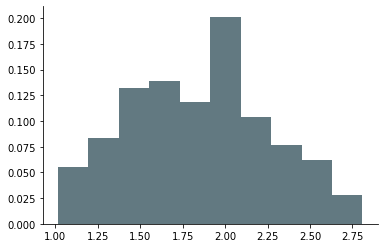

In [9]:
plt.hist(θ_list*1000, weights=πa[:,-1,-1])
plt.hist(θ_list*1000, weights=πa_o[:, 0, 0], alpha=0.3)

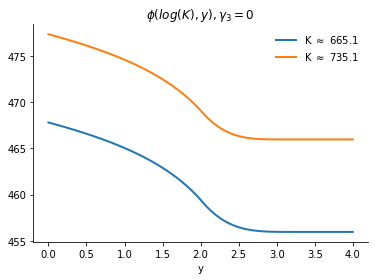

In [10]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

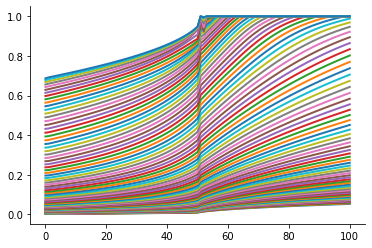

In [159]:
plt.plot(1 -  ems_new/(α*λ_bar*np.exp(k_mat)))
plt.show()

Text(0.5, 0, 'y')

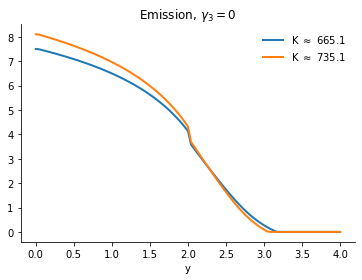

In [160]:
# plt.plot(y_grid, ems[:, -1])
plt.plot(y_grid, ems[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'Emission, $\gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('emission_01.png', dpi=300)
# plt.ylim(0,12)

In [161]:
y_grid[-50], y_mat.shape

(2.04, (101, 91))

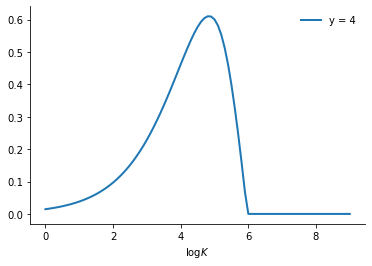

In [162]:
plt.plot(k_grid, ems[-1], label="y = 4")
plt.xlabel("$\log K$")
plt.legend()
plt.savefig('e_logk.png')

In [11]:
np.exp(7), y_grid[40]

(1096.6331584284585, 1.6)

Text(0.5, 1.0, 'Emission')

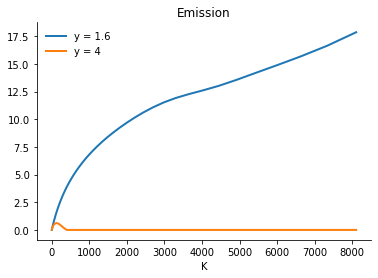

In [14]:
plt.plot(np.exp(k_grid), ems[40], label = "y = 1.6")
plt.plot(np.exp(k_grid), ems[-1], label = "y = 4")
plt.legend()
plt.xlabel('K')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 1.0, 'Emission')

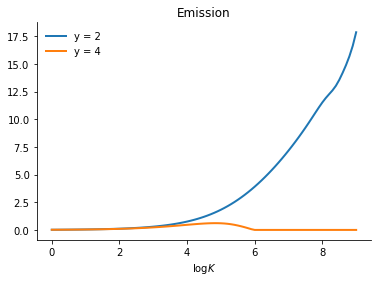

In [15]:
plt.plot(k_grid, ems[40], label = "y = 2")
plt.plot(k_grid, ems[-1], label = "y = 4")
plt.legend()
plt.xlabel('$\log K$')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 0, 'y')

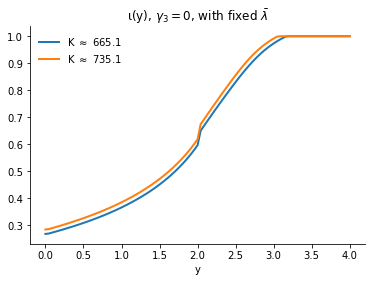

In [166]:
iota = 1 - ems/np.exp(k_mat)/α/λ_bar
plt.plot(y_grid, iota[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, iota[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'ι(y), $\gamma_3 = 0$, with fixed $\bar \lambda$')
plt.xlabel('y')
# plt.savefig('iota_01.png', dpi=300)

Text(0.5, 0, 'y')

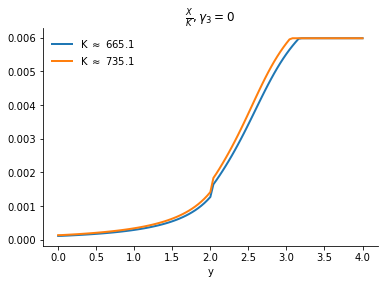

In [167]:
ra = α*ϑ_bar*iota**θ
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{X}{K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('XK_new.png', dpi=300)

Text(0.5, 0, 'y')

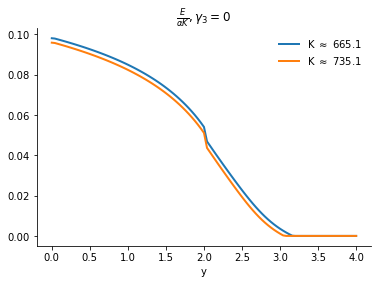

In [168]:
ra = ems/np.exp(k_mat)/α
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{E}{\alpha K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ratio_01.png', dpi=300)

In [169]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [170]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Simulation

??:

$$
ME_t = \vartheta_t \theta \frac{1}{\lambda_t} \left[1 -  \frac{\mathcal{E}_t}{\alpha \lambda_t K_t }\right]^{\theta - 1}
$$

In [171]:
class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

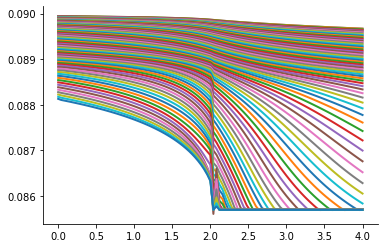

In [172]:
plt.plot(y_grid, i)
plt.show()

In [16]:
y_grid.shape

(101,)

In [173]:
Time = 90
ppy = 12
pers = ppy * Time
# pers = 100
dt = Time / pers
nDims = 3 
its = 1

gridpoints = (y_grid, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')
def e_func(x):
    return e_func_r.get_value(x[0], x[1]) # match order
# interpolate investment
i_func_r = GridInterp_2d(gridpoints, i, 'Linear')
def i_func(x):
    return i_func_r.get_value(x[0], x[1])

# drifts for each diffusion process
def compute_μlogk(x):
    return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
def compute_μy(E_x):
    return  E_x*np.mean(θ_list)
def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
    ddΛ = γ2 + γ3*(Y_x > y_bar)  
    return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

# initial points

K_0 = 80/α
Y_0 = 1.1
D_0 = np.exp(γ1*Y_0 + γ2*Y_0**2 + γ3*((Y_0 - y_bar)**2)*(Y_0 >y_bar))-1
          
# stop
hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])

for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [Y_0, np.log(K_0), D_0]
        e_hist[0] = e_func(hist[0,:])
        i_hist[0] = i_func(hist[0,:])

    else:
        # other periods
        hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
        hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
        hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
        e_hist[tm] = e_func(hist[tm,:])
        i_hist[tm] = i_func(hist[tm,:])

e_k_ratio = e_hist/np.exp(hist[:,1])/α
Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
XK_t = α*θ_bar*Iota_t**θ
MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

simul = dict(e= e_hist, states= hist)

Text(0.5, 0, 'Years')

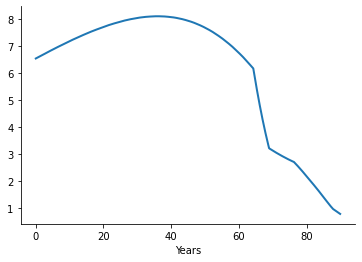

In [174]:
plt.plot(np.arange(0, Time, dt), e_hist)
plt.xlabel('Years')
# plt.savefig('Et.png')

Text(0.5, 1.0, '$\\frac{E_t}{\\alpha K_t}$')

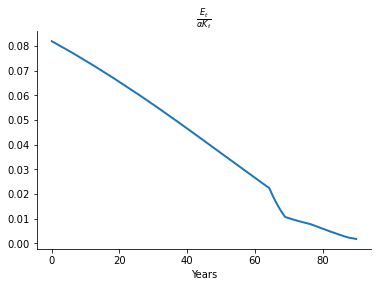

In [175]:
plt.plot(np.arange(0, Time, dt), e_k_ratio)
plt.xlabel('Years')
plt.title(r'$\frac{E_t}{\alpha K_t}$')
# plt.savefig('ratio.png')

Text(0.5, 1.0, '$\\iota_t$')

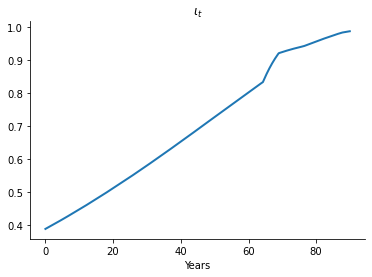

In [176]:
plt.plot(np.arange(0, Time, dt), Iota_t)
plt.xlabel('Years')
plt.title(r"$\iota_t$")
# plt.savefig('iota_t.png')

In [177]:
hist[480],e_hist[480]

(array([1.66521938, 7.32193548, 0.00909602]), 8.088168801419666)

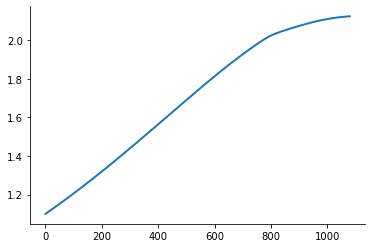

In [178]:
plt.plot(hist[:,0])

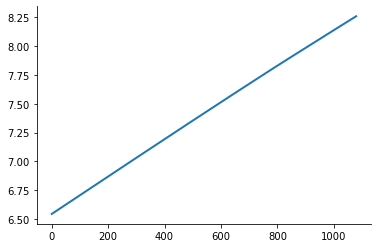

In [179]:
plt.plot(simul['states'][:, 1])

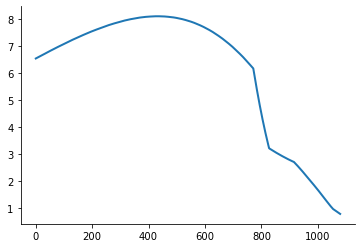

In [180]:
plt.plot(simul['e'])

In [181]:
γ3

0.3333333333333333